In [1]:
import os
from pathlib import Path

import polars as pl

from adex.helpers import get_pre_processed_dataset
from adex.models import Condition, TISSUE_COLORS, ConditionDataLoader, TissueEnum, ConditionTissueDataLoader, \
    FileDataLoader, ConditionSequencingTissueDataLoader, SequencingTechnique
from adex.models import METADATA_COLUMNS, DATASET_INFO_COLUMNS
from adex.pca import PcaHelper

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import logging
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = 20

files_path = "../data/adex-database/samples"
metadata_path = "../data/adex-database/metadata.csv"
datasets_info_path = "../data/adex-database/datasets_info.csv"

# Experiment with PCA for the RA dataset

In [2]:
ra_dataset = get_pre_processed_dataset(ConditionDataLoader(Condition.RA), files_path, metadata_path, datasets_info_path)
ra_dataset.shape

(1122, 10453)

In [3]:
ra_dataset.head(2)

shape: (2, 10_453)
┌────────────┬──────────┬──────────┬──────────┬───┬─────────┬──────────────┬─────────────┬─────────┐
│ Sample     ┆ RFC2     ┆ HSPA6    ┆ PAX8     ┆ … ┆ Disease ┆ Method       ┆ Title       ┆ Samples │
│ ---        ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---     ┆ ---          ┆ ---         ┆ ---     │
│ str        ┆ f64      ┆ f64      ┆ f64      ┆   ┆ str     ┆ str          ┆ str         ┆ i64     │
╞════════════╪══════════╪══════════╪══════════╪═══╪═════════╪══════════════╪═════════════╪═════════╡
│ GSM2981181 ┆ 5.837252 ┆ 9.272079 ┆ null     ┆ … ┆ SLE RA  ┆ Expression   ┆ [HG-U219]   ┆ 234     │
│            ┆          ┆          ┆          ┆   ┆         ┆ profiling by ┆ Affymetrix  ┆         │
│            ┆          ┆          ┆          ┆   ┆         ┆ array        ┆ Human       ┆         │
│            ┆          ┆          ┆          ┆   ┆         ┆              ┆ Genom…      ┆         │
│ GSM940507  ┆ 7.321412 ┆ 9.568313 ┆ 5.092474 ┆ … ┆ SLE RA  ┆ Expression   ┆ The multifa ┆ 74      │
│            ┆          ┆          ┆          ┆   ┆         ┆ profiling by ┆ ceted       ┆         │
│            ┆          ┆          ┆          ┆   ┆         ┆ array        ┆ balance of  ┆         │
│            ┆          ┆          ┆          ┆   ┆         ┆              ┆ TNF-…       ┆         │
└────────────┴──────────┴──────────┴──────────┴───┴─────────┴──────────────┴─────────────┴─────────┘

In [8]:
ra_dataset_only_features_pandas = ra_dataset.drop("Sample").drop(METADATA_COLUMNS).drop(DATASET_INFO_COLUMNS).to_pandas()

In [3]:
ra_dataset_only_features_pandas.head()

RFC2      HSPA6      PAX8      THRA       CCL5     EPHB3     ESRRA  \
0  6.935513  10.328108  4.873228  5.963415  10.016460  5.275080  6.415094   
1  8.665085   8.878719  9.280520  9.762297   9.532689  6.535804  8.367819   
2  6.816081  10.518307  5.048873  5.935053   9.623527  5.368471  6.778983   
3  8.775783   9.209211  7.706040  9.273809   8.592077  6.931581  9.150785   
4  8.456551   8.481696  7.513859  8.933533   9.309559  7.263492  7.678253   

      SCARB1    TTLL12      MAPK1  ...     RGPD1    LRRC70     TYW1B  \
0   4.738233  7.459920   7.510334  ...  7.003358  5.526262  6.860171   
1   9.246727  7.785039  12.478720  ...  8.900616  6.507546  7.316258   
2   4.969530  6.832008   7.908234  ...  6.789646  5.922462  6.527537   
3  11.068615  8.641875  12.586450  ...  6.649427  6.363111  7.904054   
4   9.148417  7.169351  12.359362  ...  6.691451  7.756866  8.132931   

     BZW1P2  RPL23AP82      RPL26  Disease  \
0  5.722412   6.756793  10.077082   SLE RA   
1  6.860217   8.606339  14.948782       RA   
2  6.539699   7.259032  10.330671   SLE RA   
3  7.083470   8.271927  12.563593       RA   
4  8.389805   8.617537  13.357649       RA   

                                              Method  \
0                      Expression profiling by array   
1  Expression profiling by high throughput sequen...   
2                      Expression profiling by array   
3  Expression profiling by high throughput sequen...   
4  Expression profiling by high throughput sequen...   

                                               Title  Samples  
0  Lymphotoxin-LIGHT pathway regulates the interf...      805  
1  CD40L-Dependent Pathway Is Active at Various S...      218  
2  Lymphotoxin-LIGHT pathway regulates the interf...      805  
3  CD40L-Dependent Pathway Is Active at Various S...      218  
4  CD40L-Dependent Pathway Is Active at Various S...      218  

[5 rows x 10447 columns]

In [9]:
ra_dataset_values = ra_dataset_only_features_pandas.values
ra_dataset_values

array([[ 7.8577416 , 10.53413304,  7.17975487, ...,         nan,
                nan,         nan],
       [ 7.60034631, 11.26007576,  4.80034413, ..., 10.12799873,
         8.19495565,  6.44103955],
       [ 6.73152156,  9.30044823,         nan, ...,  9.35885654,
         6.20384426,  7.41111474],
       ...,
       [ 6.99327557, 11.23518039,  7.04818249, ...,         nan,
                nan,         nan],
       [ 7.74295282,  8.80069058,  5.31677086, ..., 11.50491635,
         7.62847762,  9.55449437],
       [ 7.29298399, 10.67084182,  4.83707186, ..., 10.02391361,
         7.95263673,  6.34027683]])

In [10]:
ra_dataset_normalized_values = StandardScaler().fit_transform(ra_dataset_values) # normalizing the features
ra_dataset_normalized_values

array([[ 0.90203144,  0.59980232,  0.83544271, ...,         nan,
                nan,         nan],
       [ 0.59877497,  1.0612593 , -0.83691034, ..., -0.35901348,
         0.9441176 , -0.13654147],
       [-0.42485185, -0.18440896,         nan, ..., -0.88206666,
        -1.36387125,  0.60829387],
       ...,
       [-0.11646006,  1.04543416,  0.74296794, ...,         nan,
                nan,         nan],
       [ 0.76679027, -0.50208781, -0.47394324, ...,  0.57735584,
         0.28748684,  2.25400641],
       [ 0.23664865,  0.68670341, -0.8110965 , ..., -0.4297963 ,
         0.66323458, -0.2139083 ]])

In [11]:
ra_dataset_normalized_values.shape

(1122, 10443)

In [12]:
# Check whether the normalized data has a mean of zero and a standard deviation of one! 
np.nanmean(ra_dataset_normalized_values), np.nanstd(ra_dataset_normalized_values)

(6.72353308935852e-18, 0.9999999999999998)

In [13]:
ra_dataset_normalized_pandas = pd.DataFrame(ra_dataset_normalized_values)
ra_dataset_normalized_pandas

0         1         2         3         4         5         6      \
0     0.902031  0.599802  0.835443  0.325260 -1.619054  1.864173  1.441261   
1     0.598775  1.061259 -0.836910 -0.475571  0.312027 -0.591985 -0.661168   
2    -0.424852 -0.184409       NaN -0.464707  1.059520       NaN  0.967978   
3     0.545608  0.553522 -0.712813 -0.121759  0.488609 -0.554607 -0.535488   
4     0.529316  1.027130 -0.339010 -0.215327  0.297668 -0.171593 -0.289745   
...        ...       ...       ...       ...       ...       ...       ...   
1117  1.165616 -0.990606 -0.729009 -0.498030 -1.602544 -0.307158 -0.046303   
1118 -0.068781  0.942160       NaN  0.635309  1.989066 -1.638315  1.162689   
1119 -0.116460  1.045434  0.742968  0.376852 -1.383600  1.769648  0.879810   
1120  0.766790 -0.502088 -0.473943  0.196283 -0.792410 -0.149644  0.054757   
1121  0.236649  0.686703 -0.811096 -0.583281  0.394998 -0.450437 -0.740109   

         7         8         9      ...     10433     10434     10435  \
0     0.307688  1.249989  0.598183  ...       NaN       NaN       NaN   
1    -0.771914  0.224340 -0.221045  ... -0.226019  0.846878  0.135721   
2          NaN -1.790951  0.139177  ... -1.478461 -0.745857  1.252863   
3    -0.725004 -0.037639 -0.337971  ... -0.117840  1.076084  1.484804   
4    -0.166061  0.331030 -0.505203  ... -0.658975 -0.267719  0.548963   
...        ...       ...       ...  ...       ...       ...       ...   
1117 -0.497415  1.085201 -0.187789  ...  0.294862 -0.987287 -1.930677   
1118  0.129725  0.571067  0.858707  ... -2.930956       NaN       NaN   
1119  0.079169  1.121301 -0.733661  ...       NaN       NaN       NaN   
1120 -0.595941  0.345045 -0.892105  ... -0.394731 -0.750715 -1.958076   
1121 -0.631987  0.595301 -0.225221  ...  0.039367  0.928076 -0.300826   

         10436     10437     10438     10439     10440     10441     10442  
0          NaN       NaN       NaN       NaN       NaN       NaN       NaN  
1     1.028985  1.184112 -0.034815  0.018137 -0.359013  0.944118 -0.136541  
2     1.551985  1.714184 -0.952210 -1.341268 -0.882067 -1.363871  0.608294  
3     0.360144  0.506226  0.063937  0.177963 -0.319454  0.392684  0.233802  
4    -0.690549 -0.558676 -0.803125 -0.184300 -0.456497 -1.337051 -0.894498  
...        ...       ...       ...       ...       ...       ...       ...  
1117 -0.954808 -0.826508  0.583020  0.733817  0.312008  0.707839  1.788069  
1118  0.015706 -6.020312       NaN -2.031917 -2.378511 -3.006858 -2.546419  
1119       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
1120 -0.319302 -0.182408  1.087518  0.746857  0.577356  0.287487  2.254006  
1121  0.135859  0.278908 -0.602996 -0.263452 -0.429796  0.663235 -0.213908  

[1122 rows x 10443 columns]

In [14]:
pca = PCA(n_components=2)
ra_pca = pca.fit_transform(ra_dataset_normalized_pandas.fillna(0))

In [15]:
ra_pca_pandas = pd.DataFrame(
    data = ra_pca, 
    columns = ['PC1', 'PC2']
)

In [16]:
ra_pca_pandas.head()

PC1        PC2
0  33.435306 -16.115576
1 -33.284602 -24.979071
2 -37.830825  49.698066
3 -24.054385 -22.558876
4 -36.535748 -36.787535

In [17]:
print(f"Explained variation per principal component: {pca.explained_variance_ratio_}")

Explained variation per principal component: [0.49981769 0.10236722]


<Figure size 640x480 with 0 Axes>

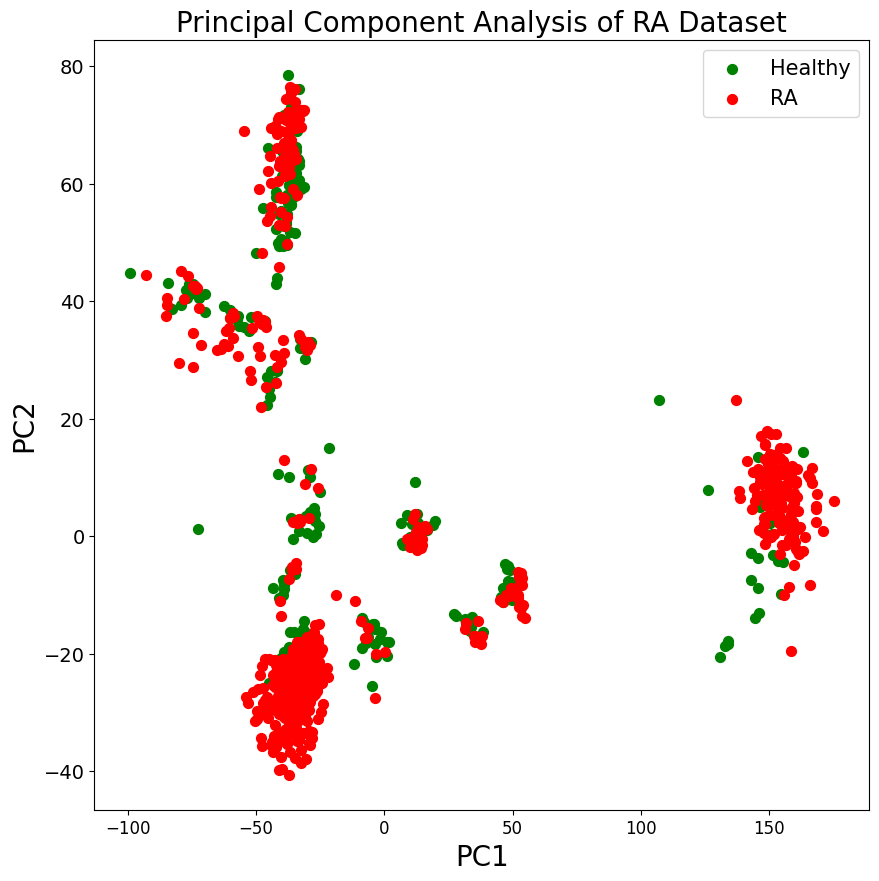

In [18]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('PC1', fontsize=20)
plt.ylabel('PC2', fontsize=20)
plt.title("Principal Component Analysis of RA Dataset", fontsize=20)
targets = ['Healthy', 'RA']
colors = ['g', 'r']
for target, color in zip(targets, colors):
    index = ra_dataset.to_pandas()['Condition'] == target
    plt.scatter(
        ra_pca_pandas.loc[index, 'PC1'], 
        ra_pca_pandas.loc[index, 'PC2'], 
        c=color, 
        s=50
    )

plt.legend(targets, prop={'size': 15})

# PCA per condition

INFO : --- Running PCA for 'RA'---
INFO : Loaded dataset for PCA with shape: Samples(1122), Genes(10453)
INFO : Dataset normalised | Mean: '-5.081911671483222e-18' Standard Deviation:'0.9999999999999998'
INFO : Explained variation per principal component: [0.49981769 0.10236722]
INFO : ----------------------------------------------
INFO : --- Running PCA for 'T1D'---
INFO : Loaded dataset for PCA with shape: Samples(176), Genes(7711)
INFO : Dataset normalised | Mean: '-4.603197963985972e-18' Standard Deviation:'0.9999999999999997'
INFO : Explained variation per principal component: [0.43202088 0.2343705 ]
INFO : ----------------------------------------------
INFO : --- Running PCA for 'SSc'---
INFO : Loaded dataset for PCA with shape: Samples(229), Genes(9984)
INFO : Dataset normalised | Mean: '8.14955373219814e-18' Standard Deviation:'0.9999999999999998'
INFO : Explained variation per principal component: [0.45925356 0.16098887]
INFO : ----------------------------------------------
IN

<Figure size 640x480 with 0 Axes>

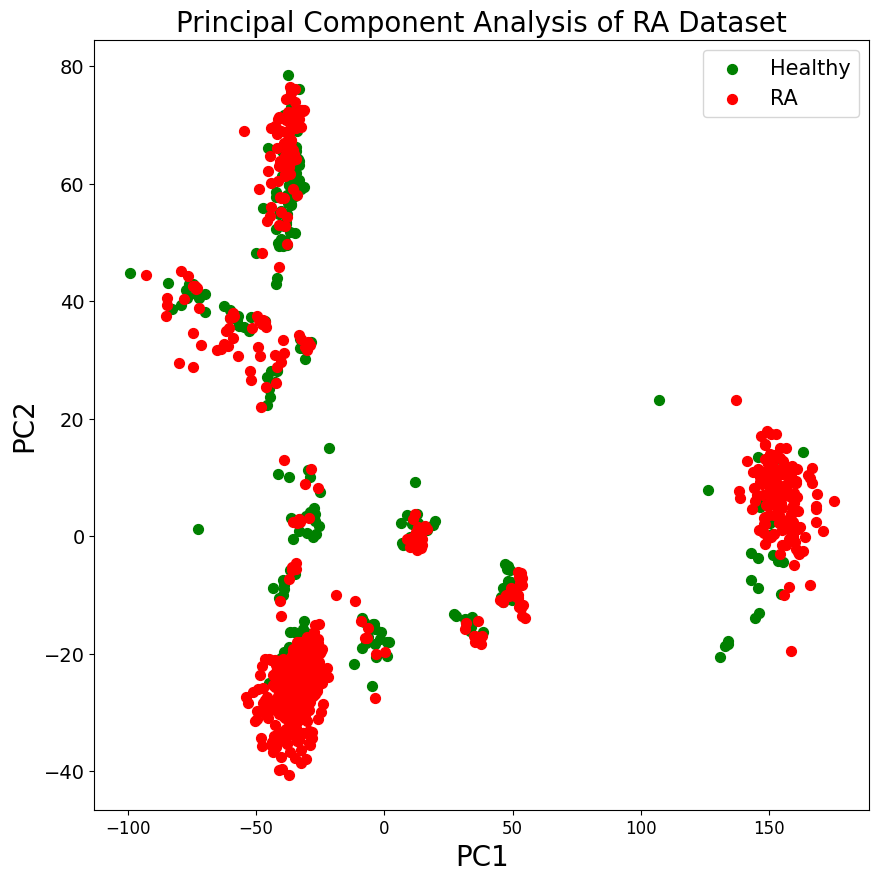

<Figure size 640x480 with 0 Axes>

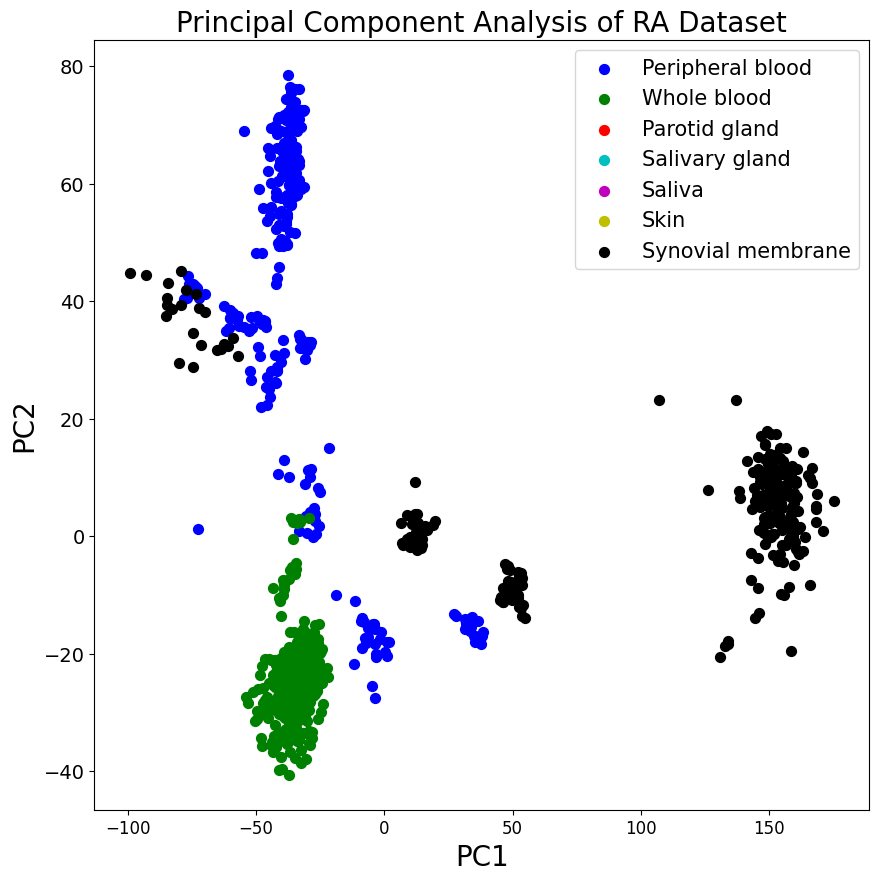

<Figure size 640x480 with 0 Axes>

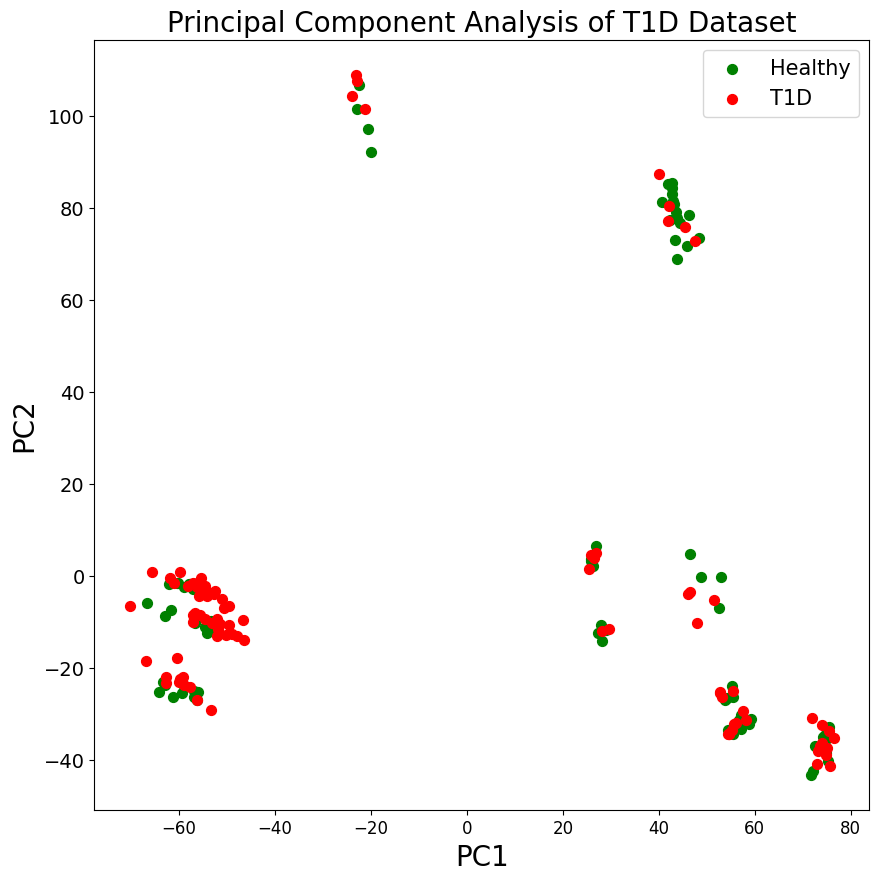

<Figure size 640x480 with 0 Axes>

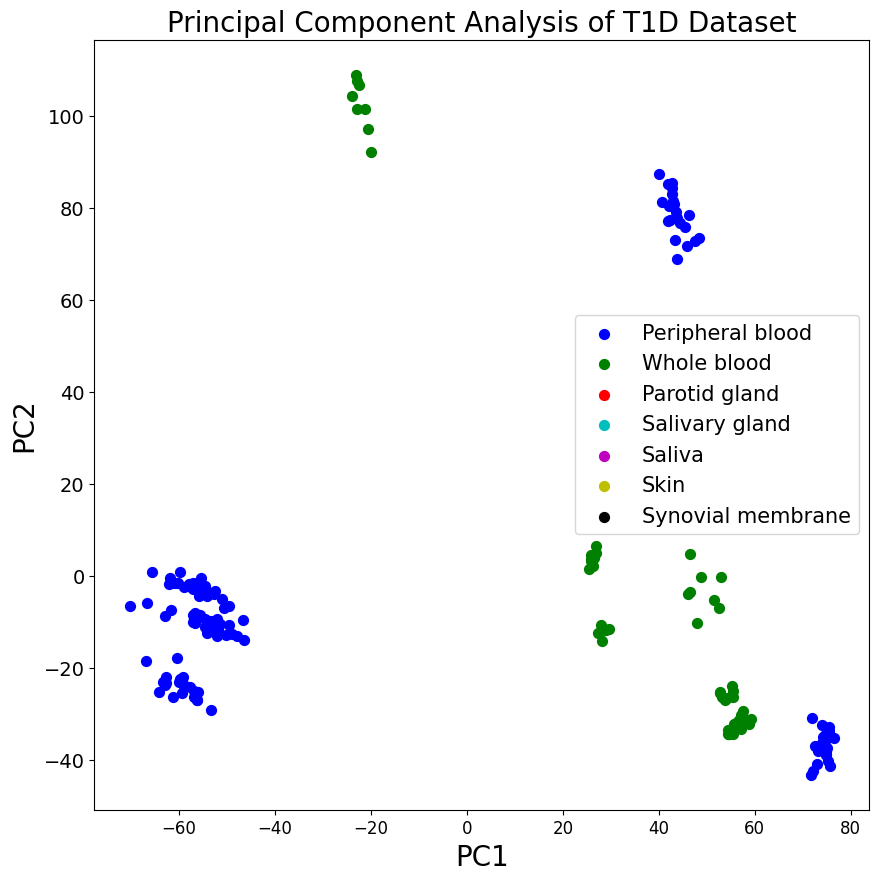

<Figure size 640x480 with 0 Axes>

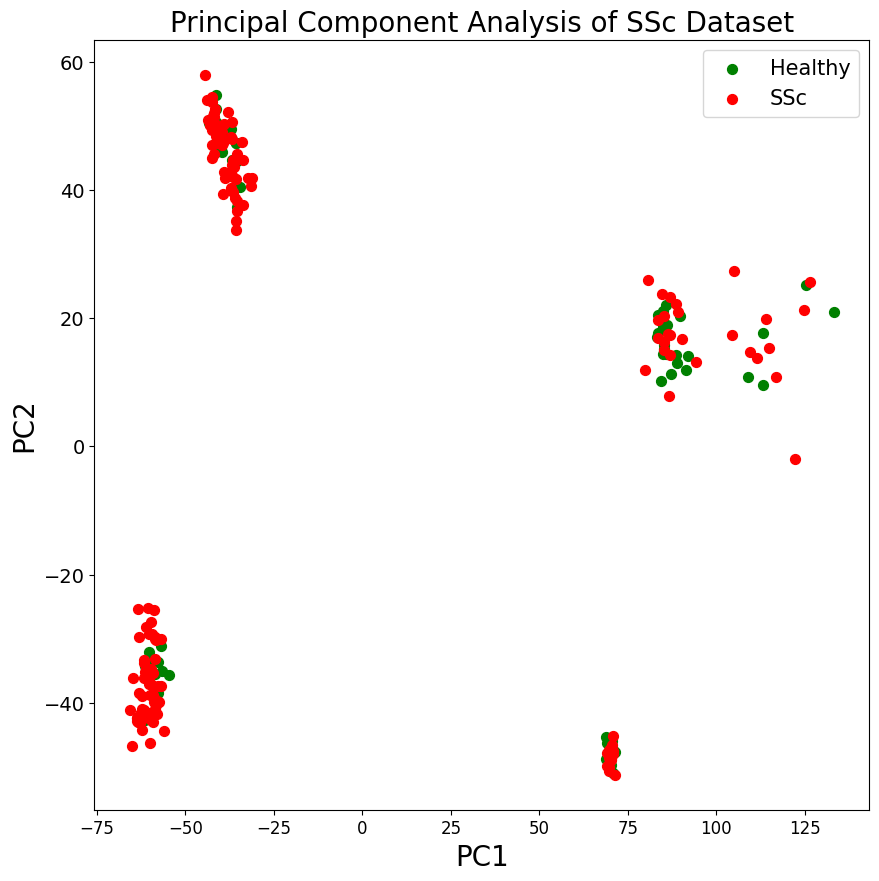

<Figure size 640x480 with 0 Axes>

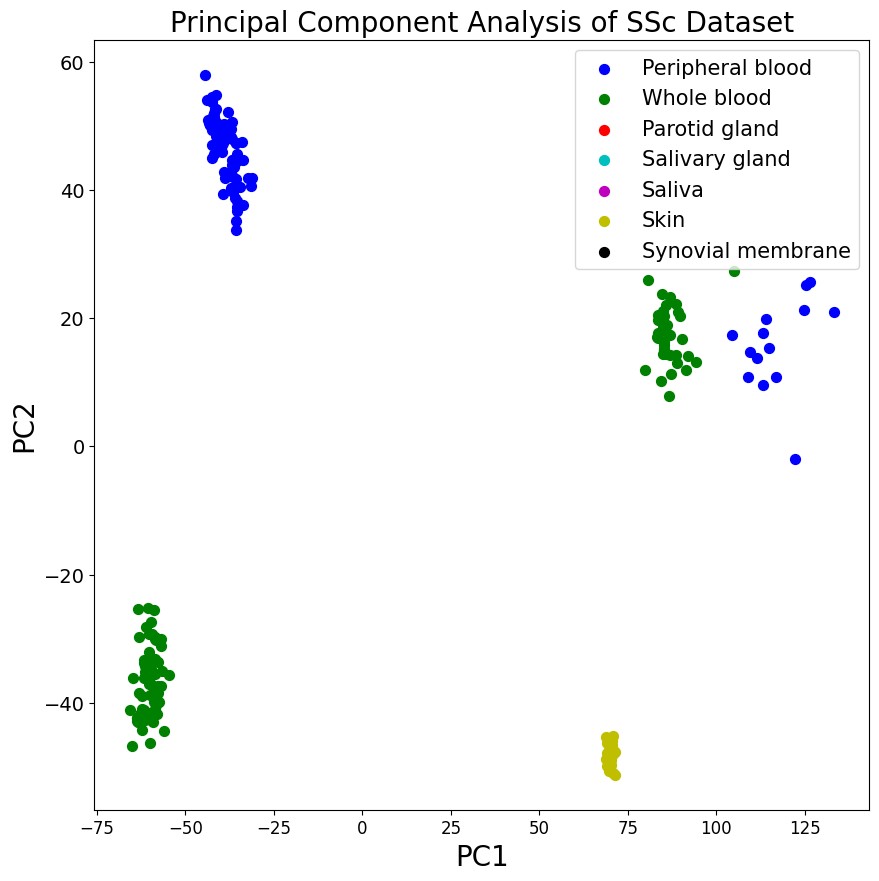

<Figure size 640x480 with 0 Axes>

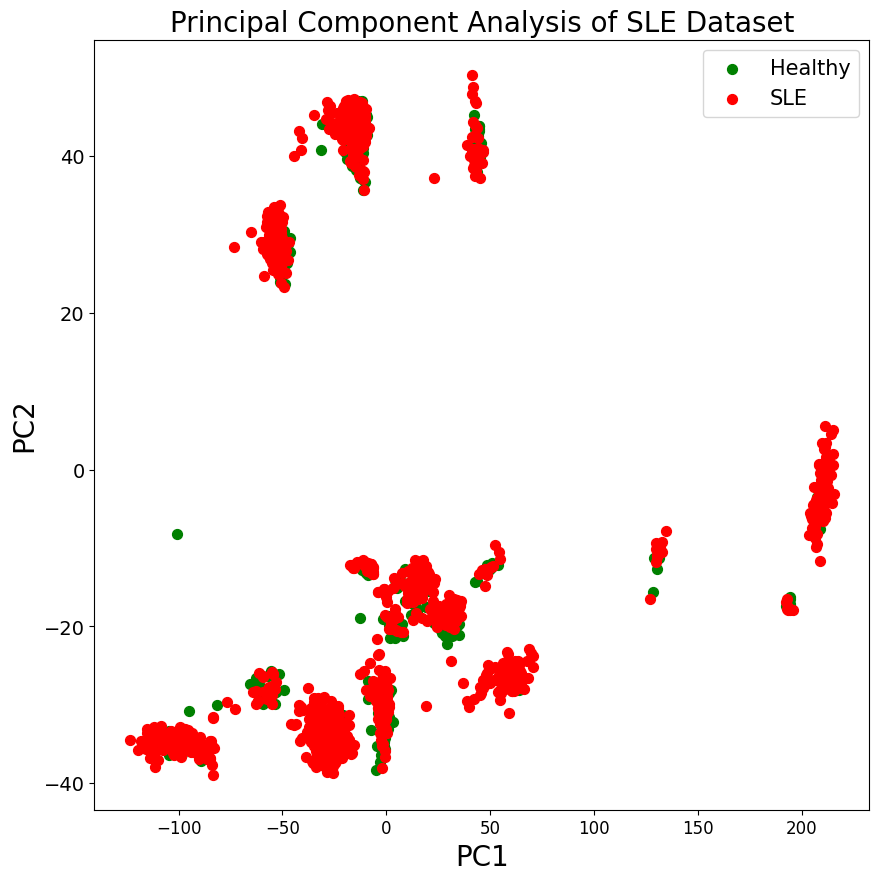

<Figure size 640x480 with 0 Axes>

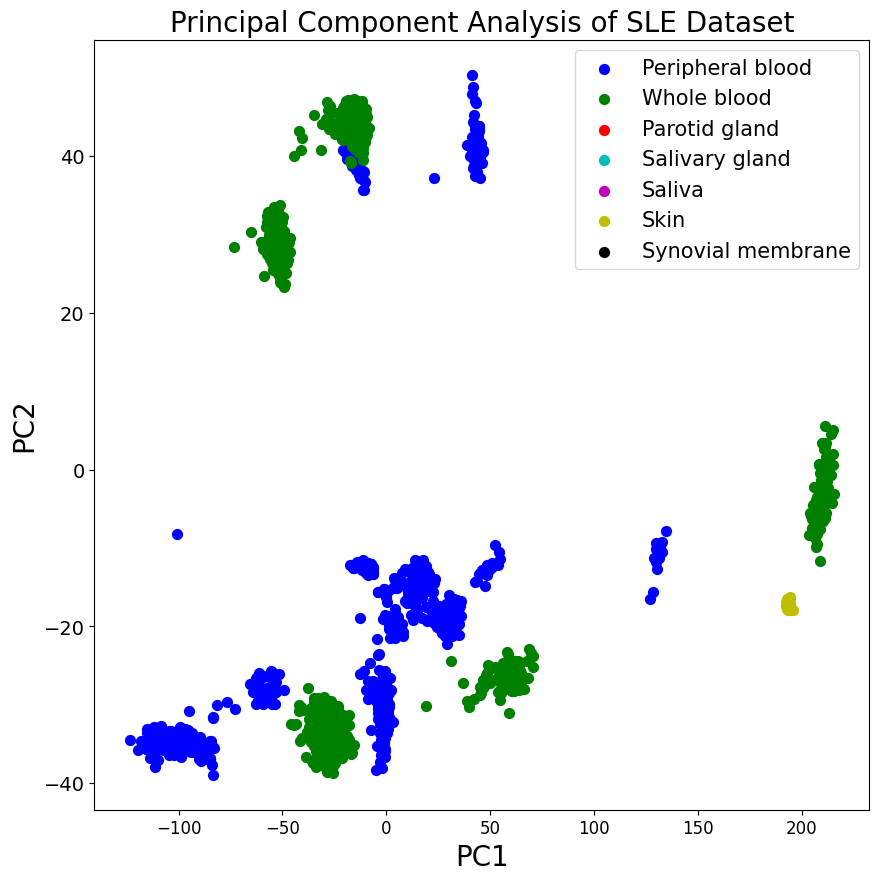

<Figure size 640x480 with 0 Axes>

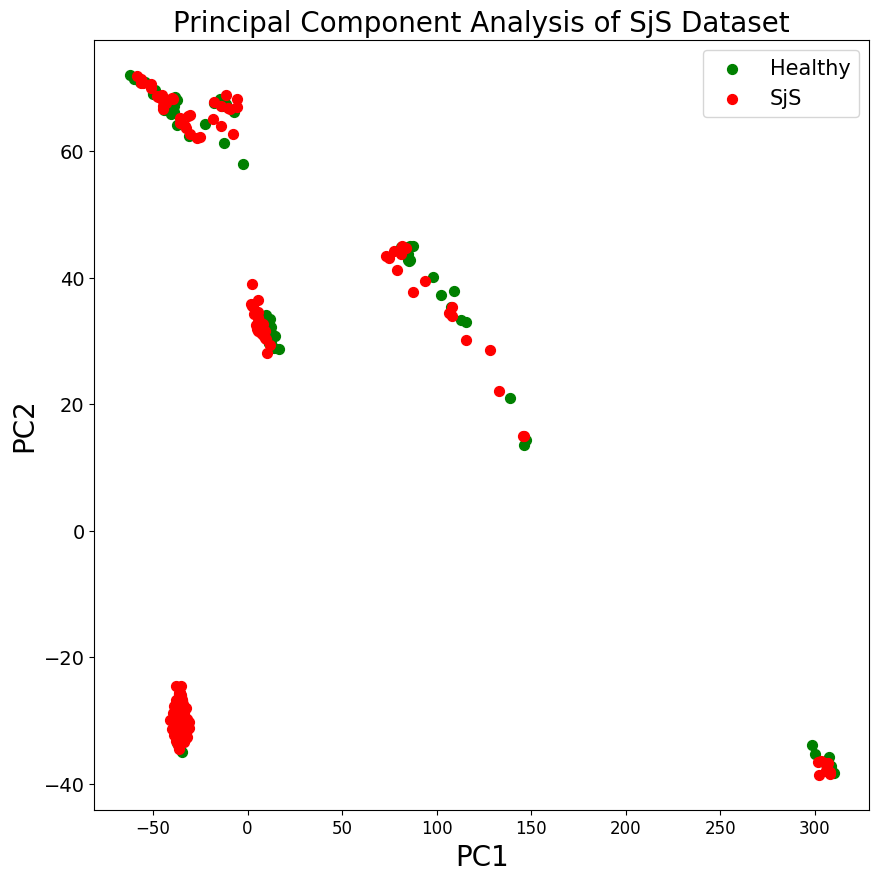

<Figure size 640x480 with 0 Axes>

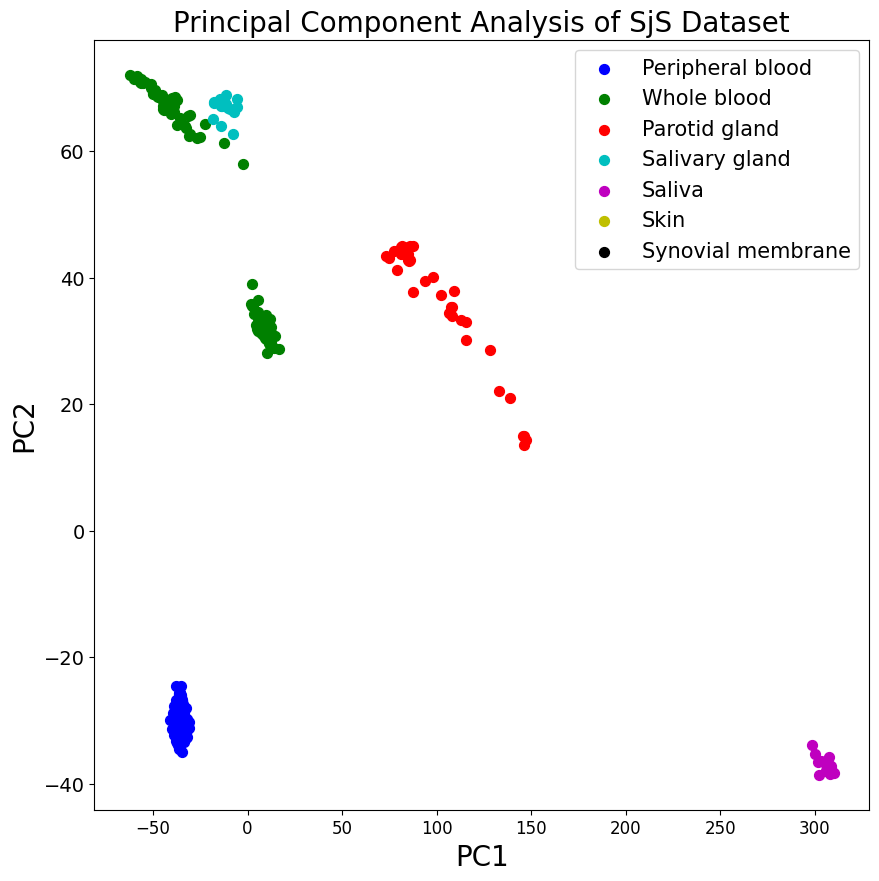

In [2]:
for condition in Condition:
    pca = PcaHelper(ConditionDataLoader(condition), files_path, metadata_path, datasets_info_path)
    pca.draw(
        column_that_defines_colors="Condition",
        target_colors=[
            ("Healthy", "g"),
            (condition.name, "r")
        ]
    )

    pca.draw(
        column_that_defines_colors="Tissue",
        target_colors=TISSUE_COLORS
    )

# PCA per Condition, Tissue, and Sequencing Technique

INFO : --- Running PCA for 'MICROARRAYS|RA|PERIPHERAL_BLOOD'---
INFO : Loaded dataset for PCA with shape: Samples(302), Genes(9677)
INFO : Dataset normalised | Mean: '-8.782425679411016e-18' Standard Deviation:'1.0'
INFO : Explained variation per principal component: [0.31531245 0.22344761]
INFO : ----------------------------------------------
INFO : --- Running PCA for 'MICROARRAYS|RA|WHOLE_BLOOD'---
INFO : Loaded dataset for PCA with shape: Samples(513), Genes(13784)
INFO : Dataset normalised | Mean: '3.0686383133888617e-17' Standard Deviation:'1.0000000000000002'
INFO : Explained variation per principal component: [0.1748401  0.10488159]
INFO : ----------------------------------------------
INFO : --- Not running PCA for data_loader 'ConditionSequencingTissueDataLoader(condition=<Condition.RA: 'Rheumatoid Arthritis'>, sequencing_technique=<SequencingTechnique.MICROARRAYS: 'Expression profiling by array'>, tissue=<TissueEnum.PAROTIC_GLAND: 'Parotid gland'>)' because there is no data-

<Figure size 640x480 with 0 Axes>

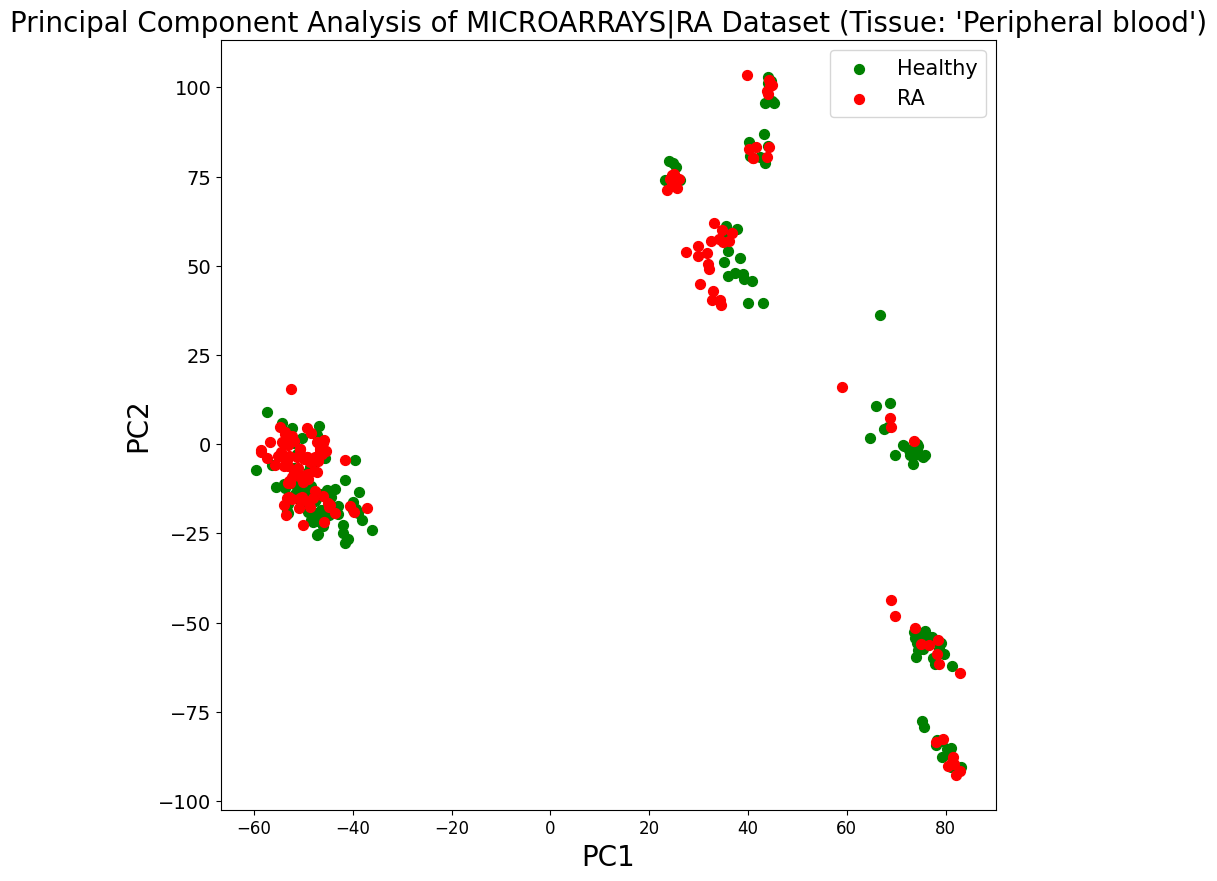

<Figure size 640x480 with 0 Axes>

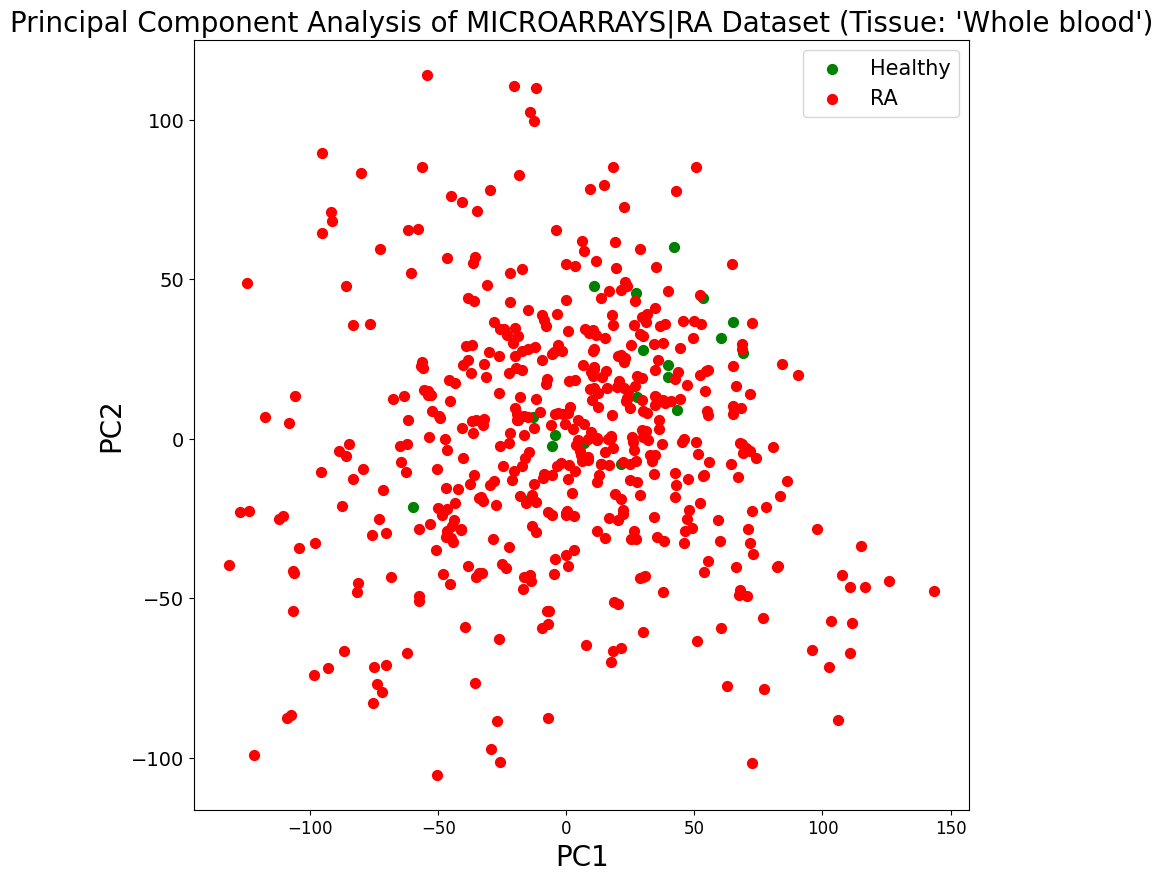

<Figure size 640x480 with 0 Axes>

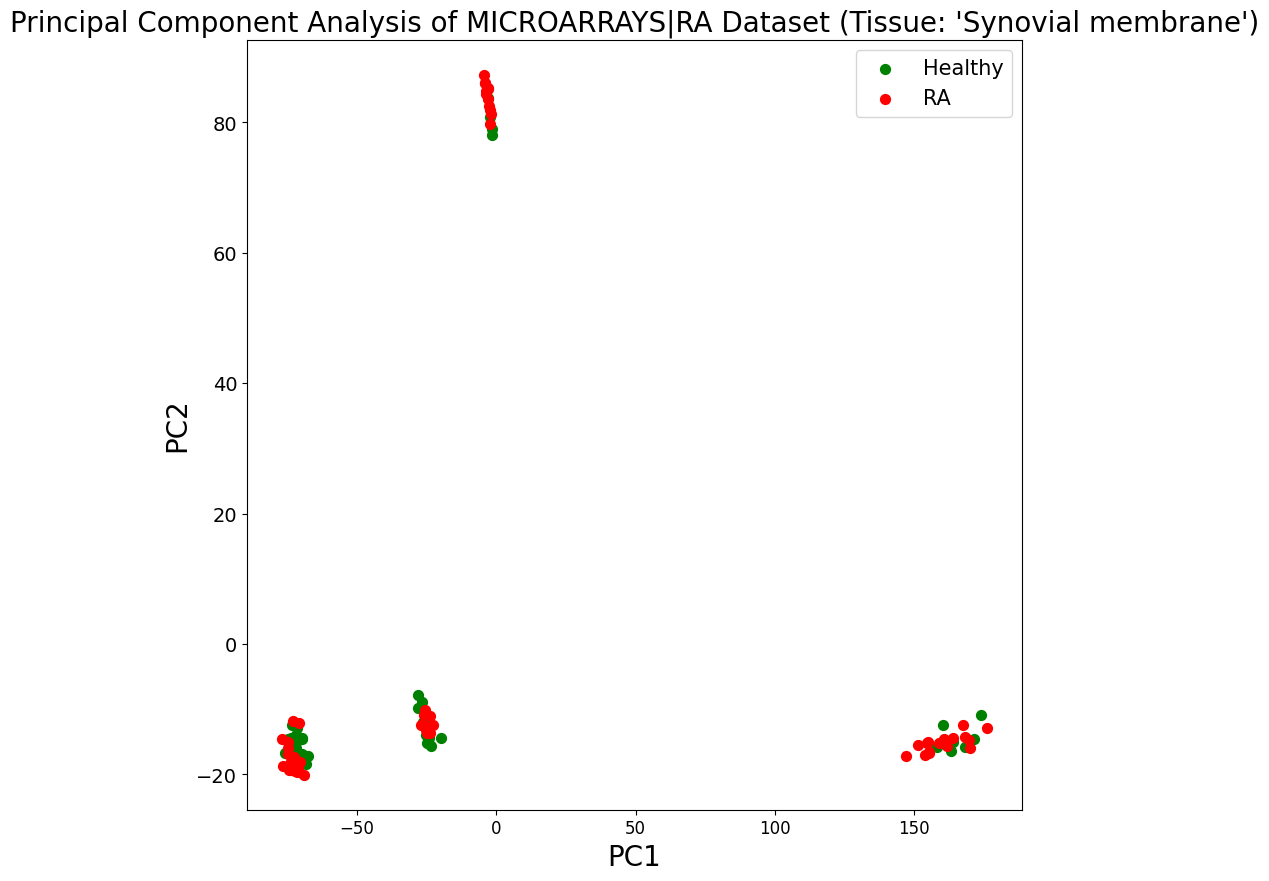

<Figure size 640x480 with 0 Axes>

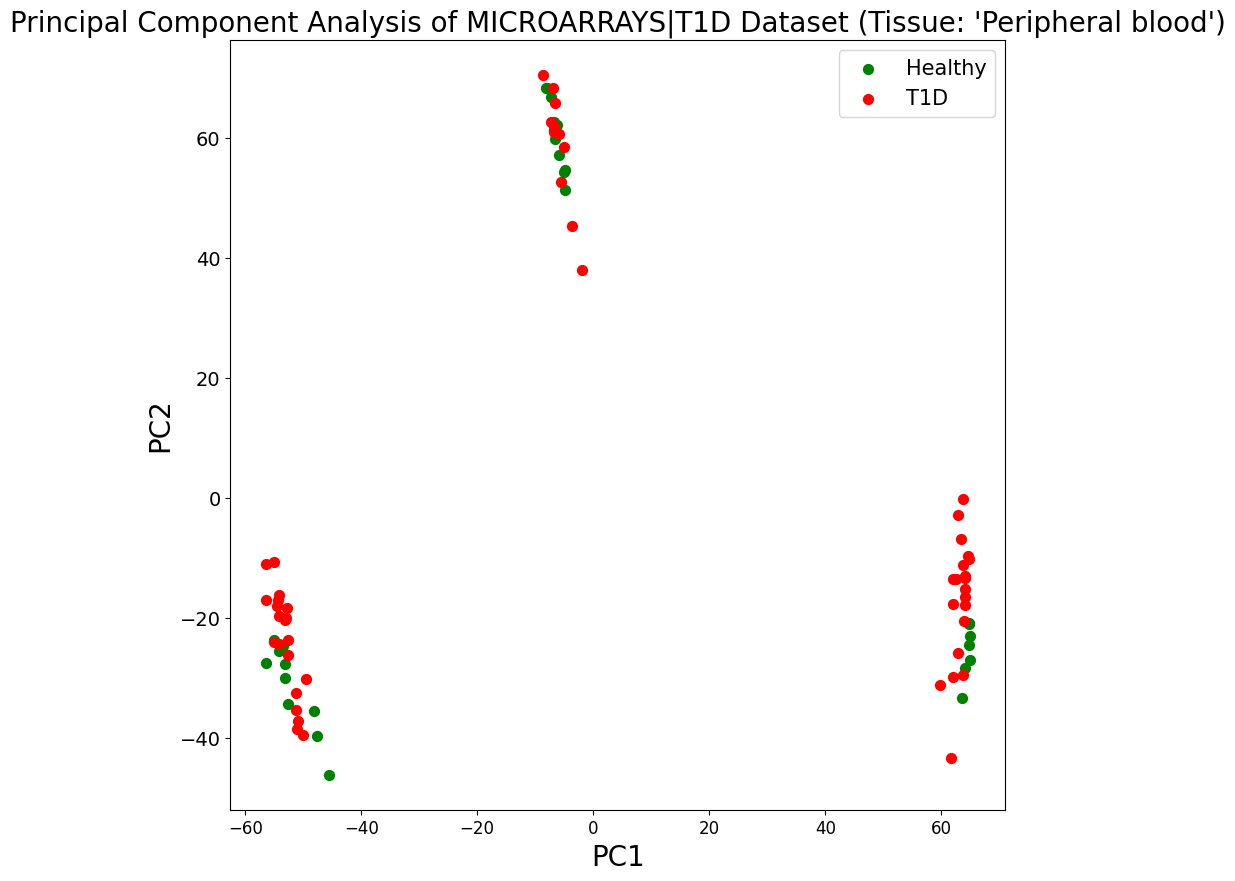

<Figure size 640x480 with 0 Axes>

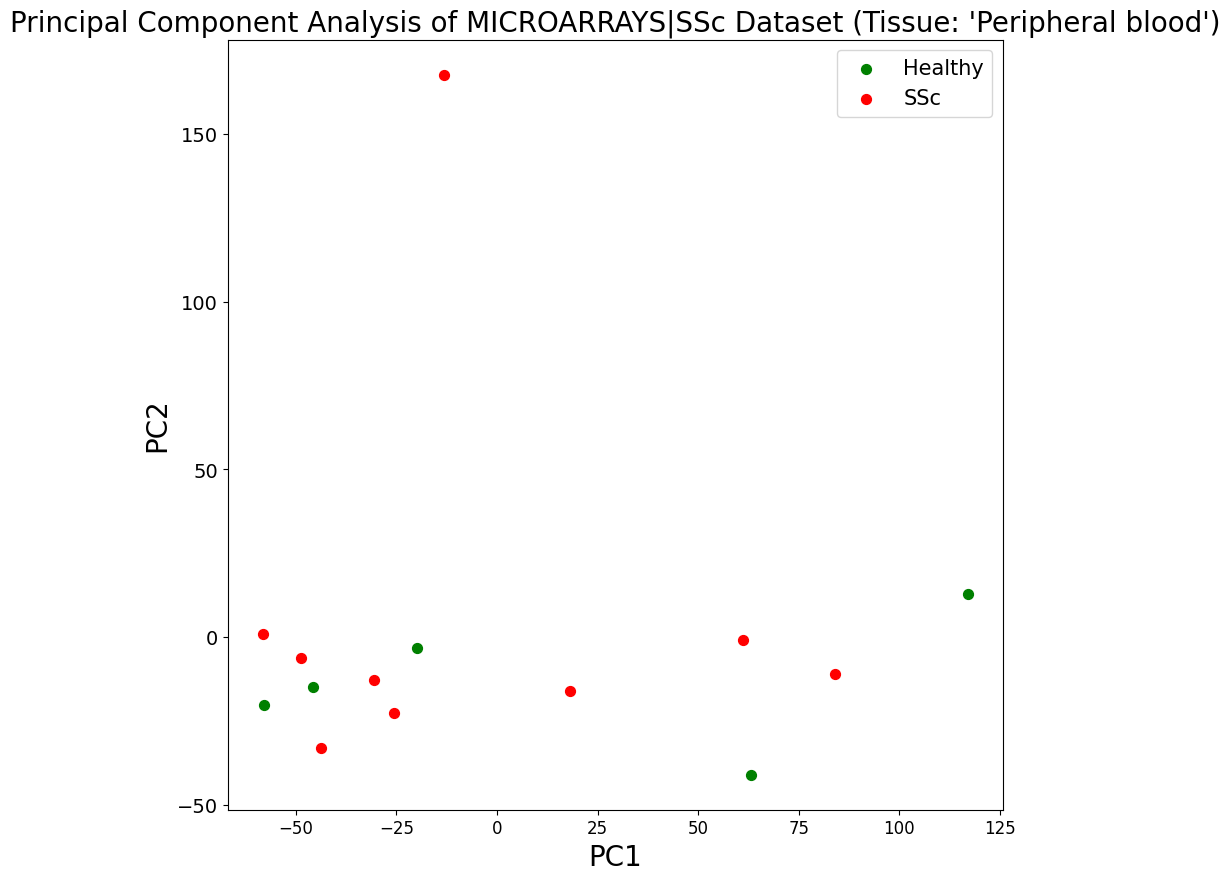

<Figure size 640x480 with 0 Axes>

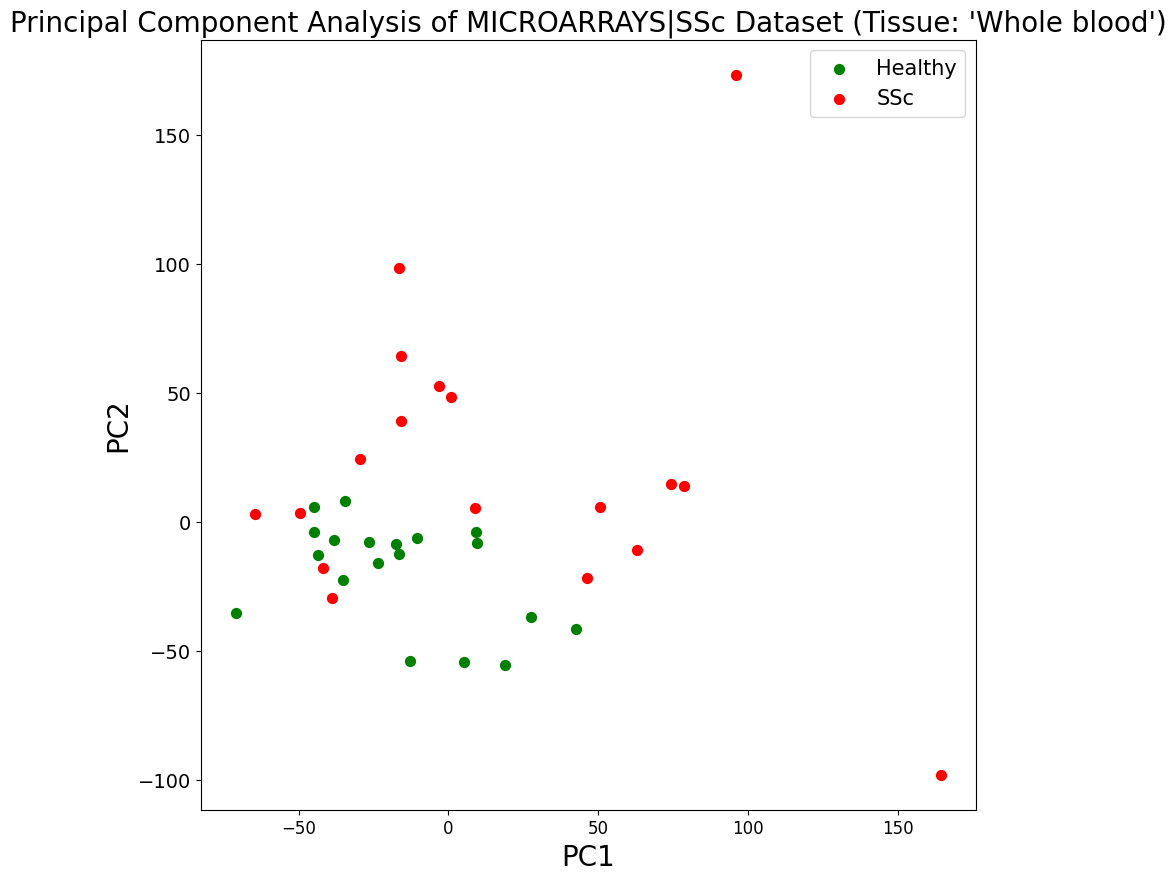

<Figure size 640x480 with 0 Axes>

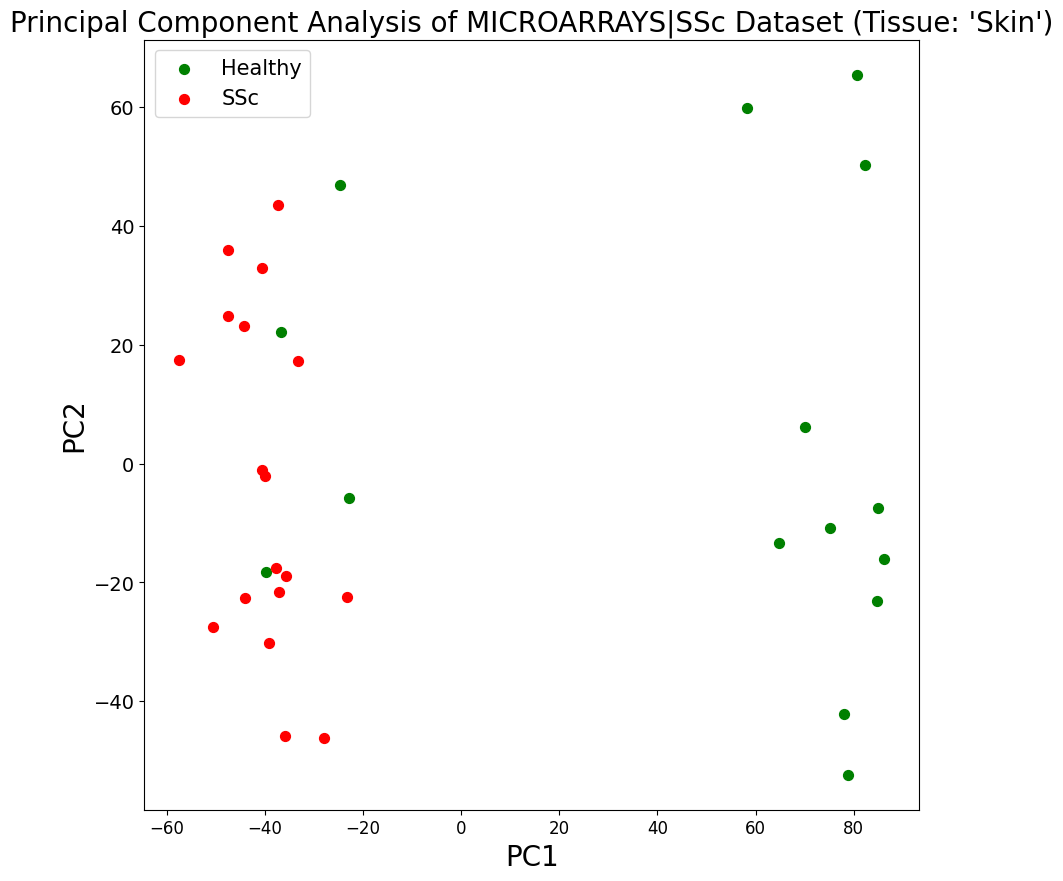

<Figure size 640x480 with 0 Axes>

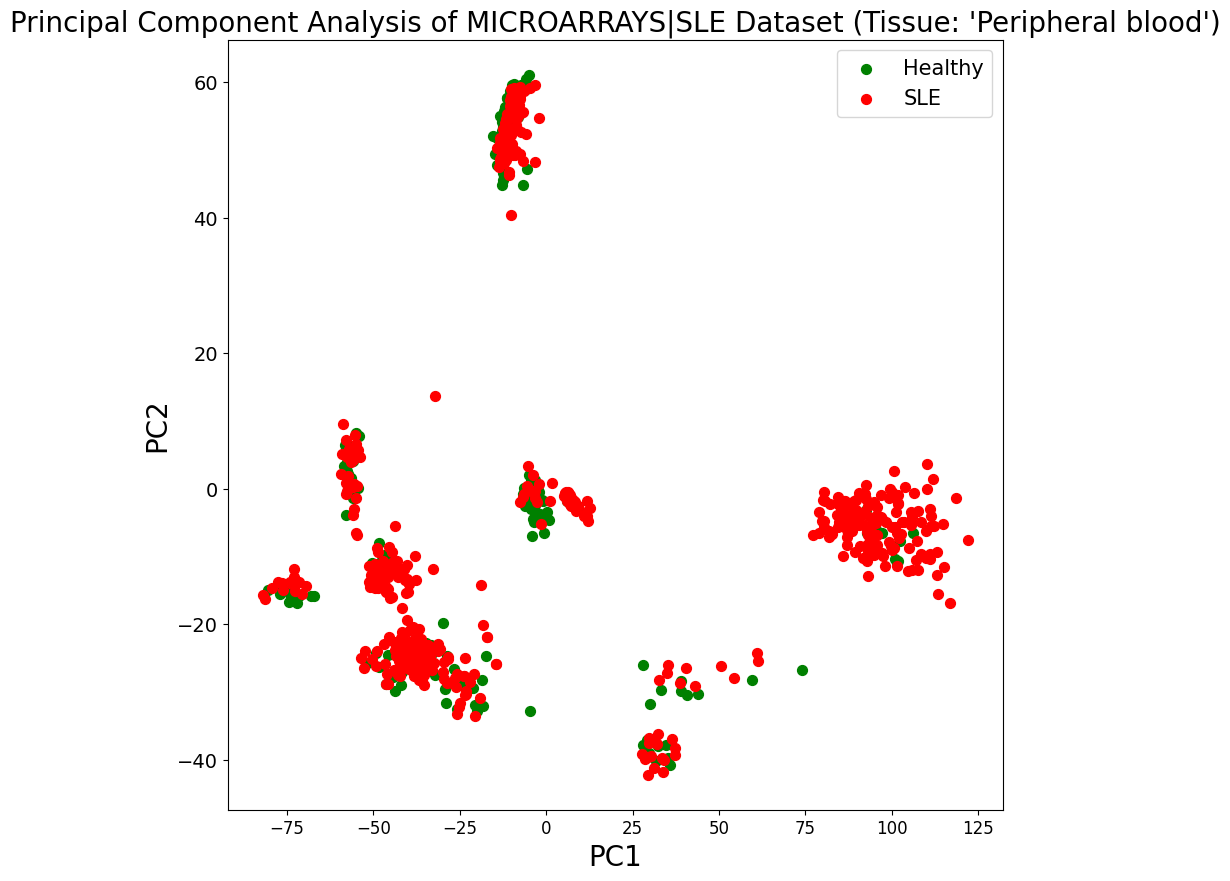

<Figure size 640x480 with 0 Axes>

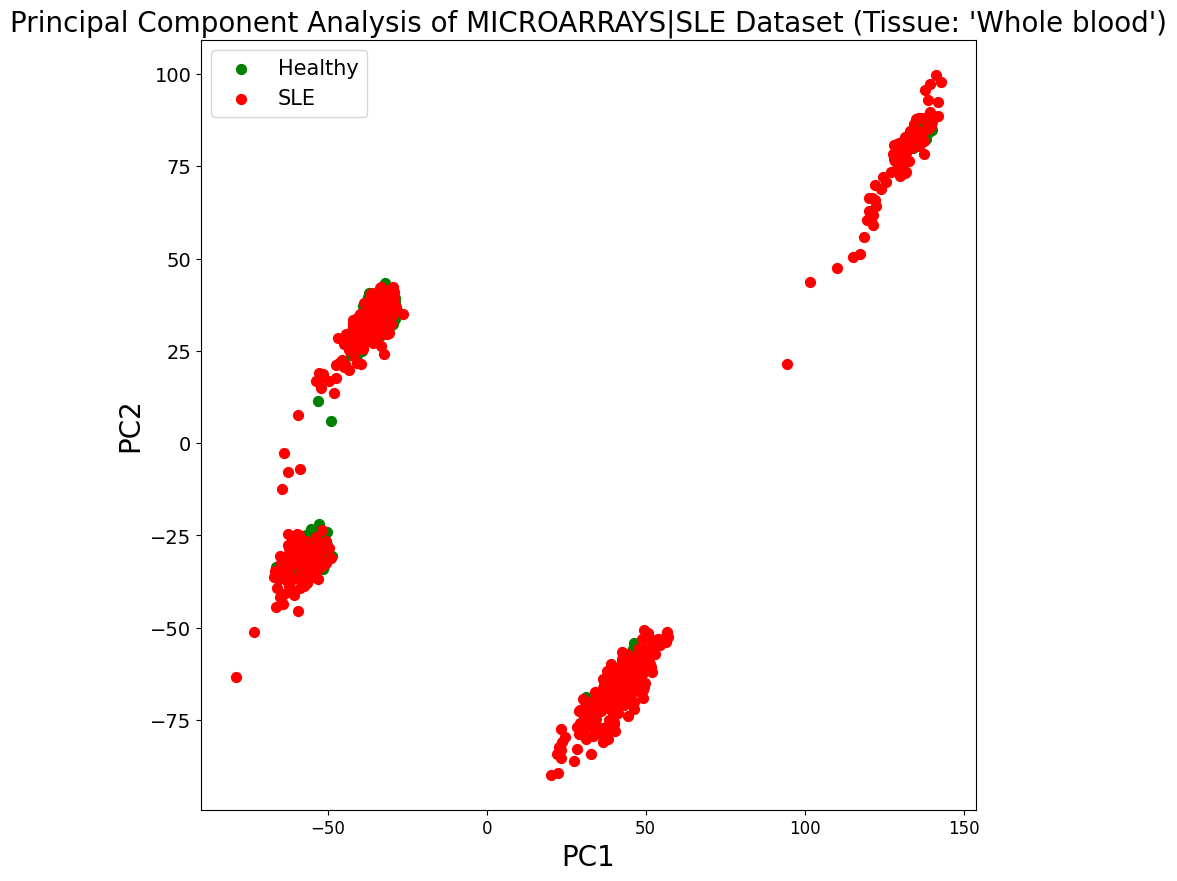

<Figure size 640x480 with 0 Axes>

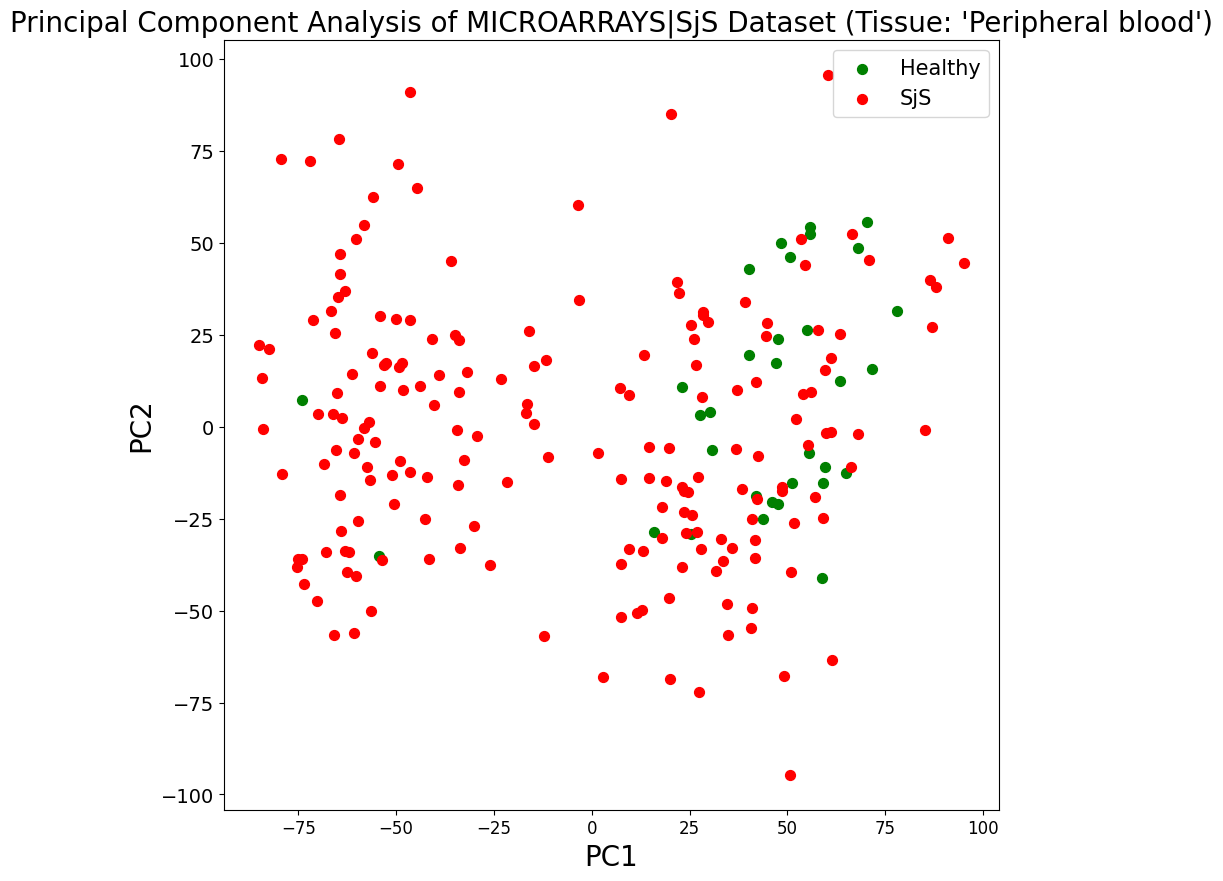

<Figure size 640x480 with 0 Axes>

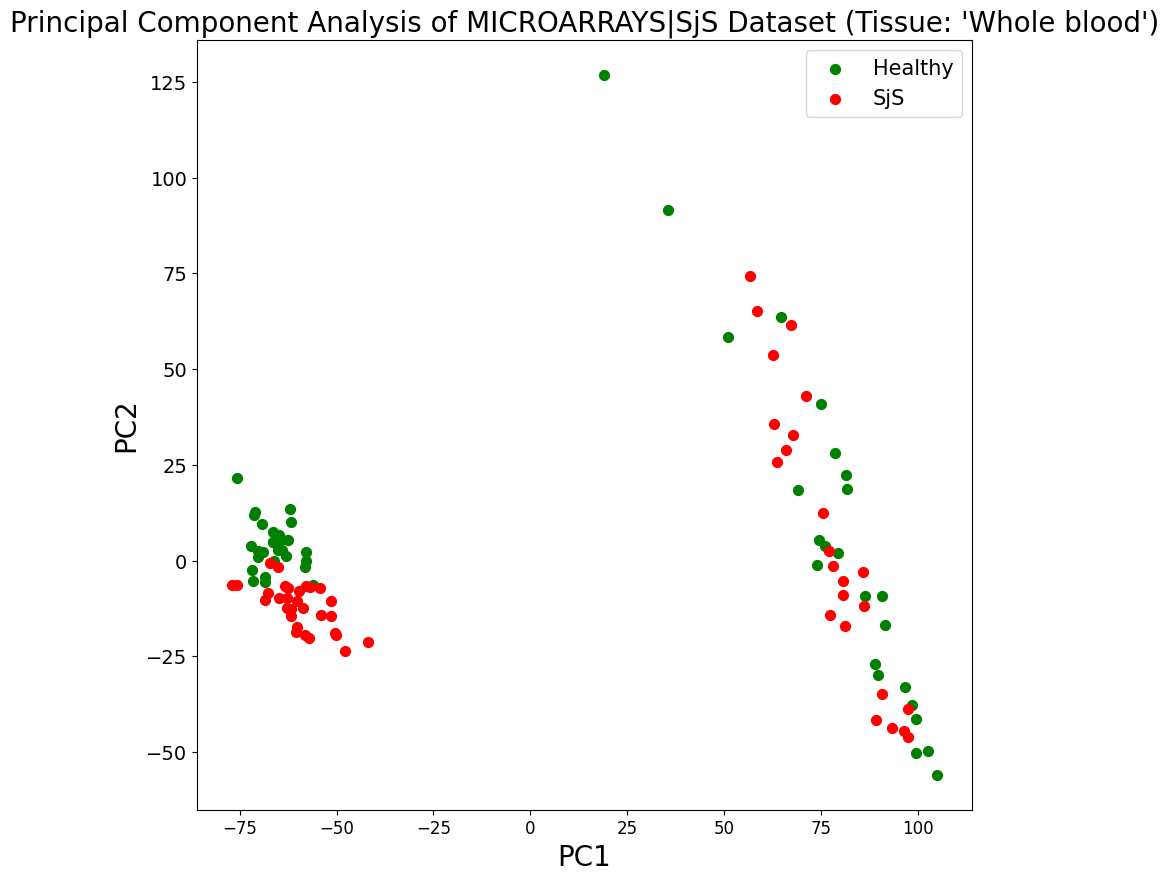

<Figure size 640x480 with 0 Axes>

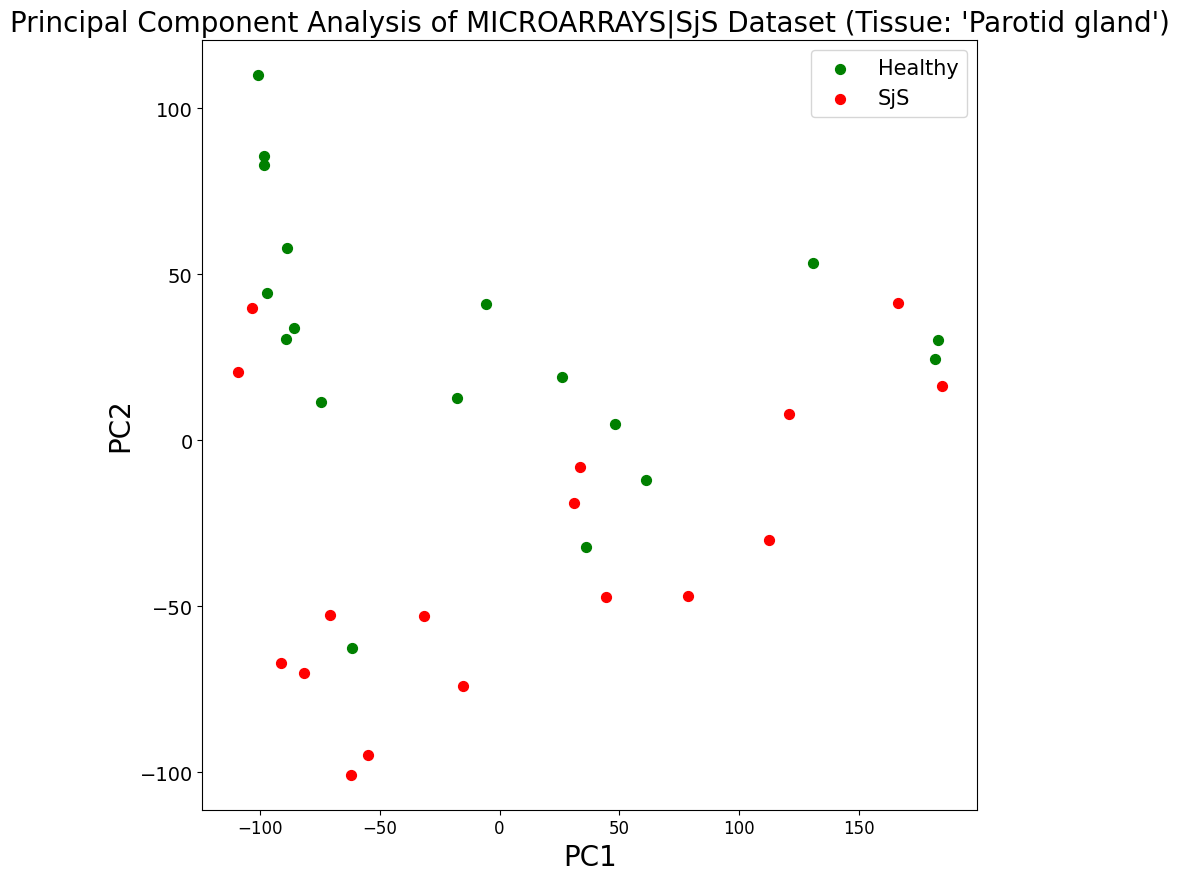

<Figure size 640x480 with 0 Axes>

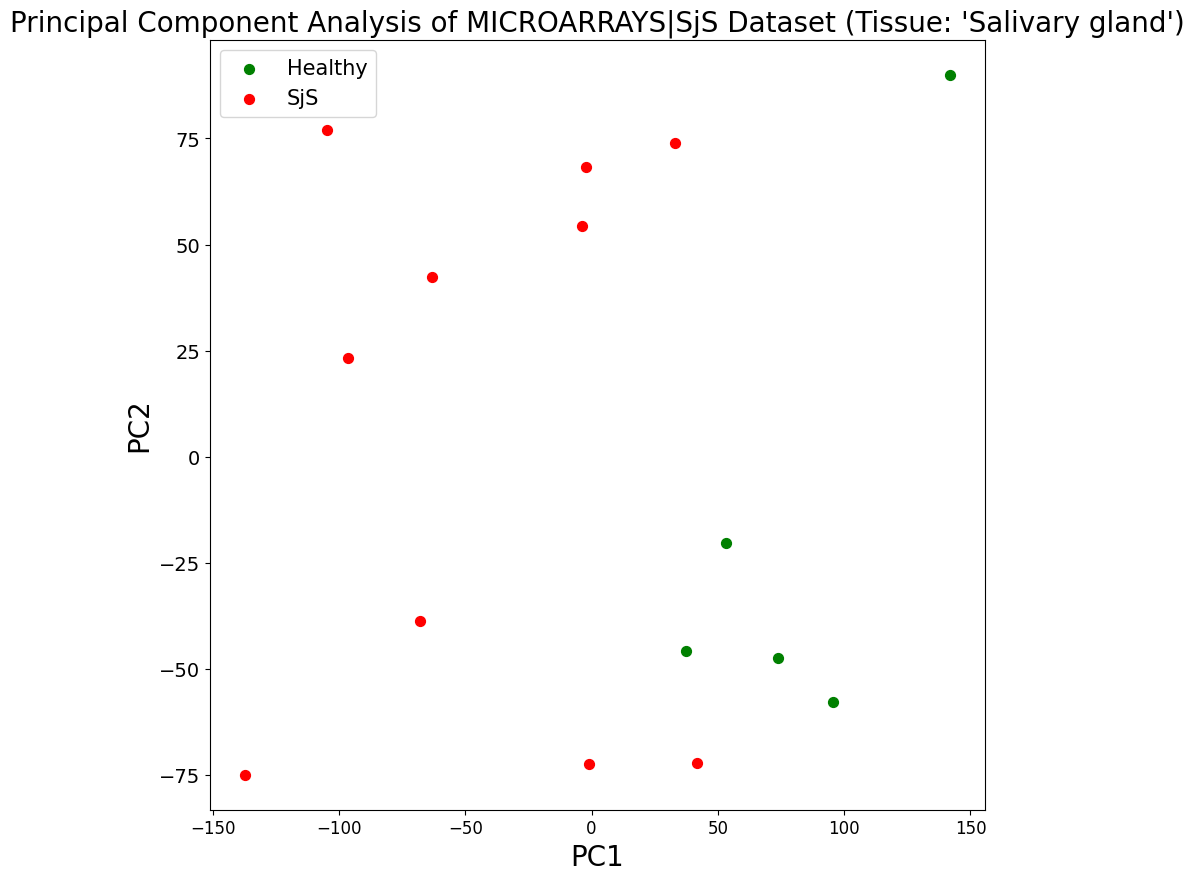

<Figure size 640x480 with 0 Axes>

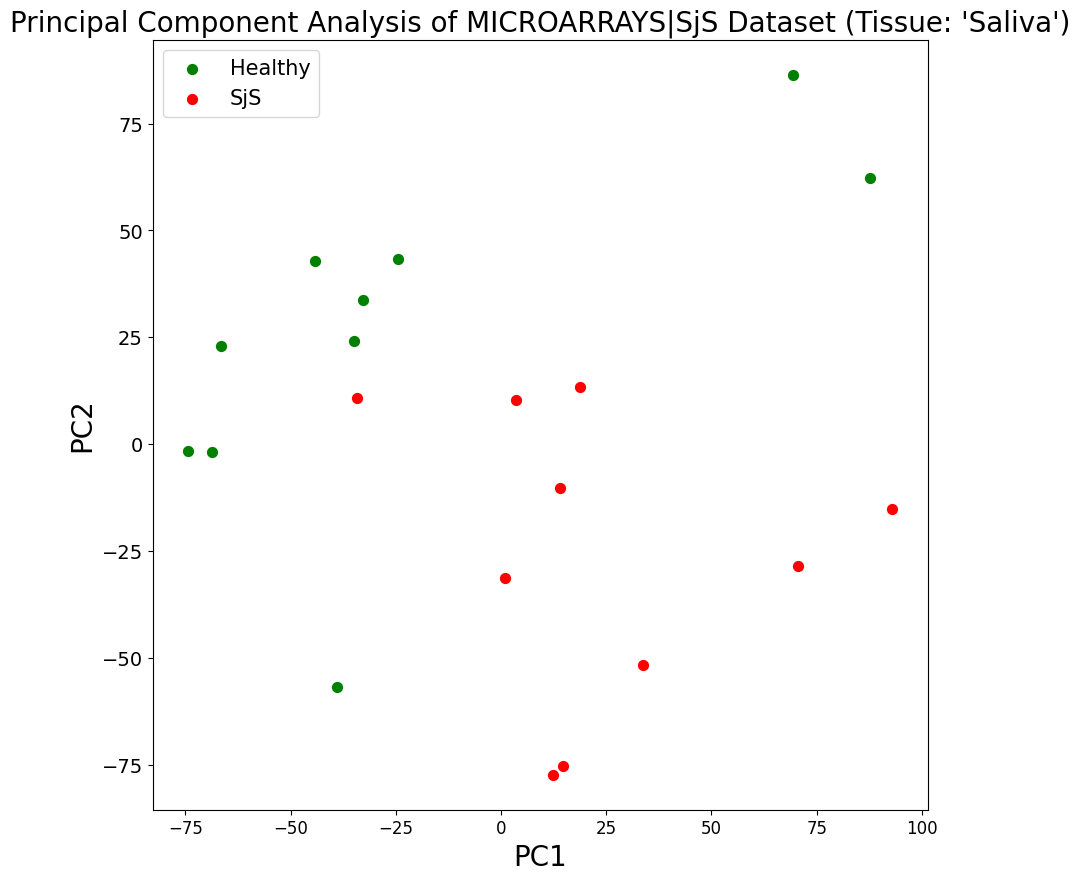

<Figure size 640x480 with 0 Axes>

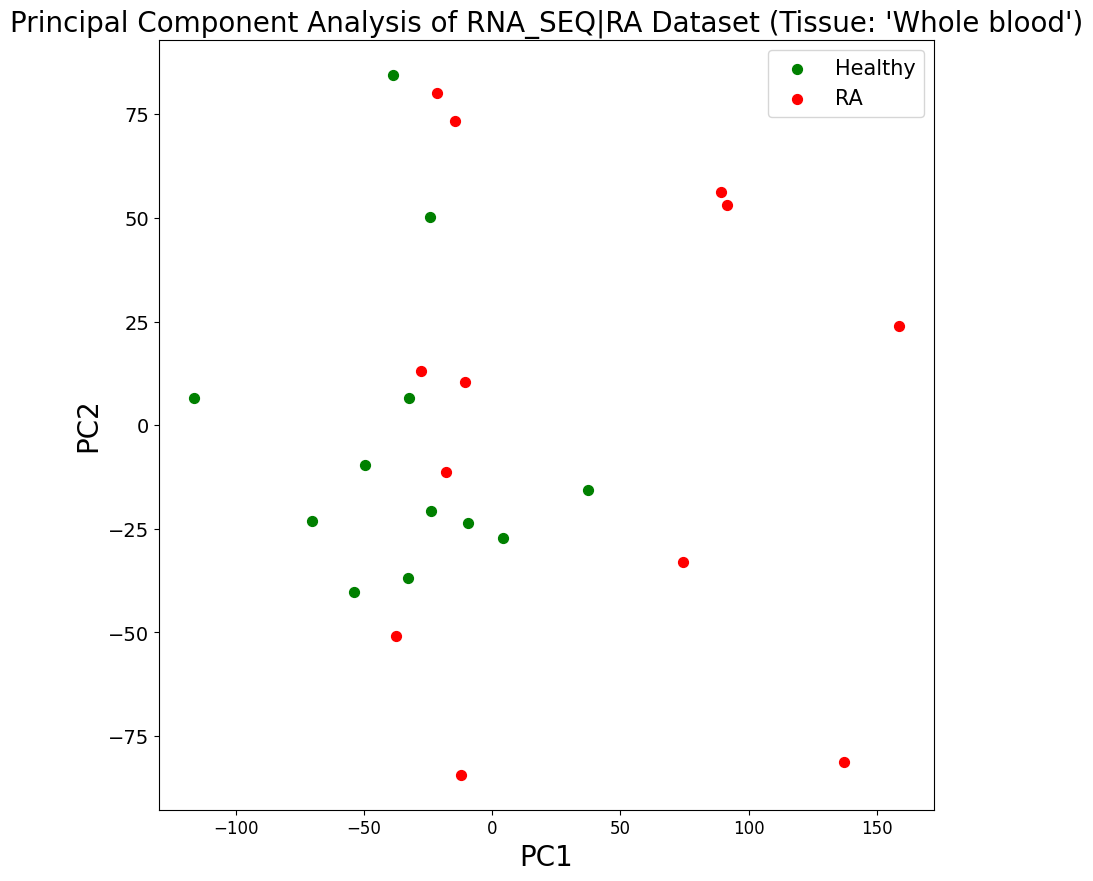

<Figure size 640x480 with 0 Axes>

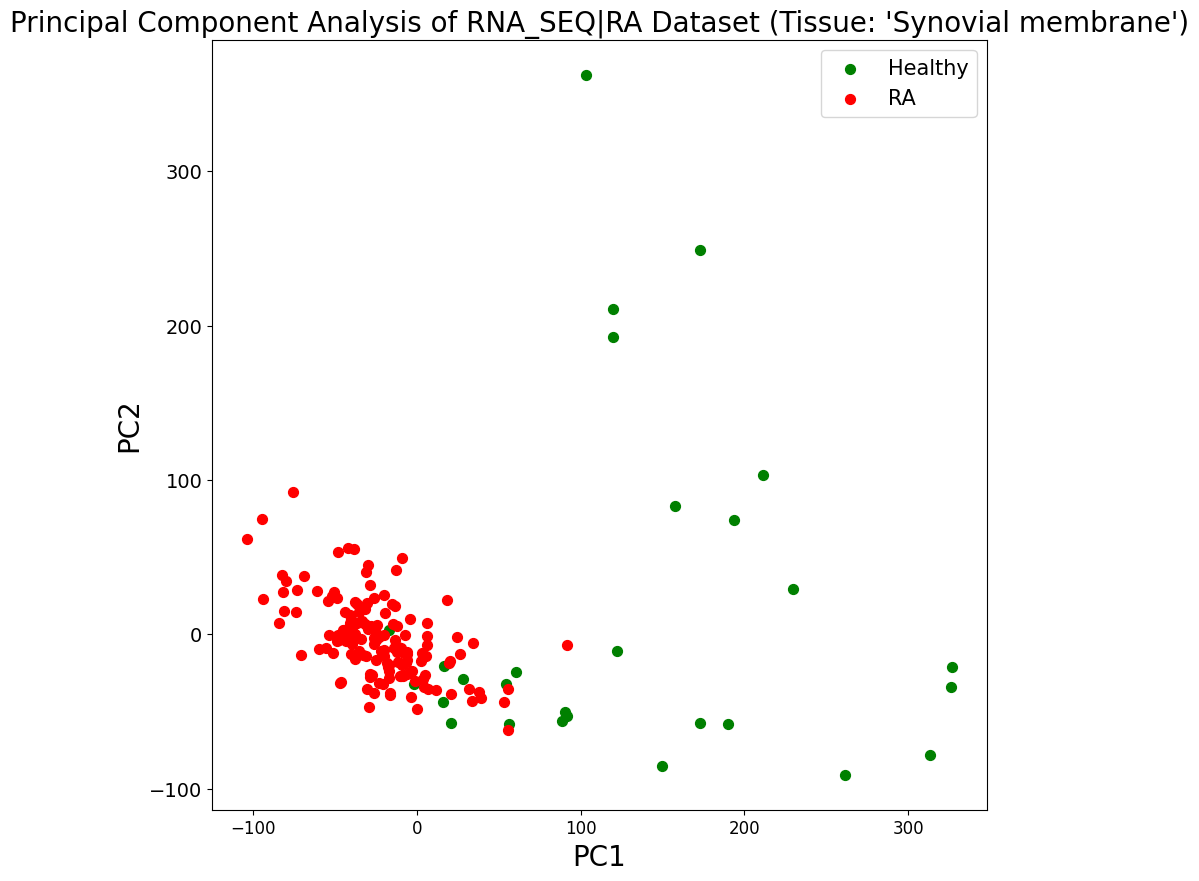

<Figure size 640x480 with 0 Axes>

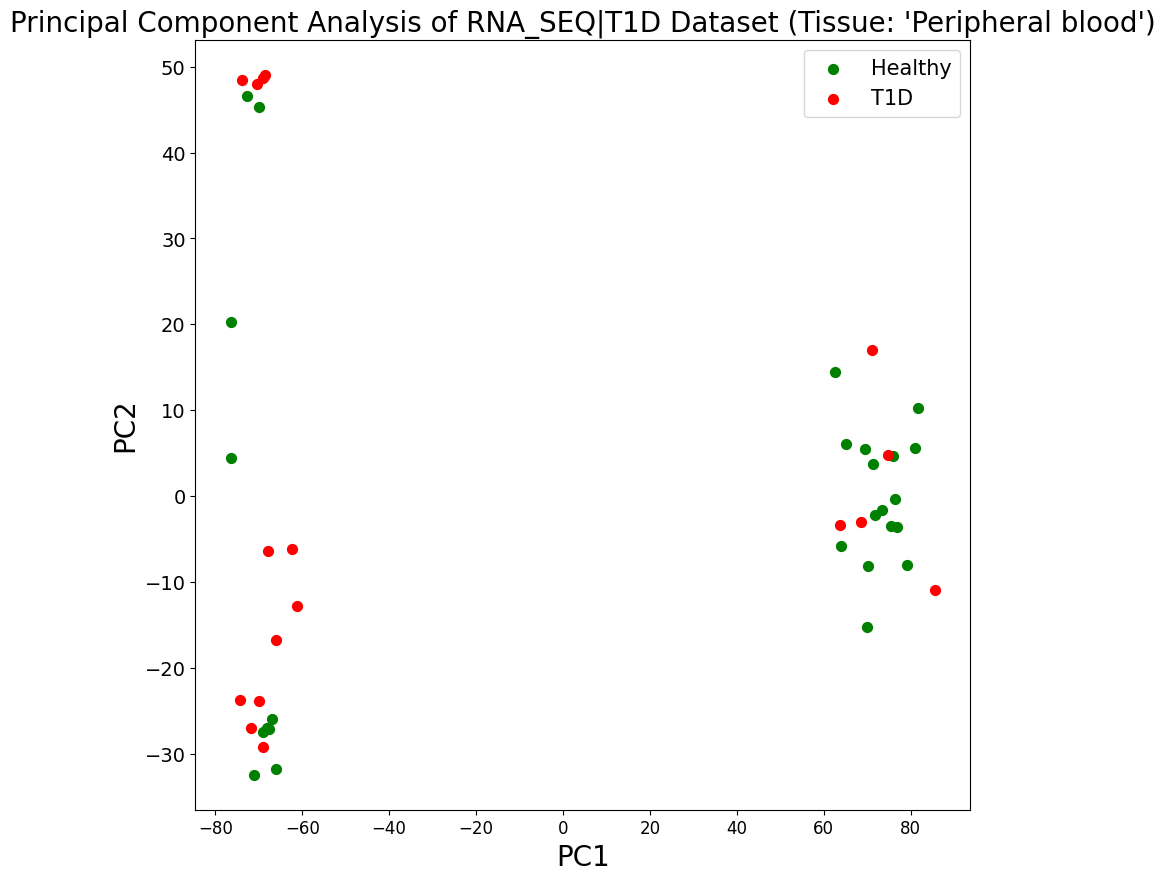

<Figure size 640x480 with 0 Axes>

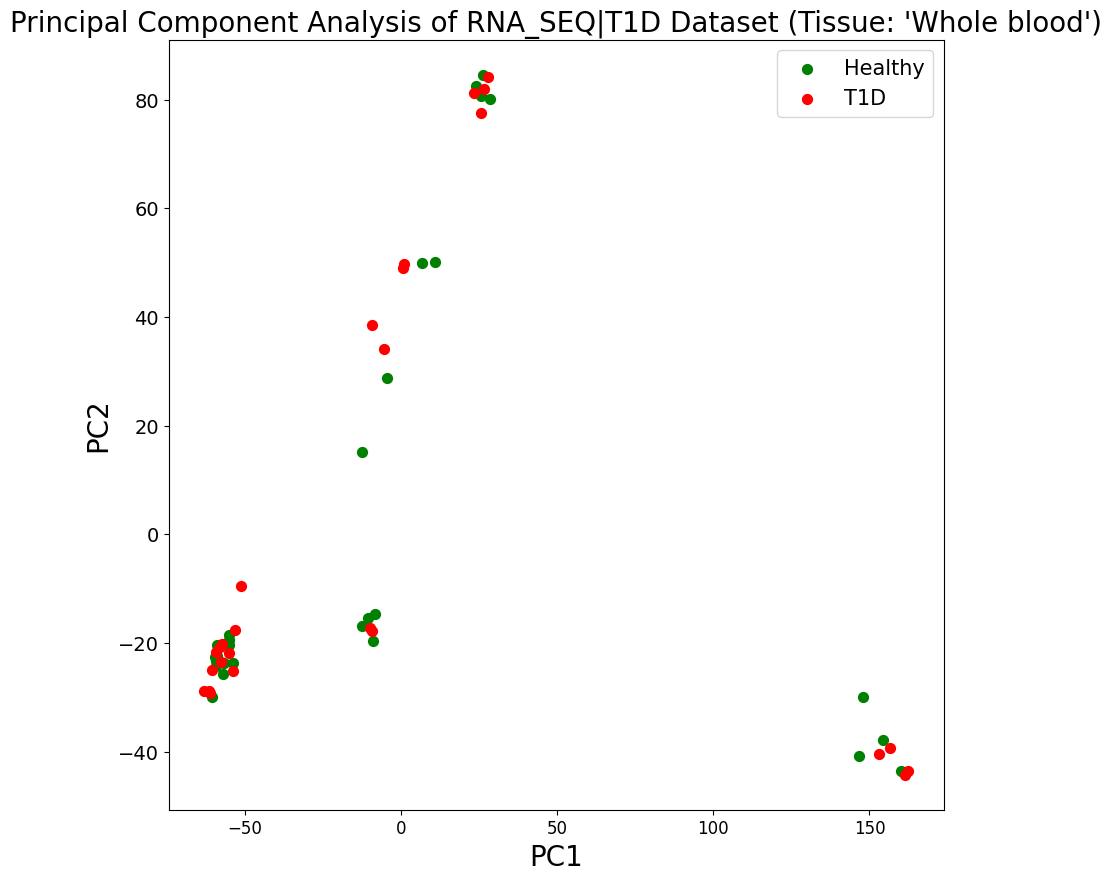

<Figure size 640x480 with 0 Axes>

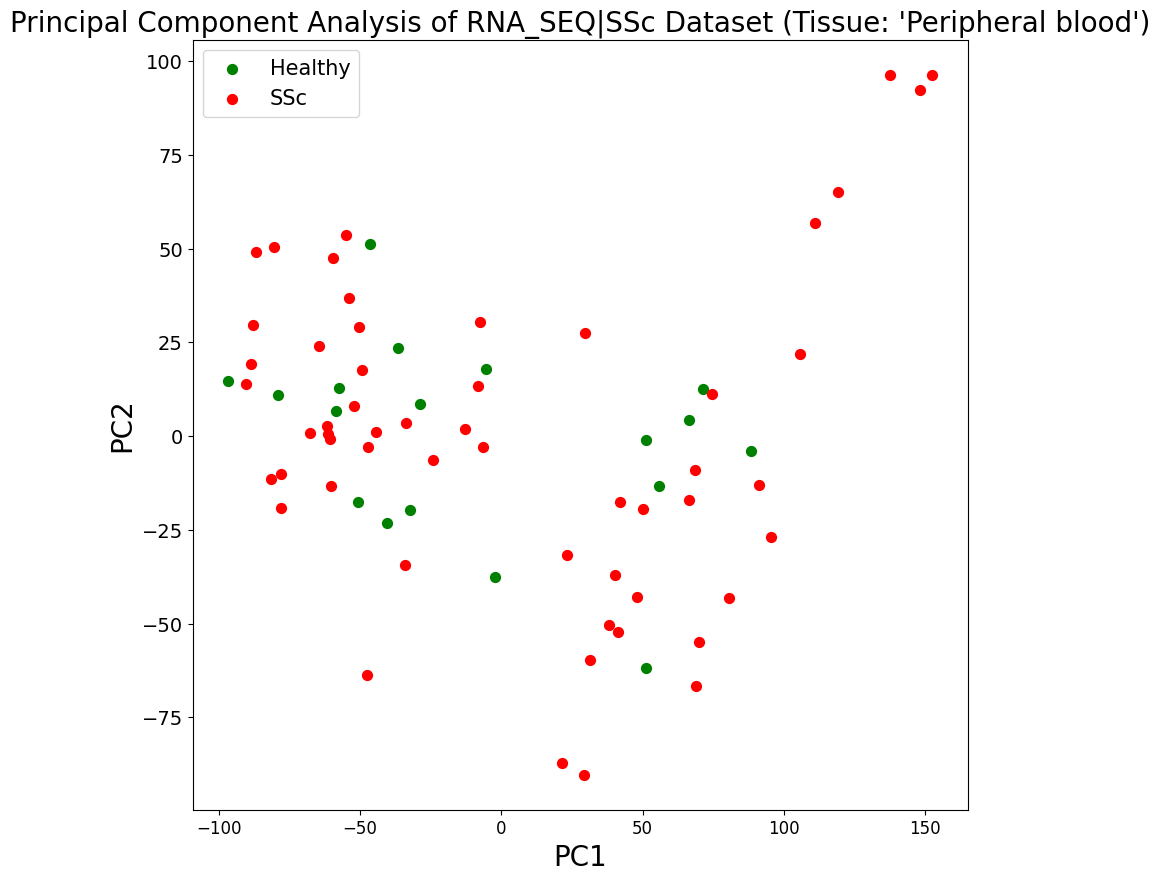

<Figure size 640x480 with 0 Axes>

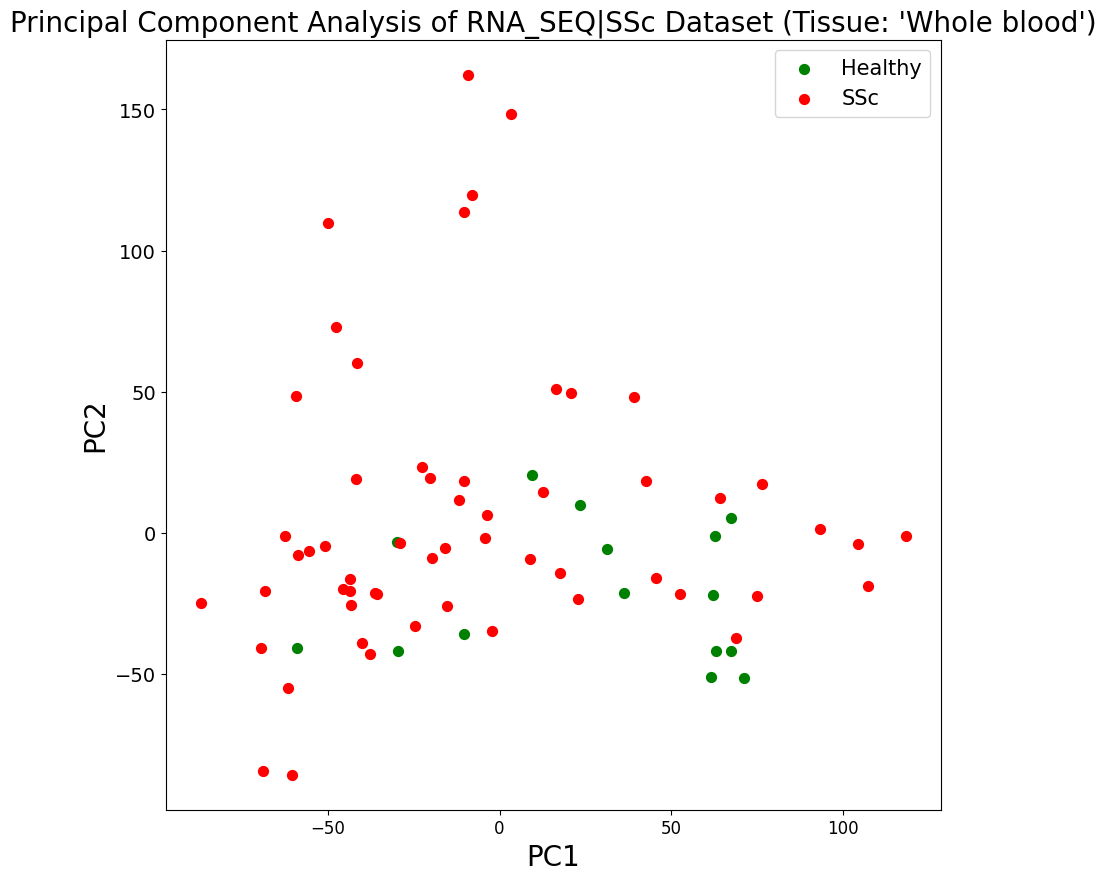

<Figure size 640x480 with 0 Axes>

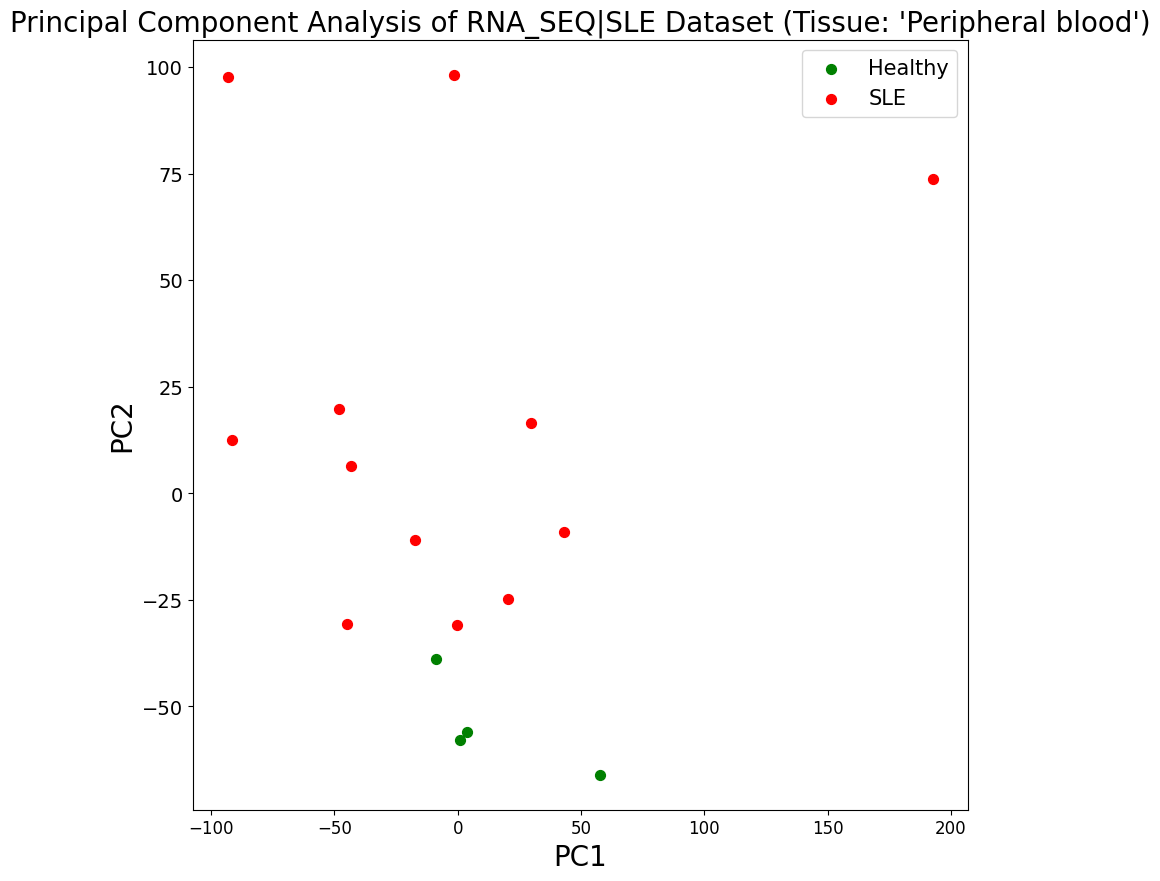

<Figure size 640x480 with 0 Axes>

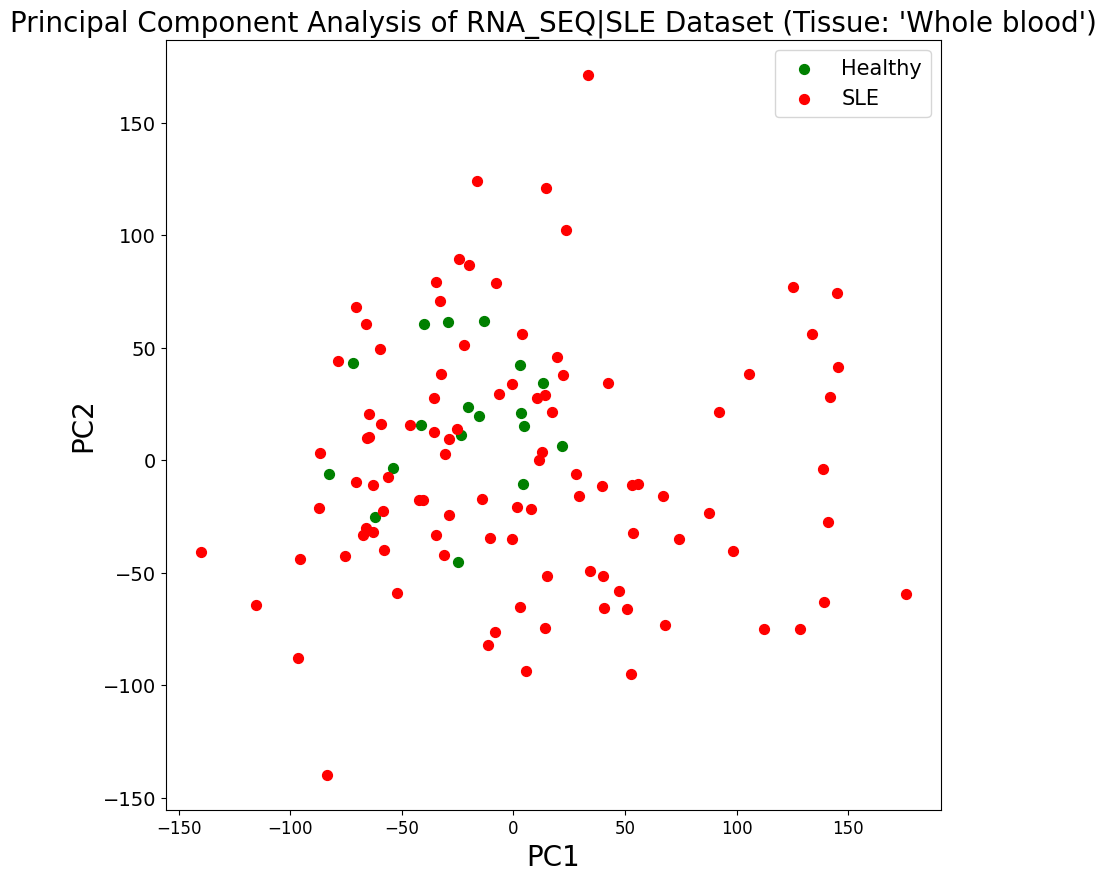

<Figure size 640x480 with 0 Axes>

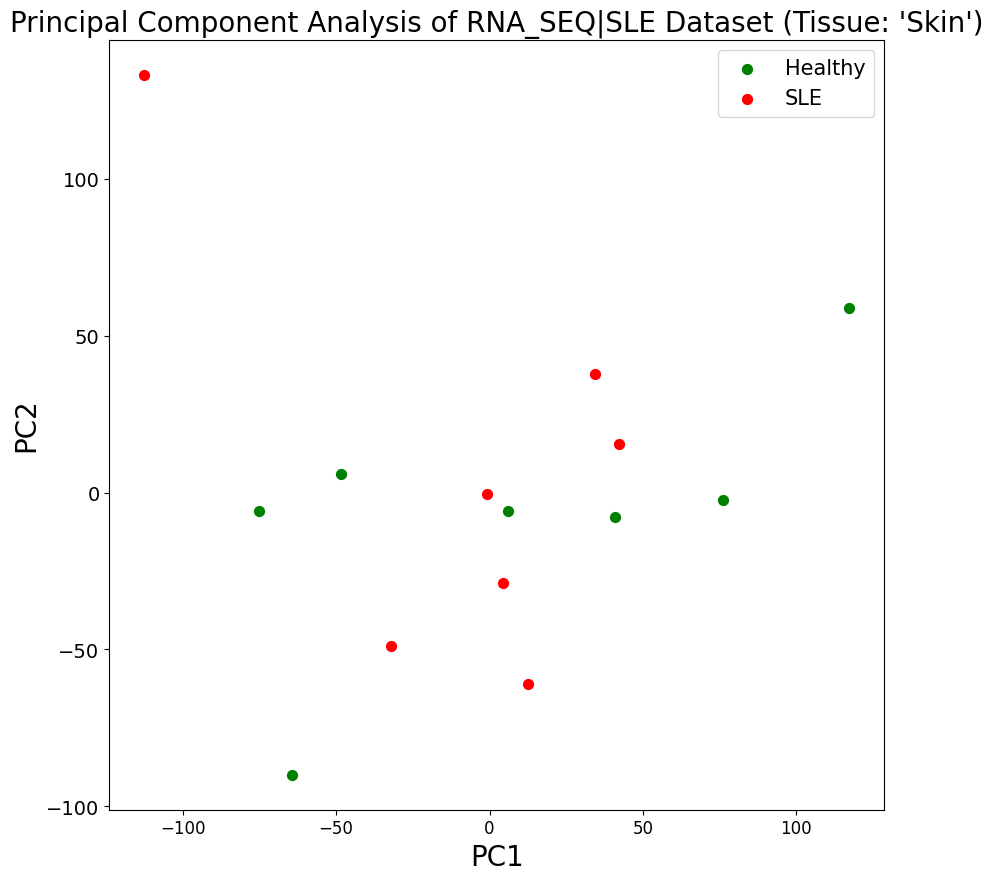

In [2]:
for sequencing_technique in SequencingTechnique:
    for condition in Condition:
        for tissue in TissueEnum:
            pca = PcaHelper(ConditionSequencingTissueDataLoader(condition, sequencing_technique, tissue), files_path, metadata_path, datasets_info_path)
            pca.draw(
                column_that_defines_colors="Condition",
                target_colors=[
                    ("Healthy", "g"),
                    (condition.name, "r")
                ]
            )

# PCA per file (exhaustive)

INFO : Processing file: GSE90081.tsv.parquet
INFO : --- Running PCA for 'RA/GSE90081.tsv.parquet'---
INFO : Loaded dataset for PCA with shape: Samples(24), Genes(13647)
INFO : Dataset normalised | Mean: '8.99537137113782e-18' Standard Deviation:'1.0'
INFO : Explained variation per principal component: [0.30326326 0.15732321]
INFO : ----------------------------------------------
INFO : Processing file: GSE38351_RA_GPL96.tsv.parquet
INFO : --- Running PCA for 'RA/GSE38351_RA_GPL96.tsv.parquet'---
INFO : Loaded dataset for PCA with shape: Samples(20), Genes(13906)
INFO : Dataset normalised | Mean: '-2.5183166095815534e-17' Standard Deviation:'1.0'
INFO : Explained variation per principal component: [0.29969746 0.10061195]
INFO : ----------------------------------------------
INFO : Processing file: GSE65010_Naive_effector_T_cells.tsv.parquet
INFO : --- Running PCA for 'RA/GSE65010_Naive_effector_T_cells.tsv.parquet'---
INFO : Loaded dataset for PCA with shape: Samples(12), Genes(10411)
IN

<Figure size 640x480 with 0 Axes>

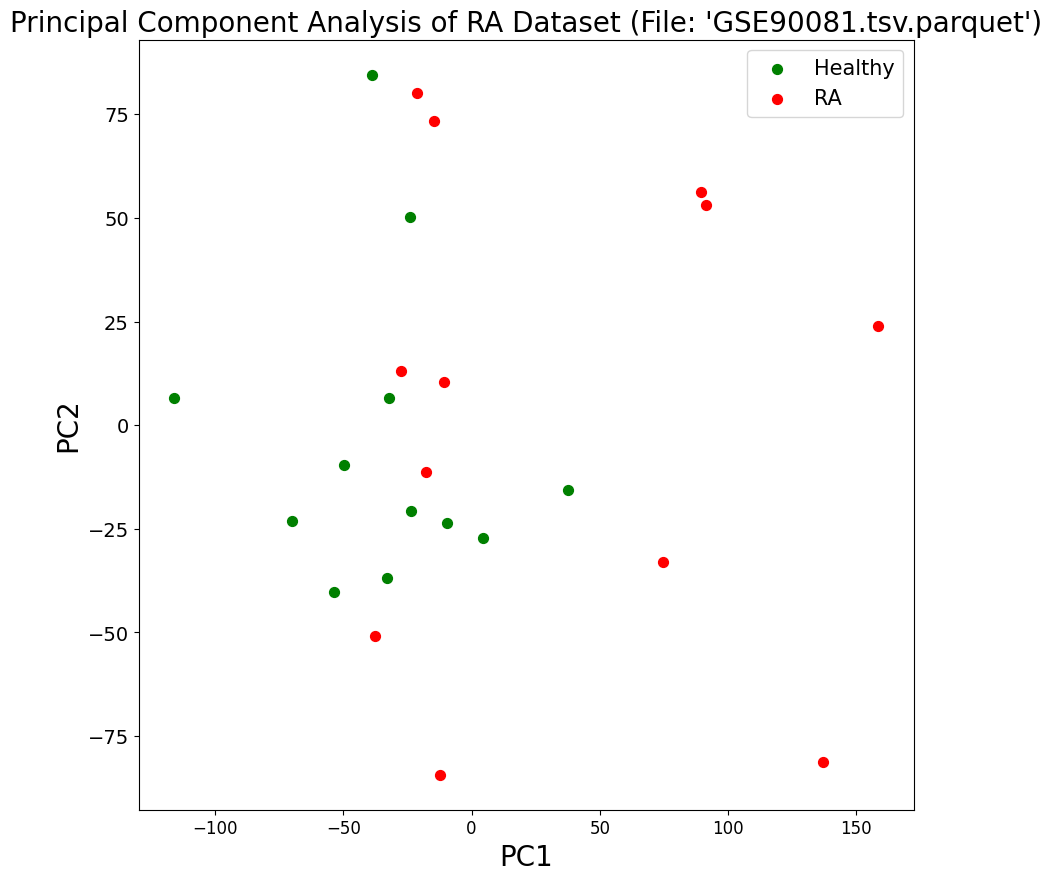

<Figure size 640x480 with 0 Axes>

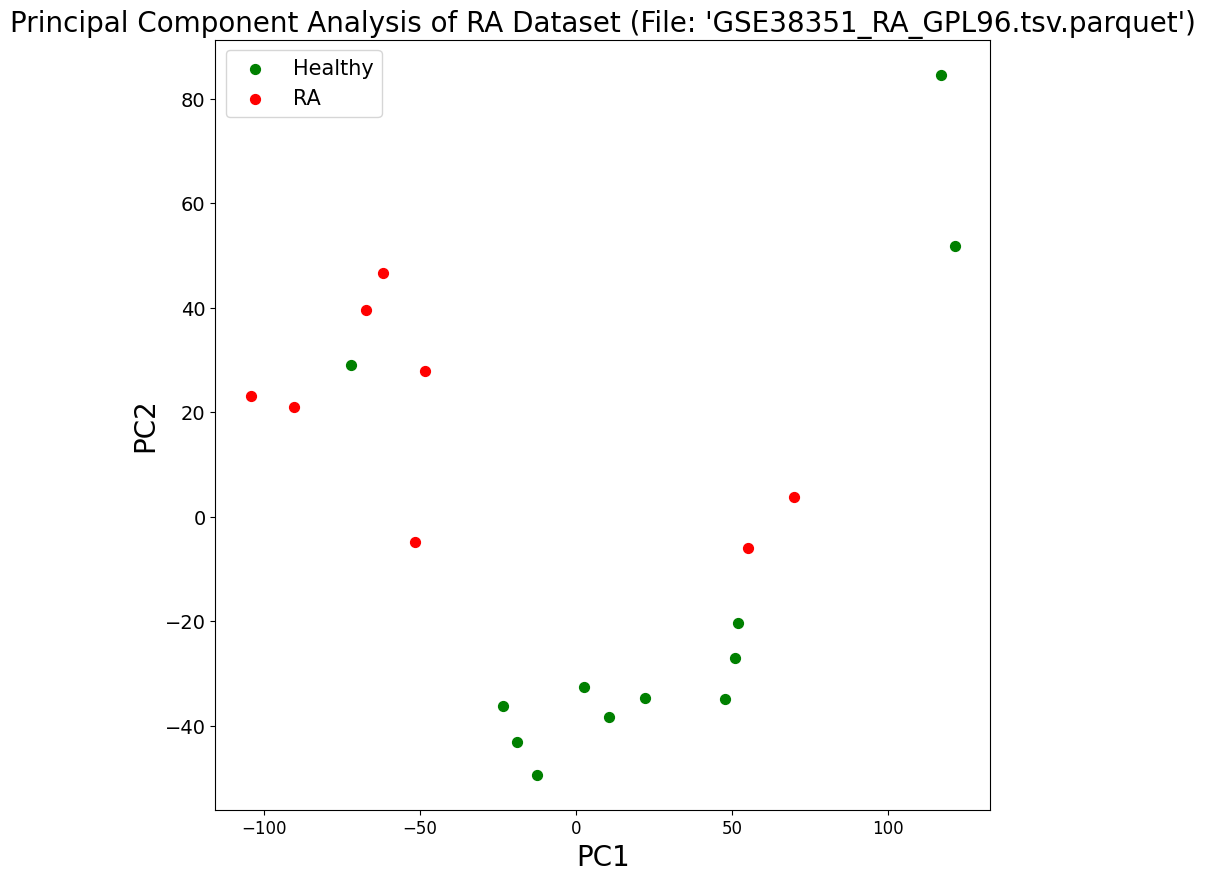

<Figure size 640x480 with 0 Axes>

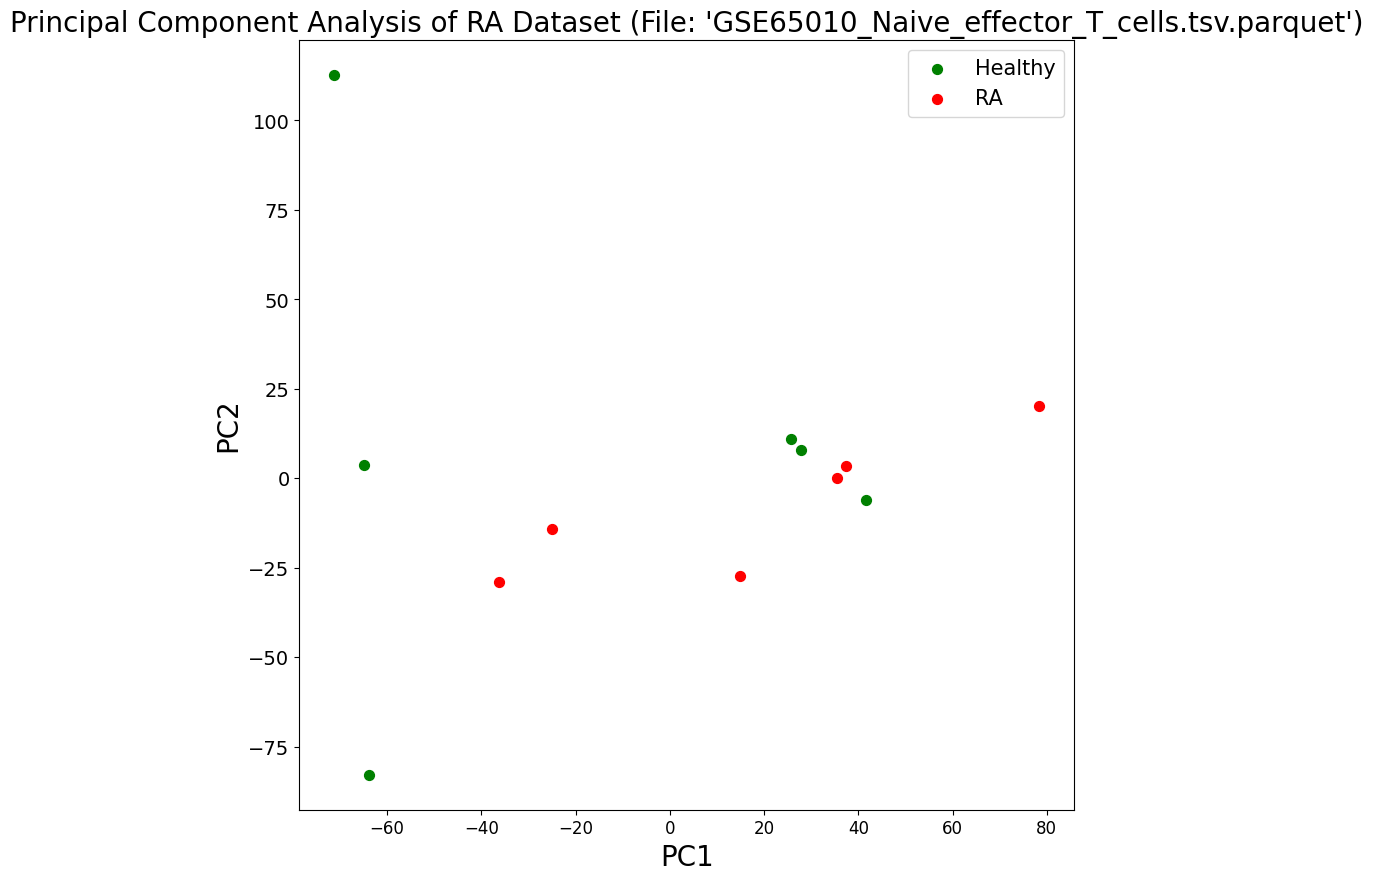

<Figure size 640x480 with 0 Axes>

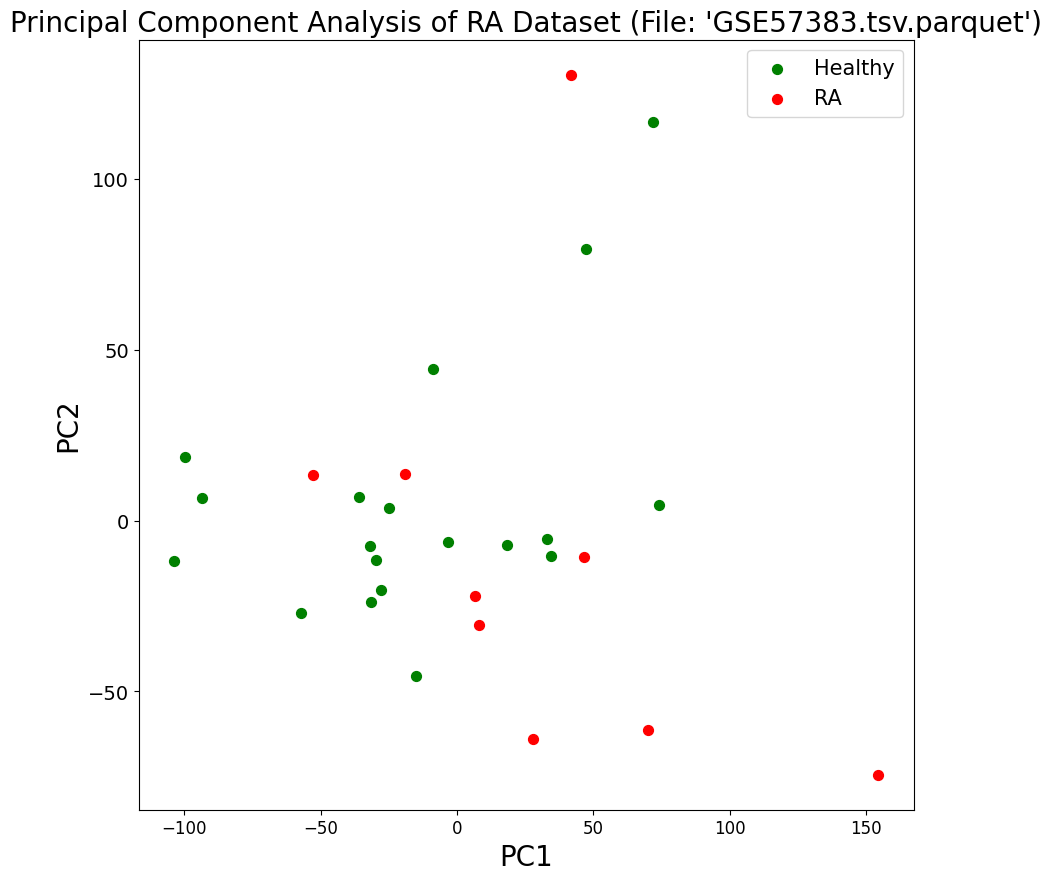

<Figure size 640x480 with 0 Axes>

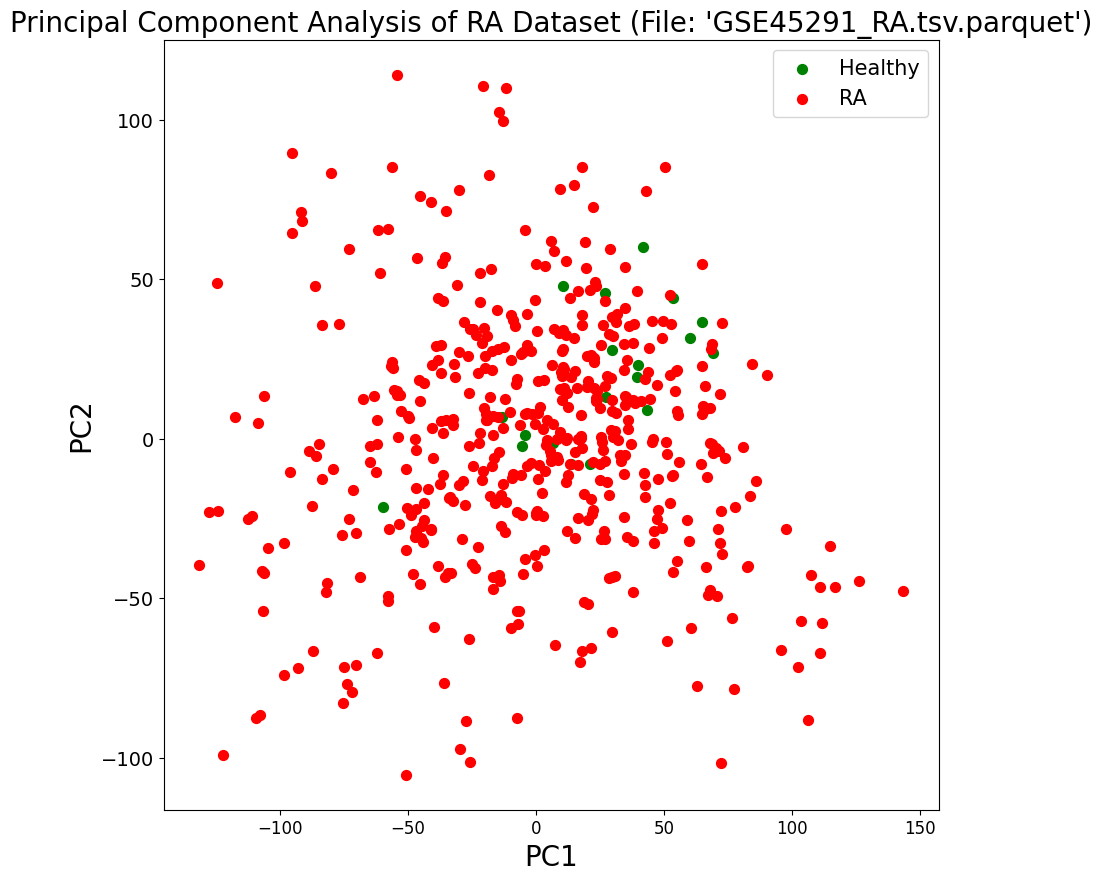

<Figure size 640x480 with 0 Axes>

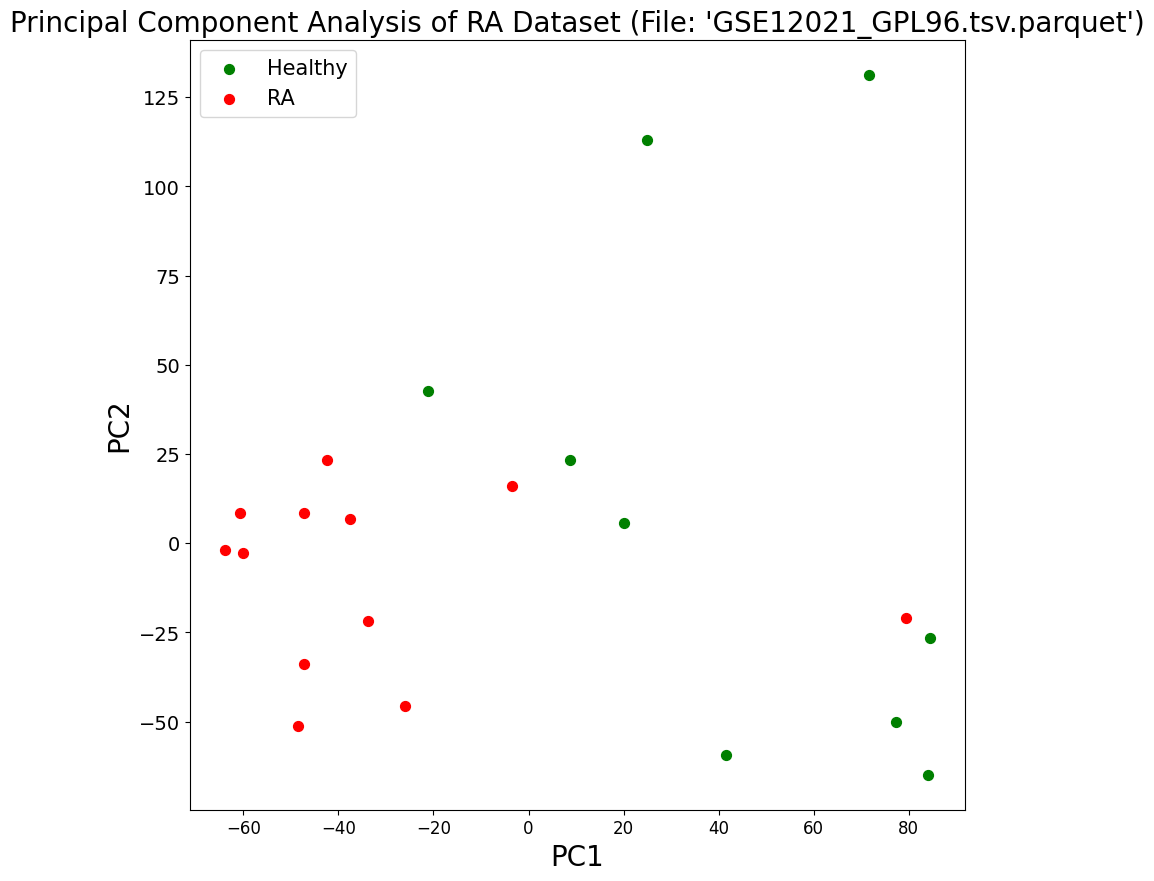

<Figure size 640x480 with 0 Axes>

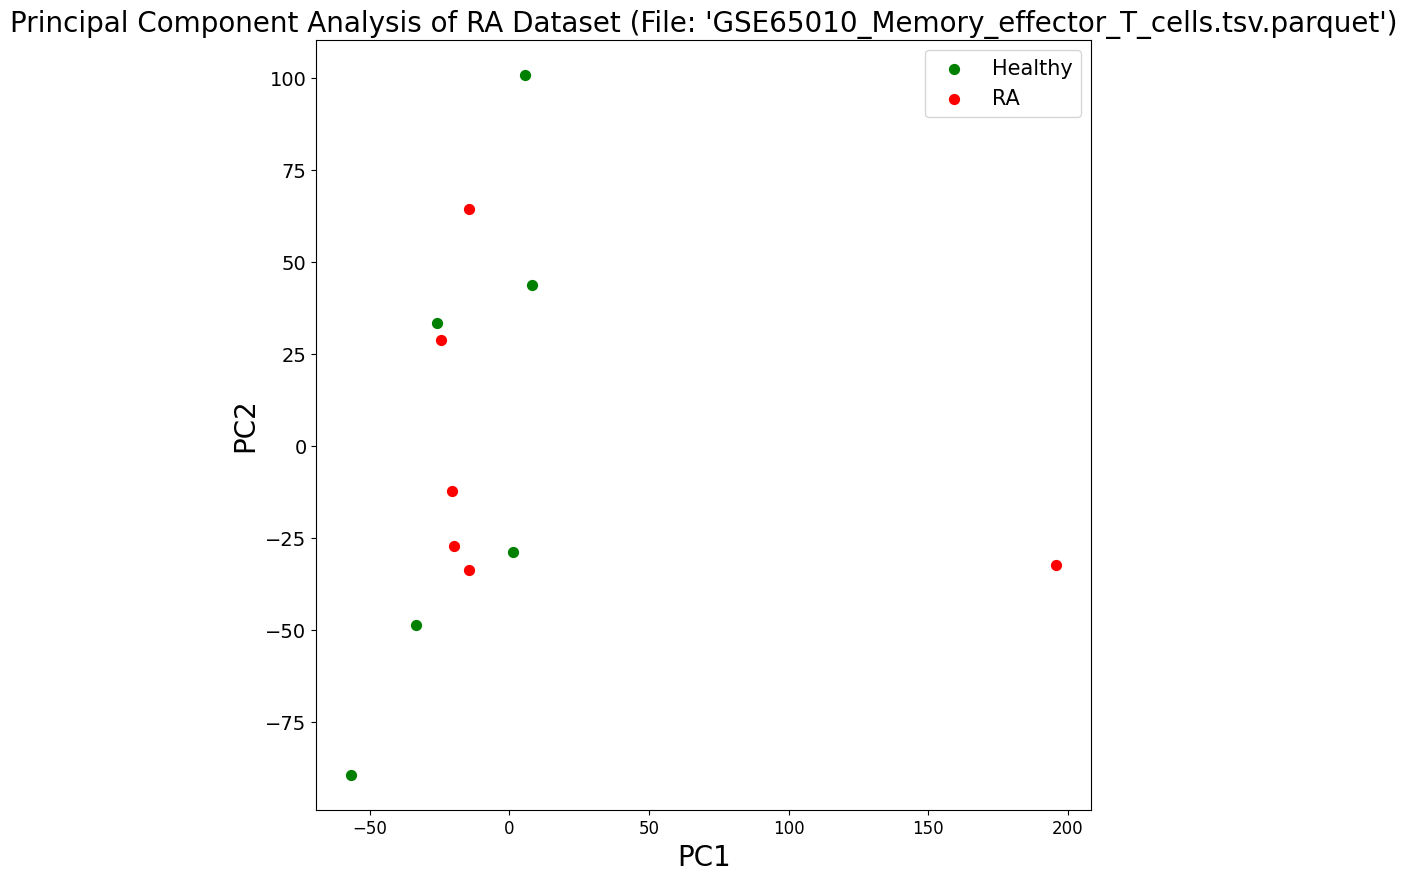

<Figure size 640x480 with 0 Axes>

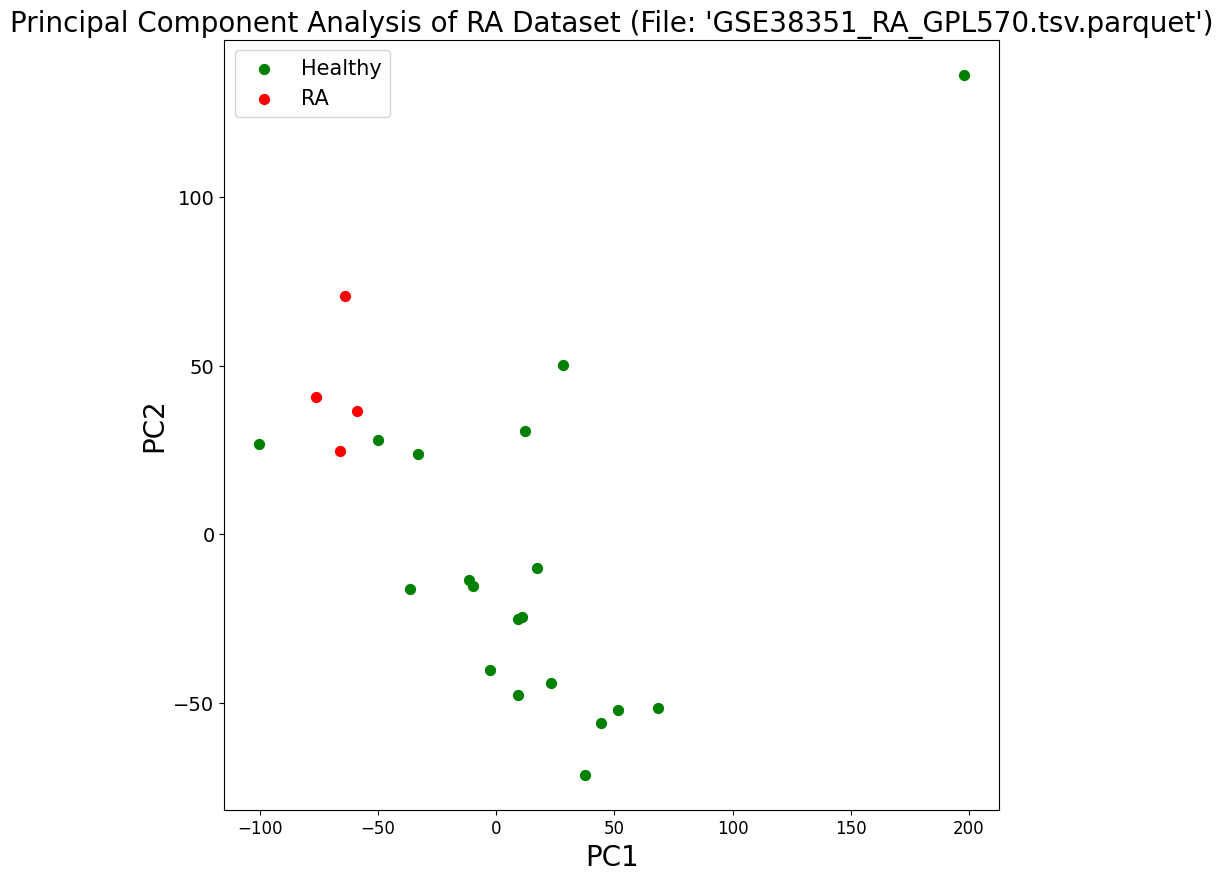

<Figure size 640x480 with 0 Axes>

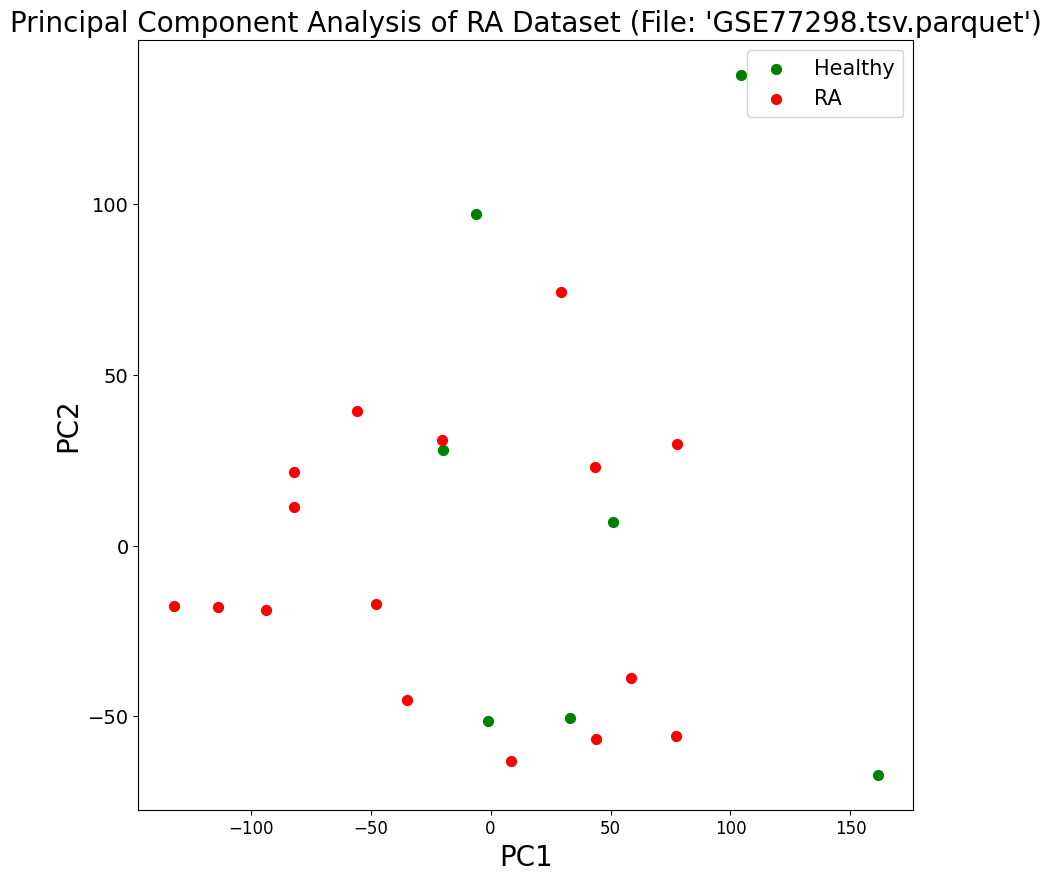

<Figure size 640x480 with 0 Axes>

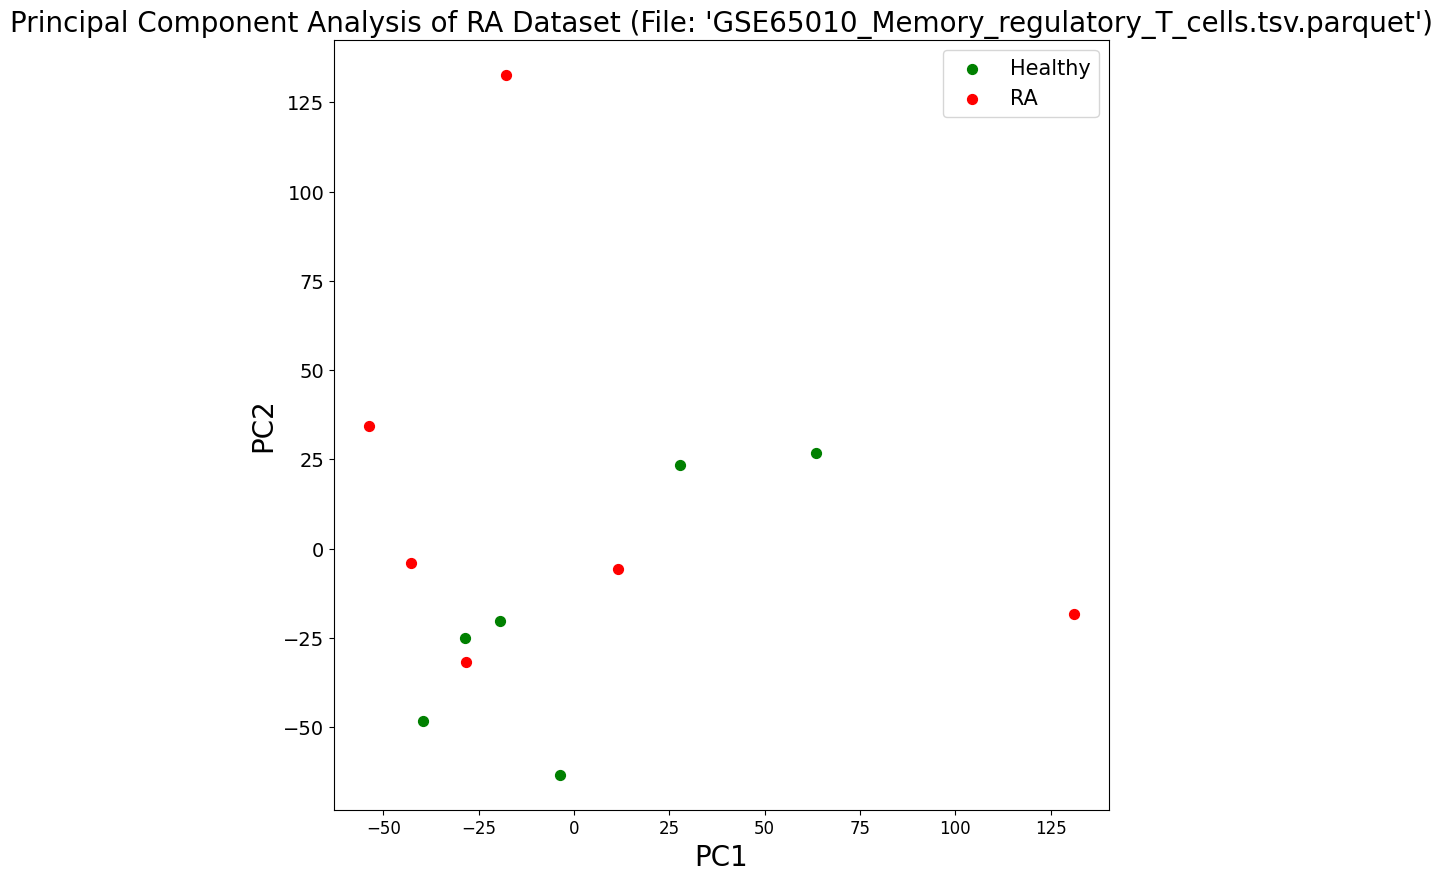

<Figure size 640x480 with 0 Axes>

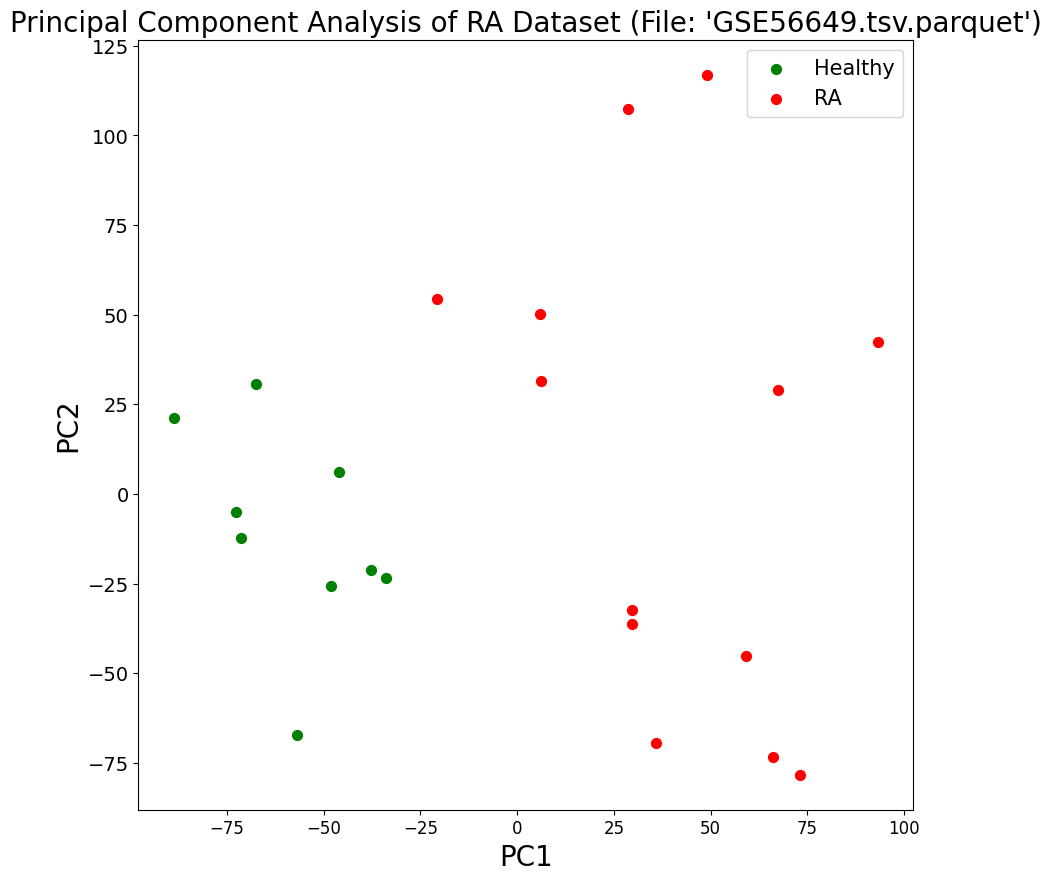

<Figure size 640x480 with 0 Axes>

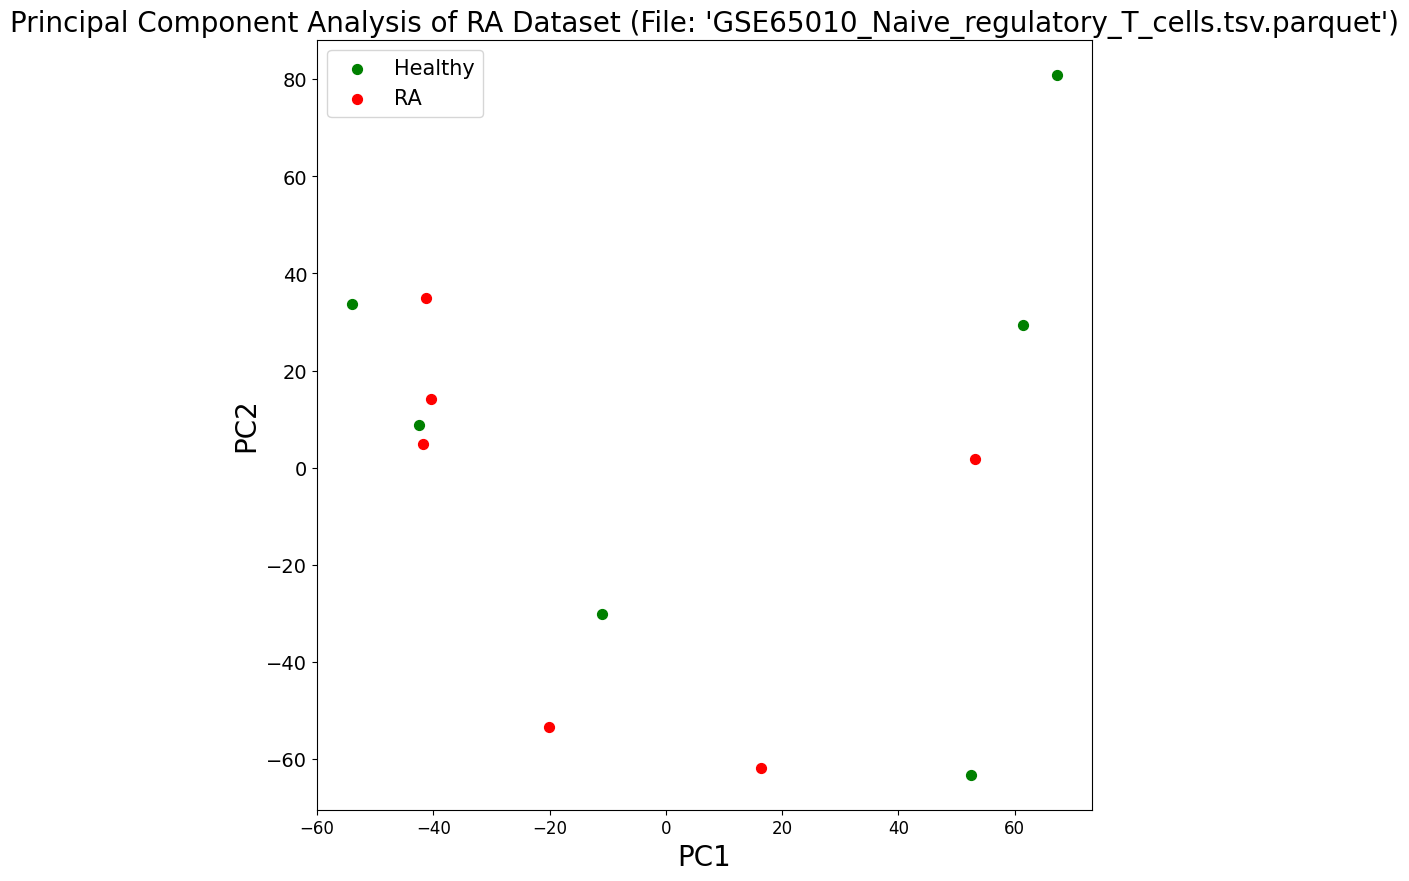

<Figure size 640x480 with 0 Axes>

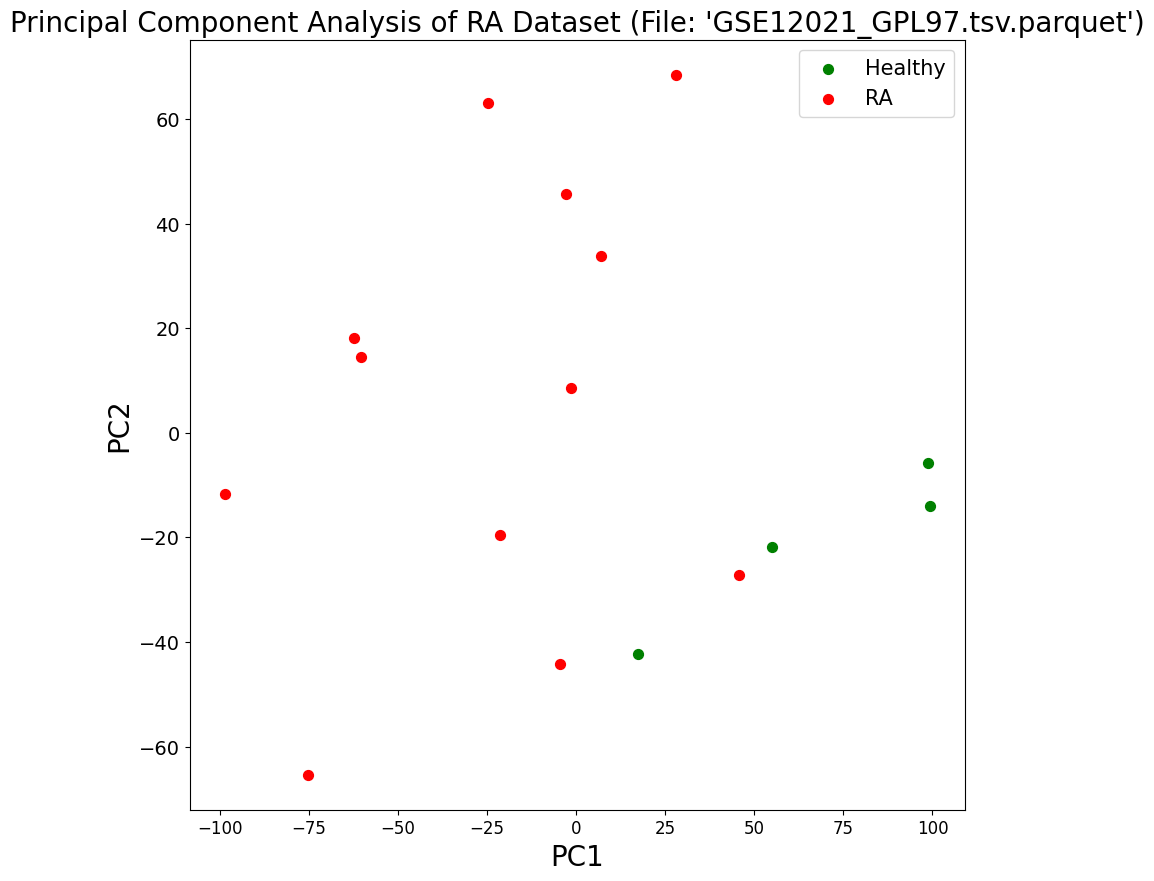

<Figure size 640x480 with 0 Axes>

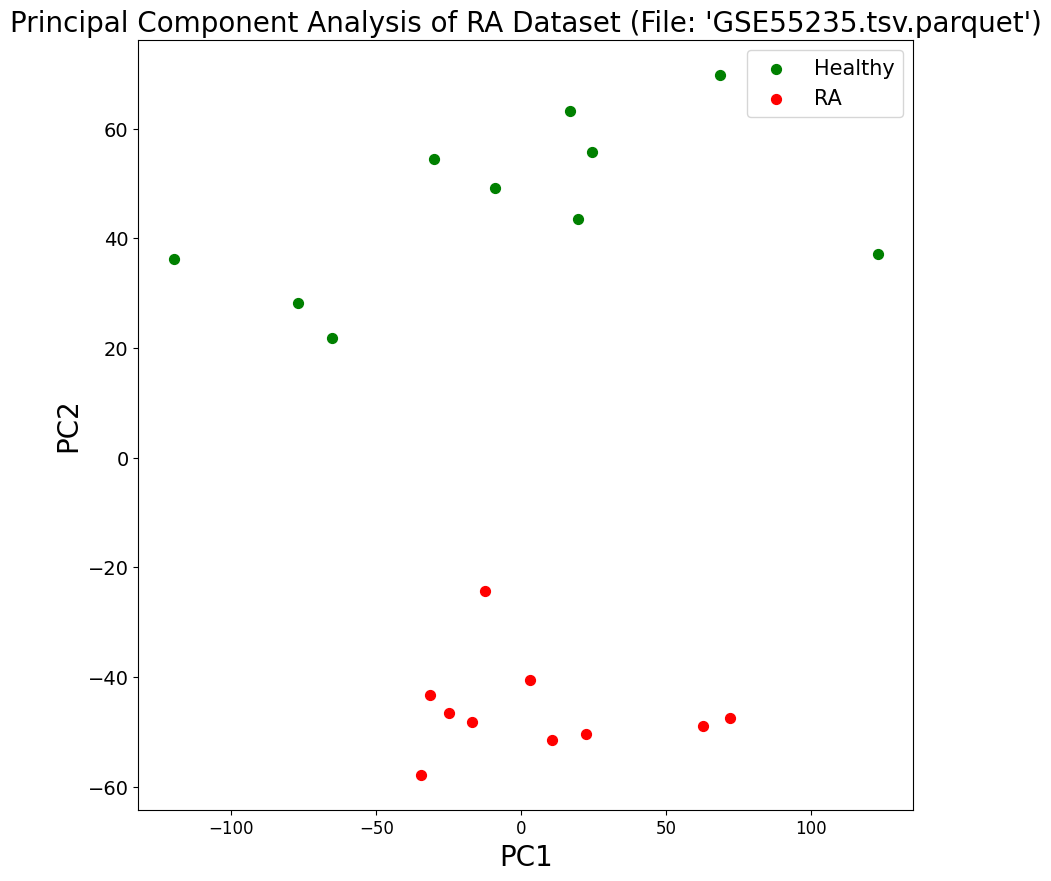

<Figure size 640x480 with 0 Axes>

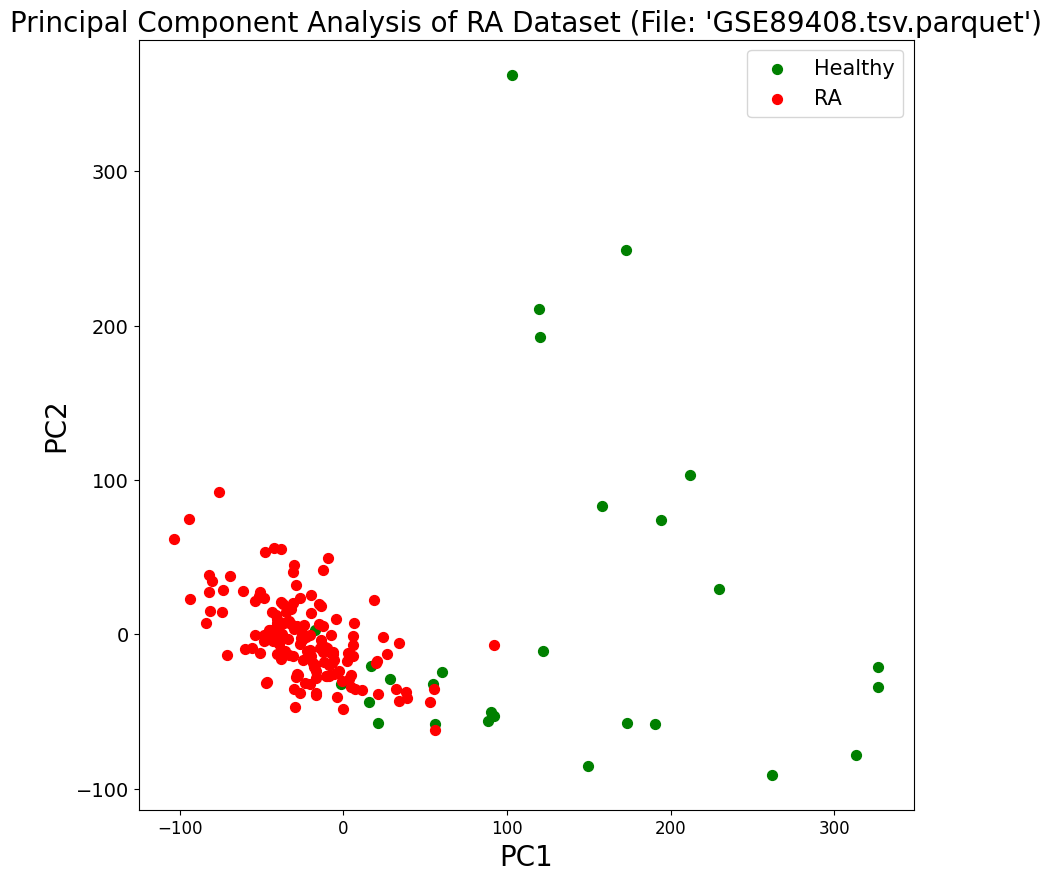

<Figure size 640x480 with 0 Axes>

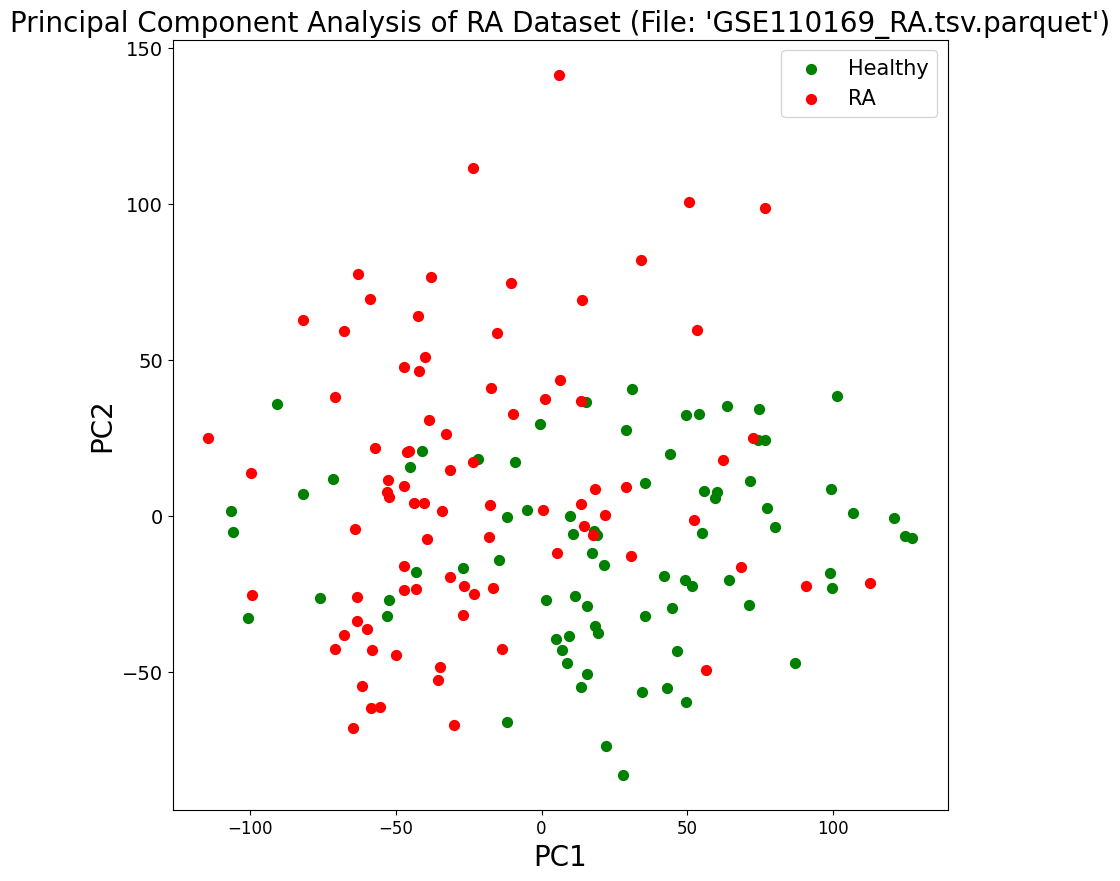

<Figure size 640x480 with 0 Axes>

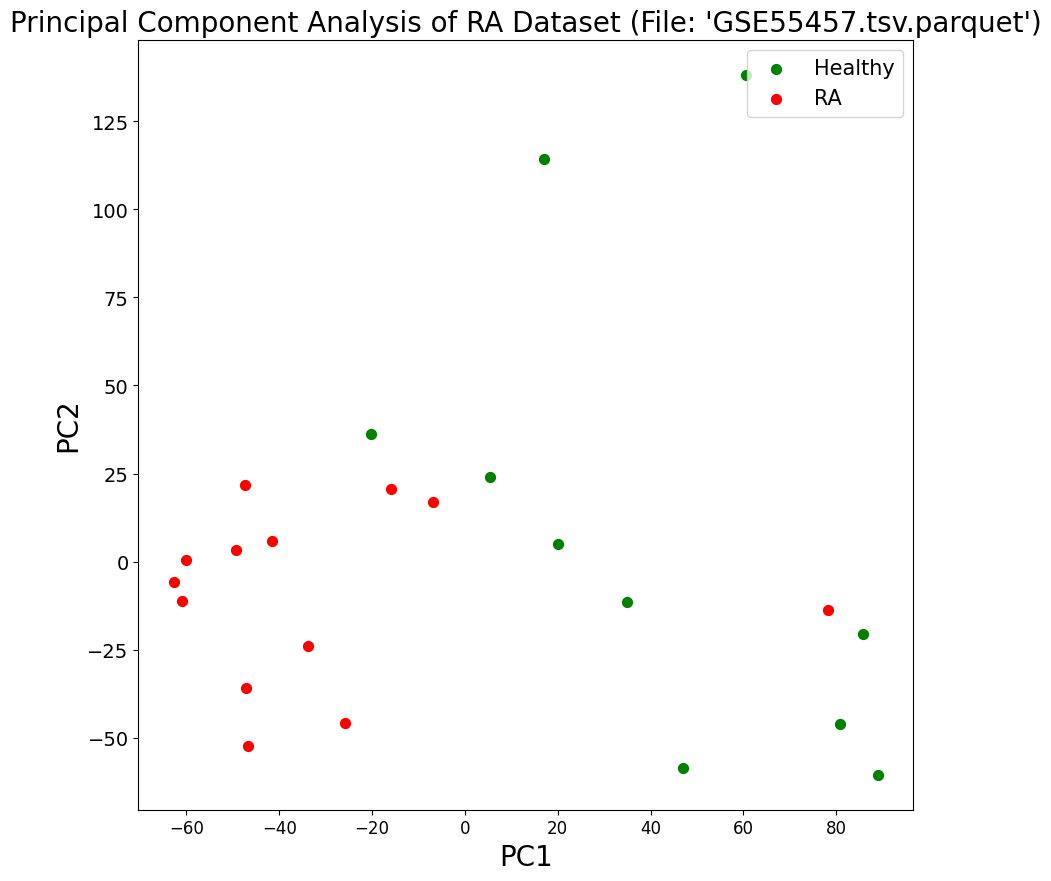

<Figure size 640x480 with 0 Axes>

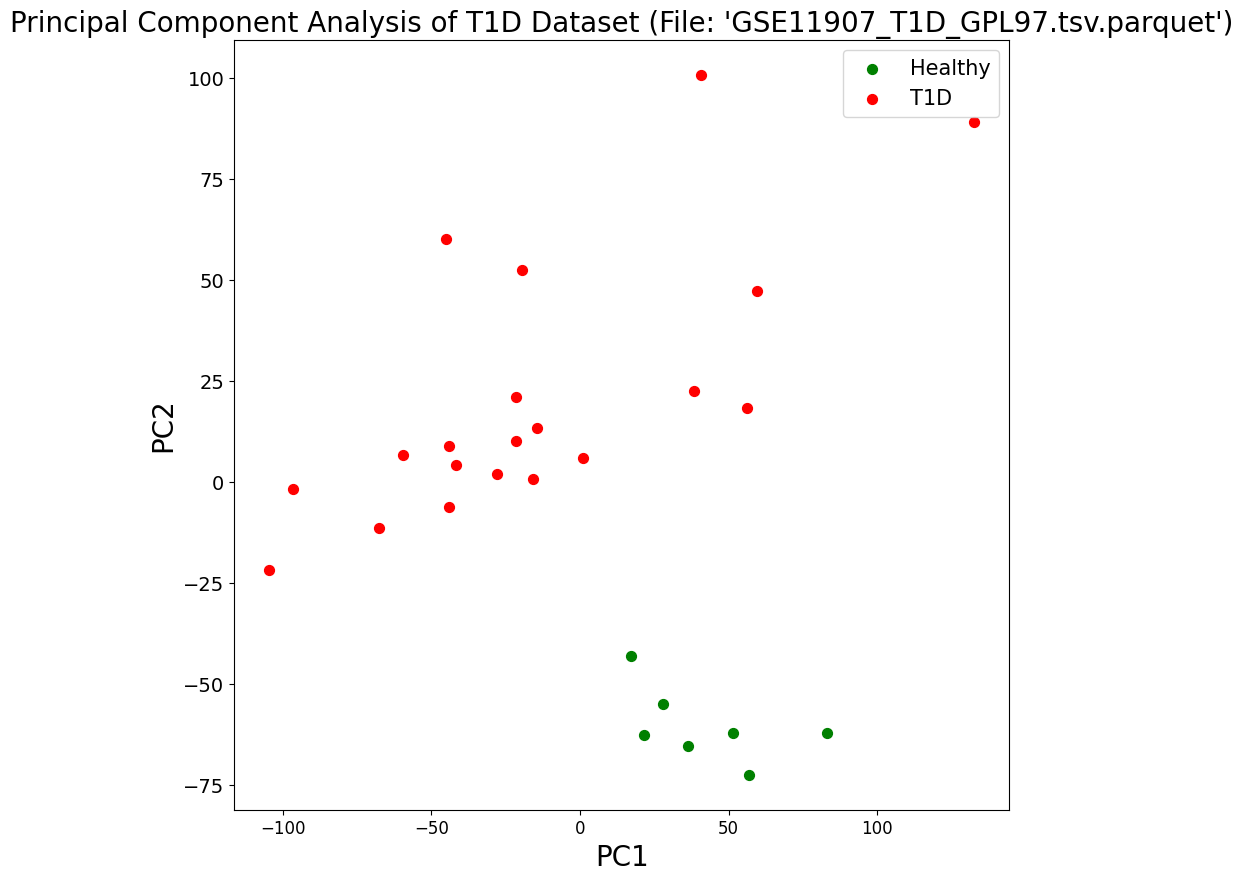

<Figure size 640x480 with 0 Axes>

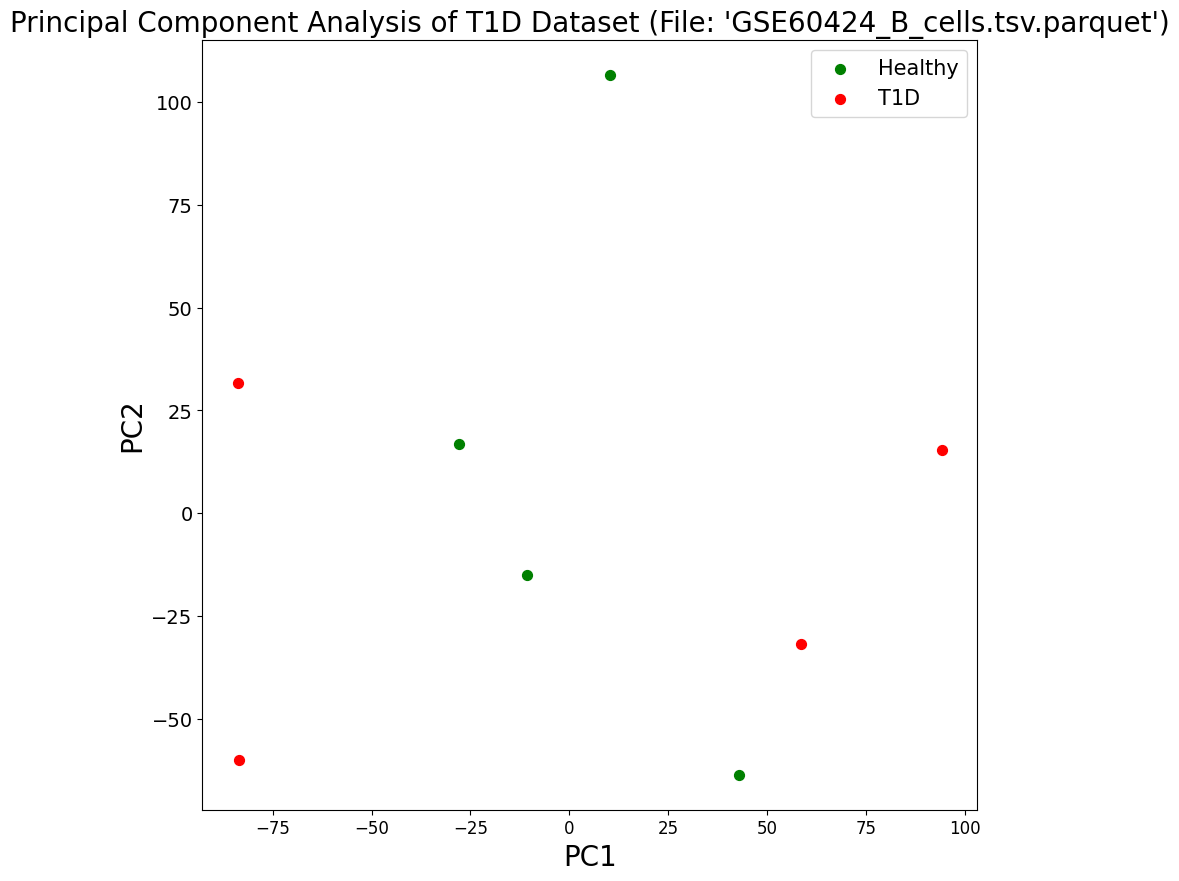

<Figure size 640x480 with 0 Axes>

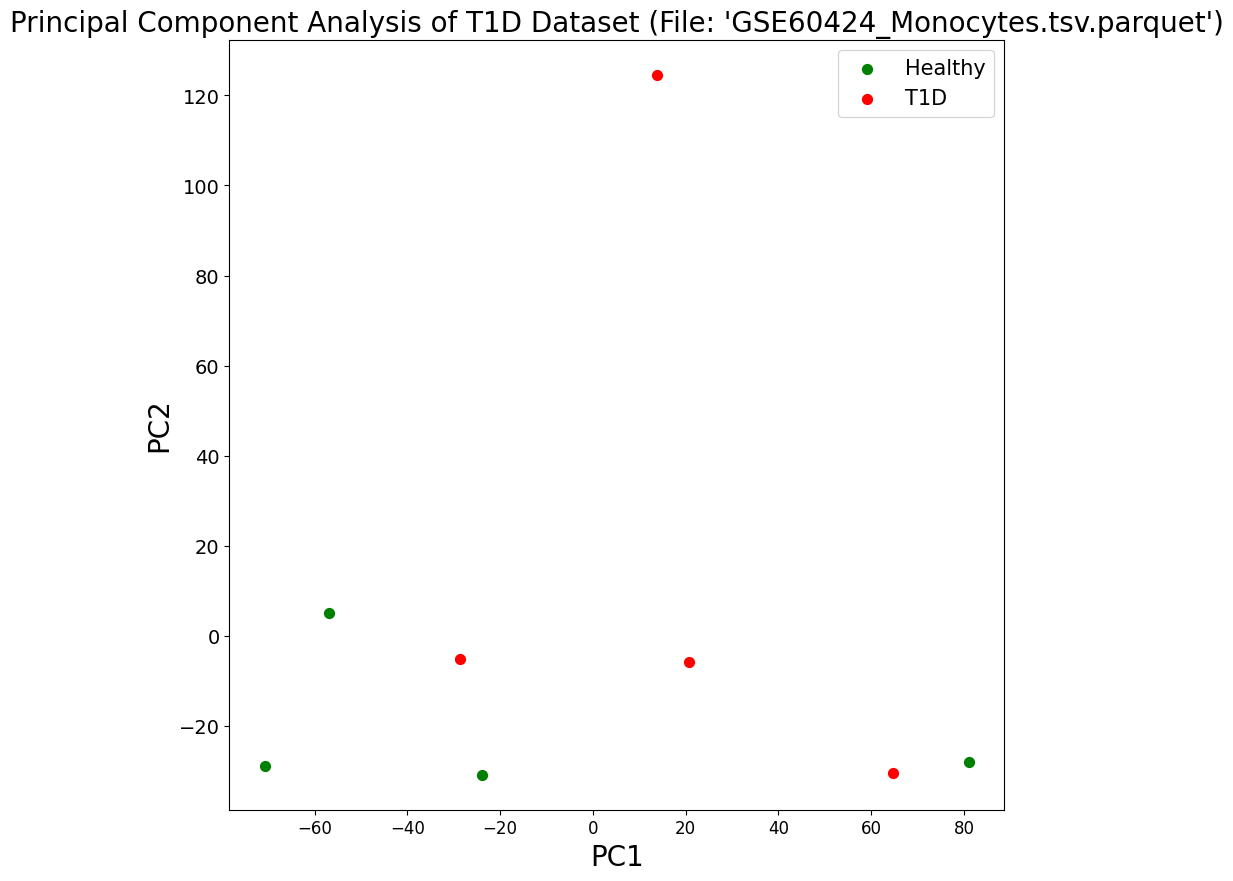

<Figure size 640x480 with 0 Axes>

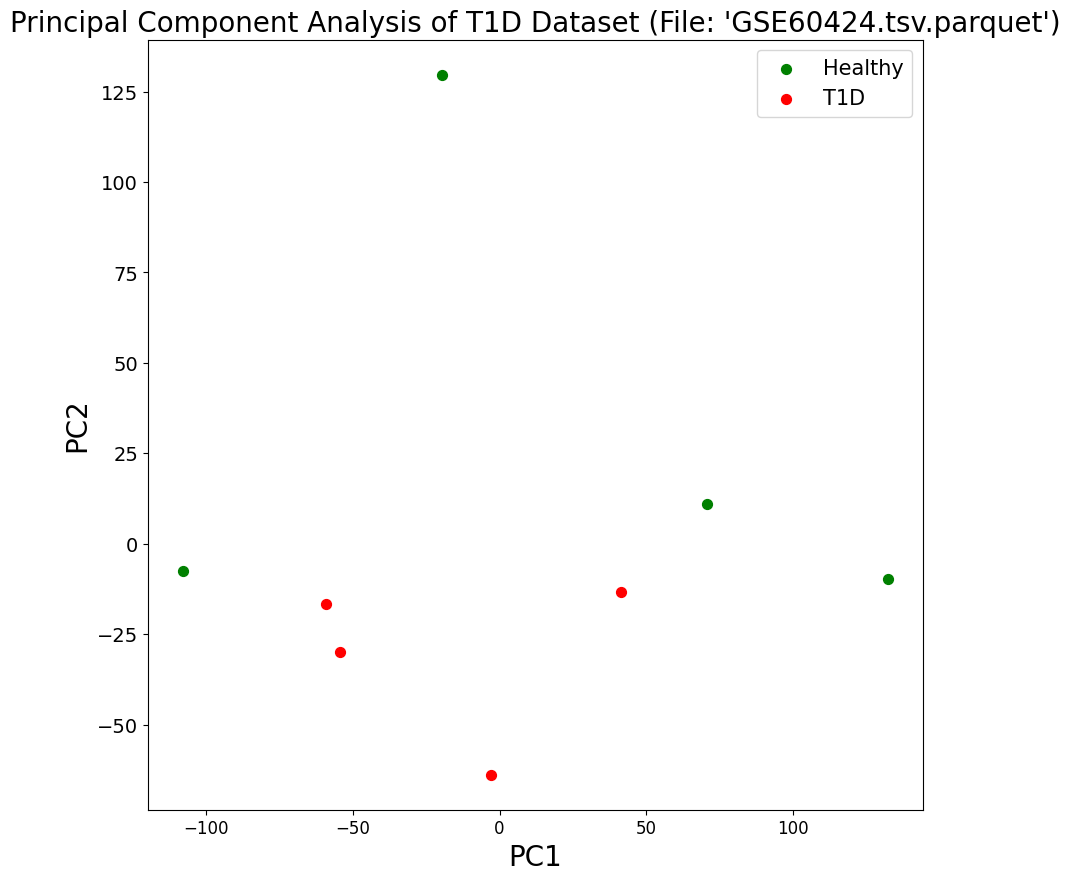

<Figure size 640x480 with 0 Axes>

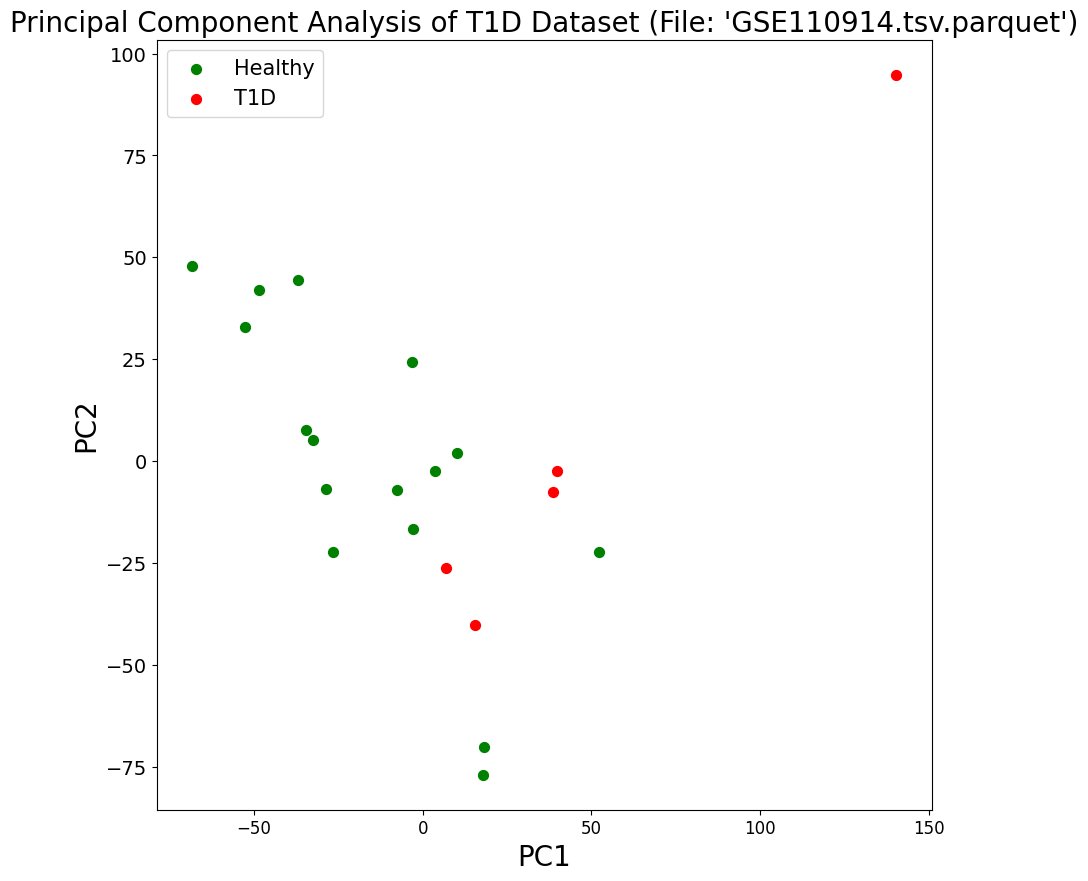

<Figure size 640x480 with 0 Axes>

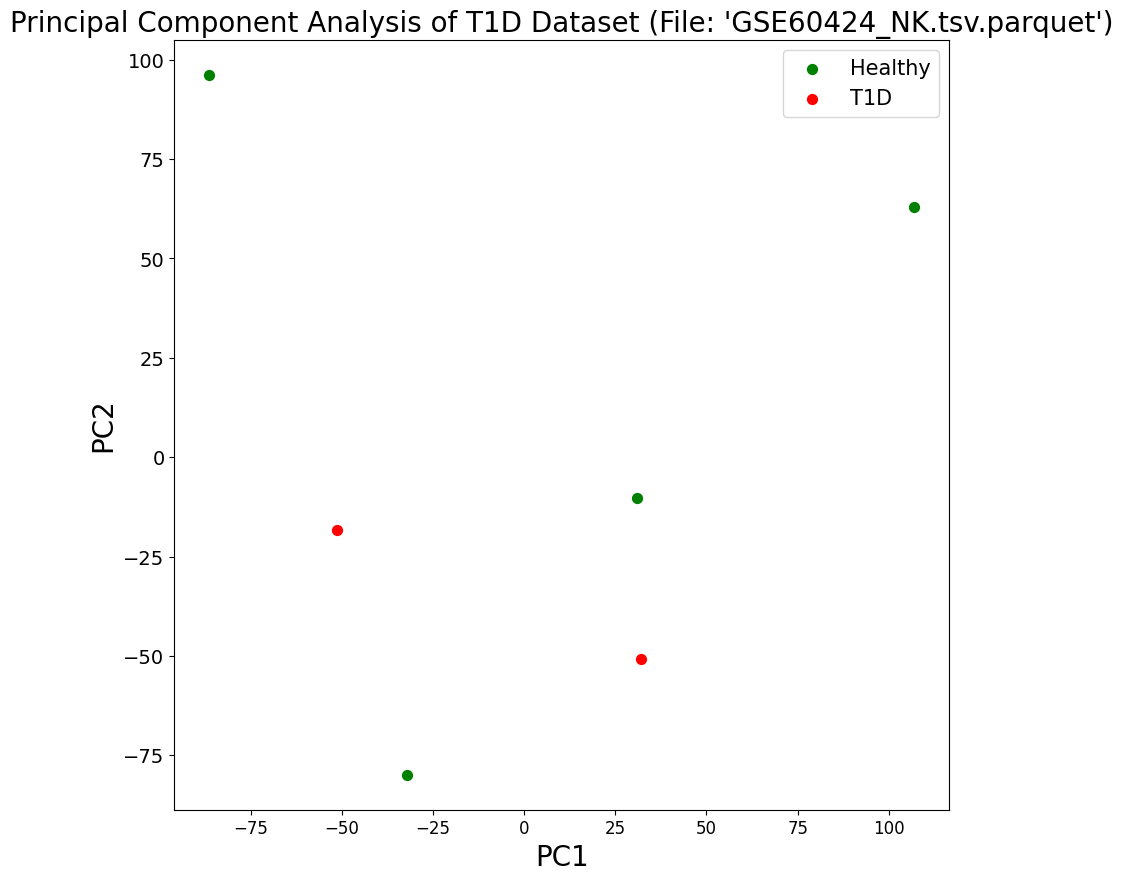

<Figure size 640x480 with 0 Axes>

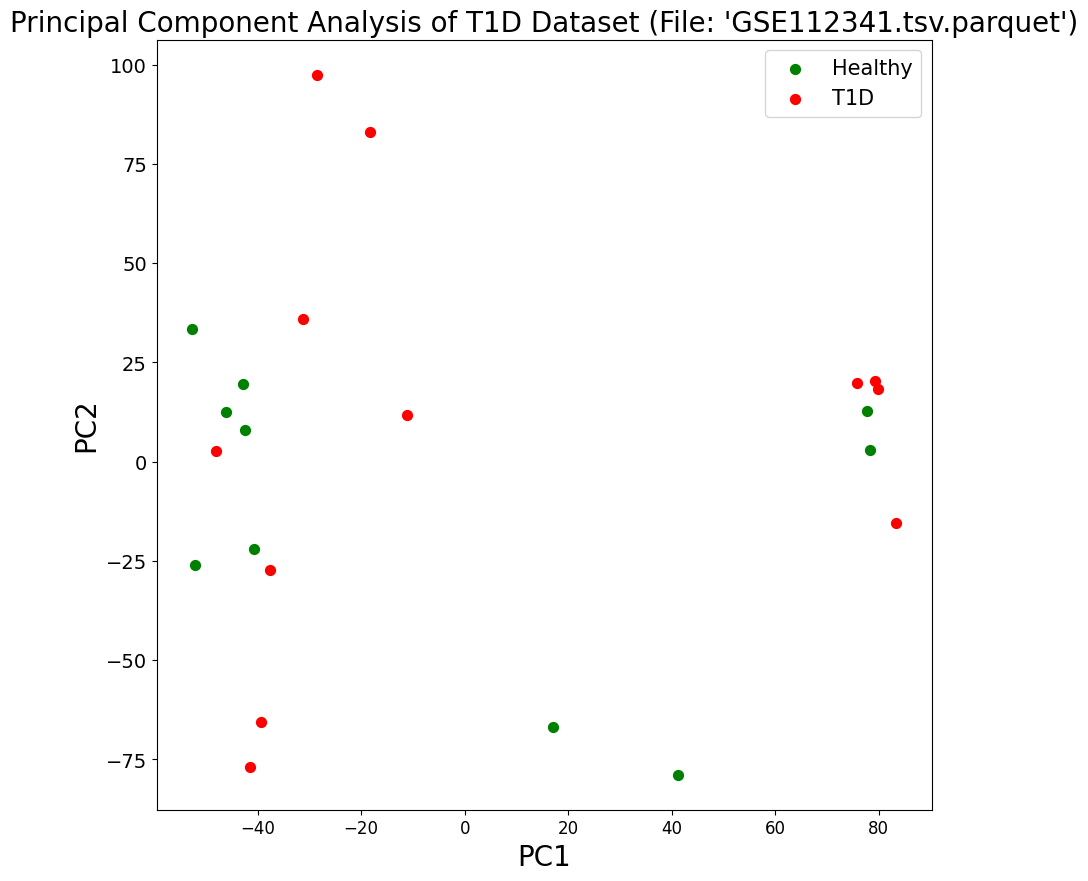

<Figure size 640x480 with 0 Axes>

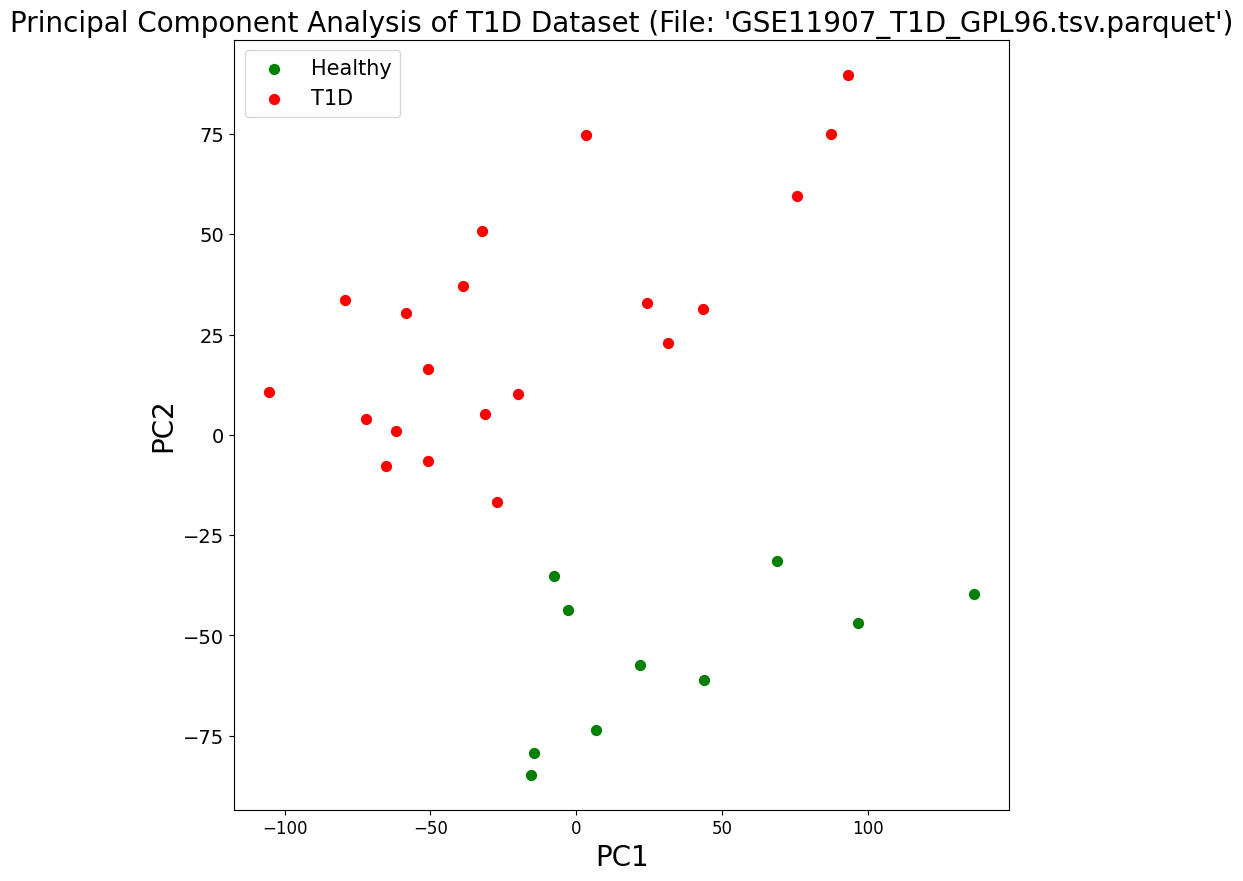

<Figure size 640x480 with 0 Axes>

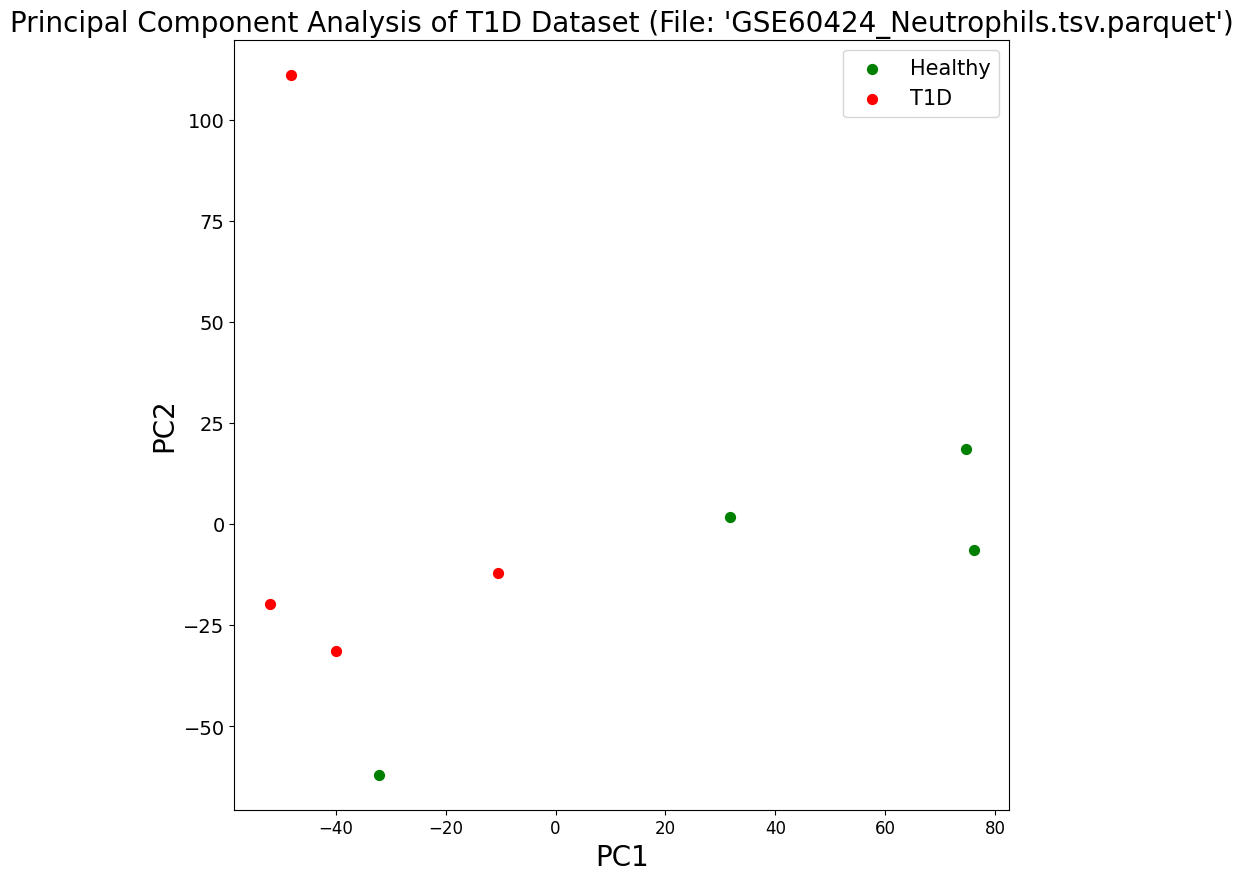

<Figure size 640x480 with 0 Axes>

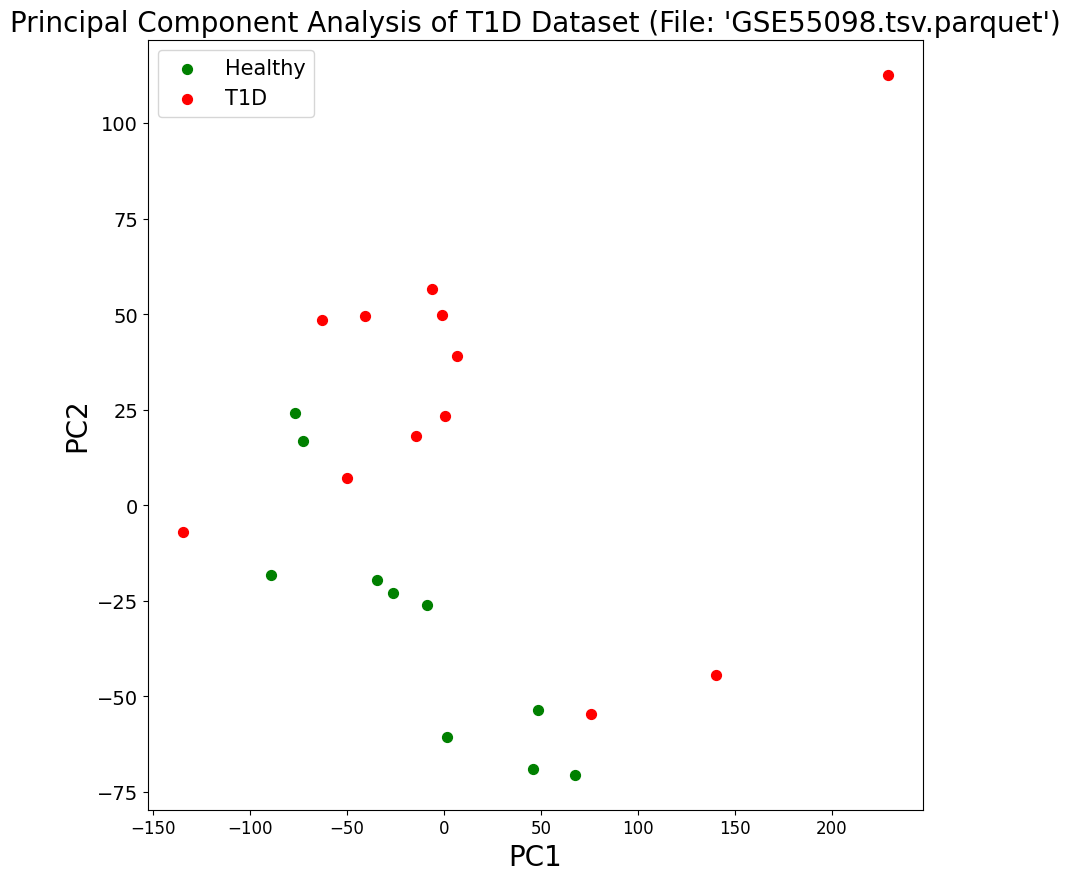

<Figure size 640x480 with 0 Axes>

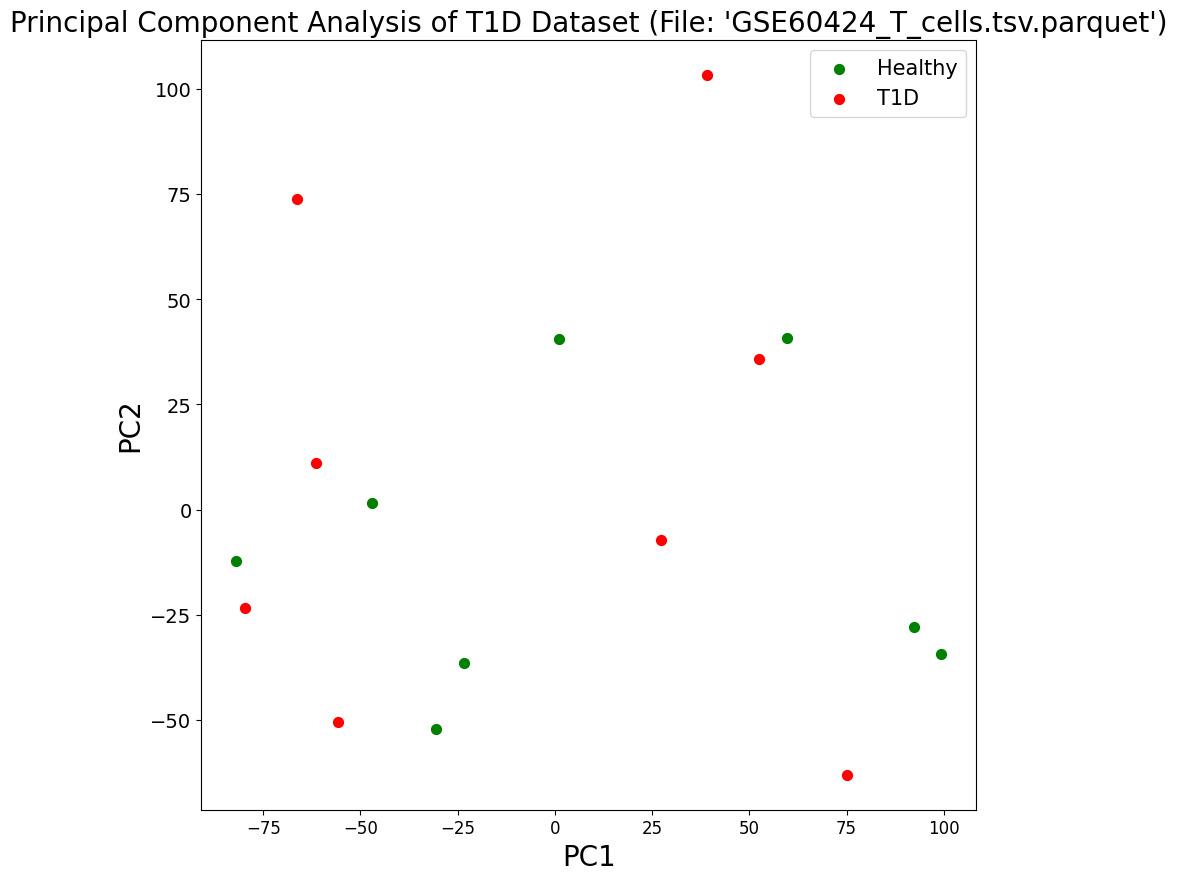

<Figure size 640x480 with 0 Axes>

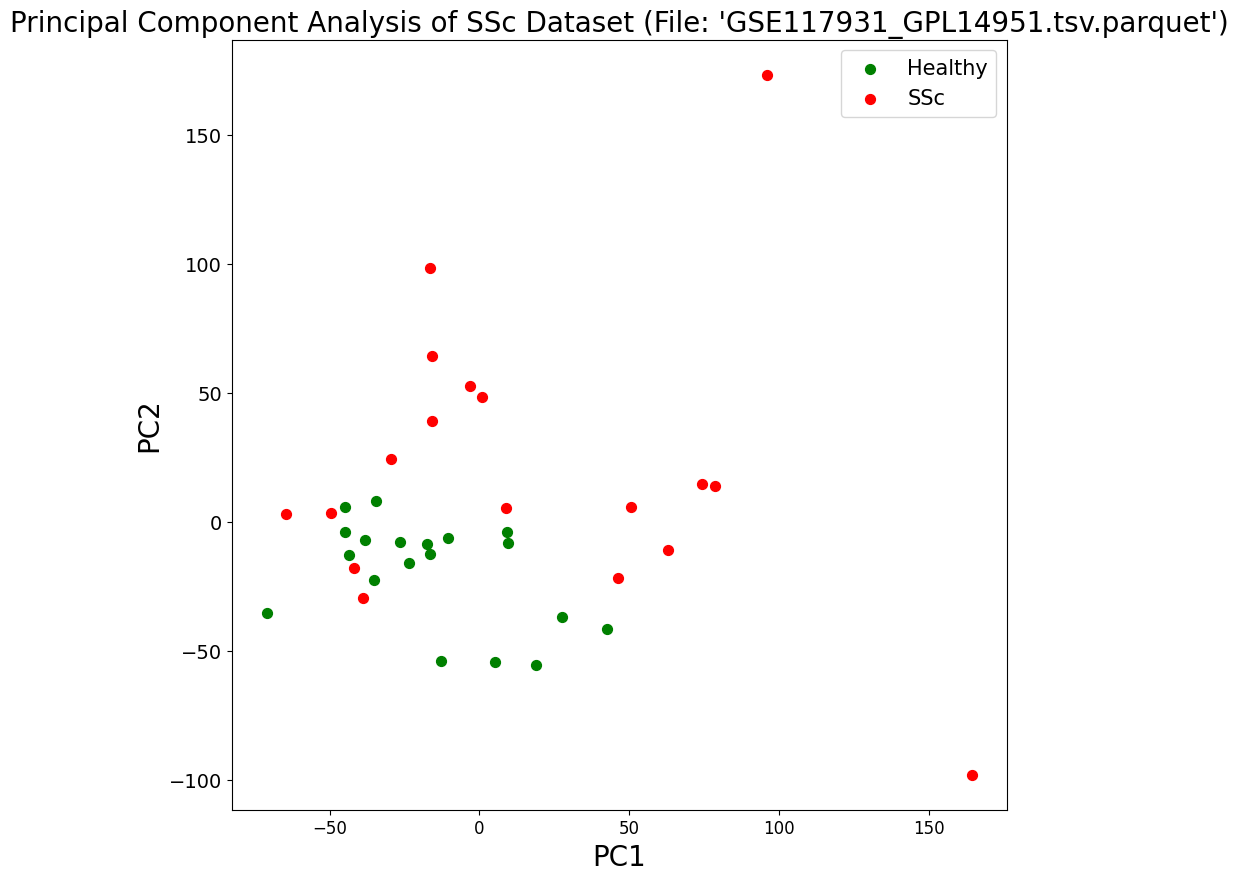

<Figure size 640x480 with 0 Axes>

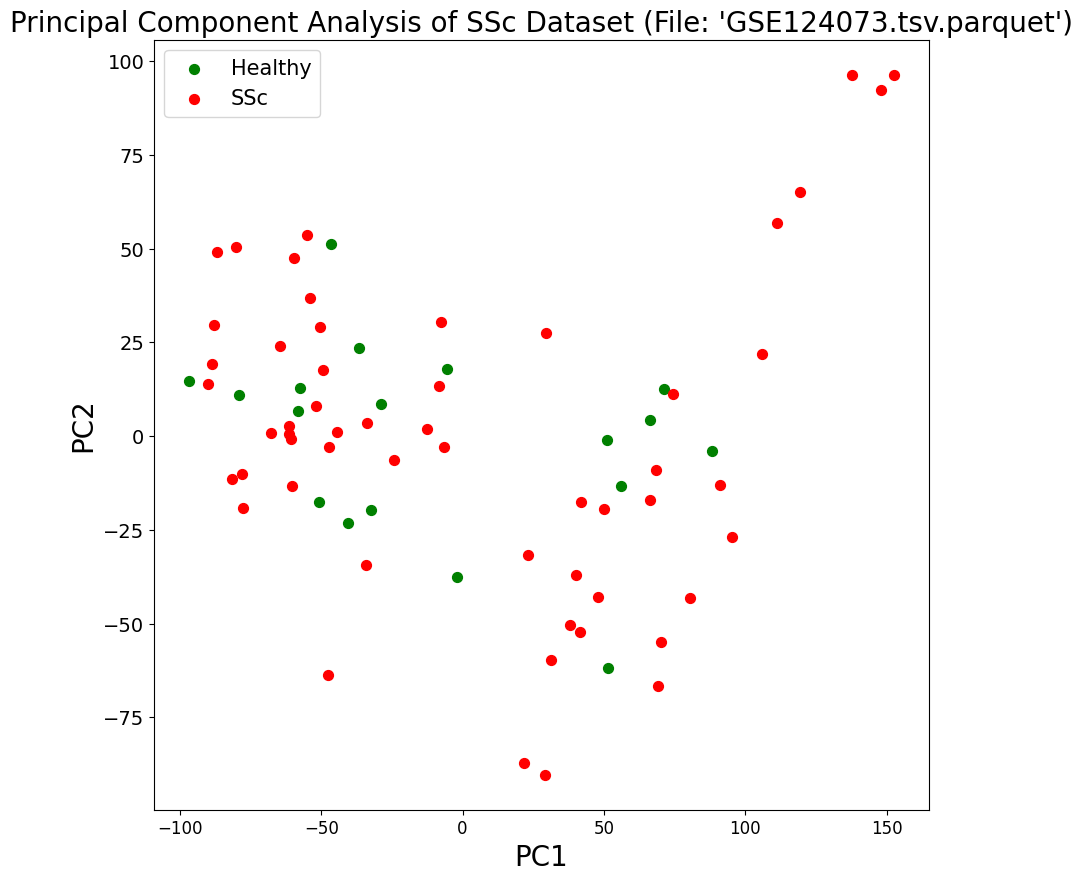

<Figure size 640x480 with 0 Axes>

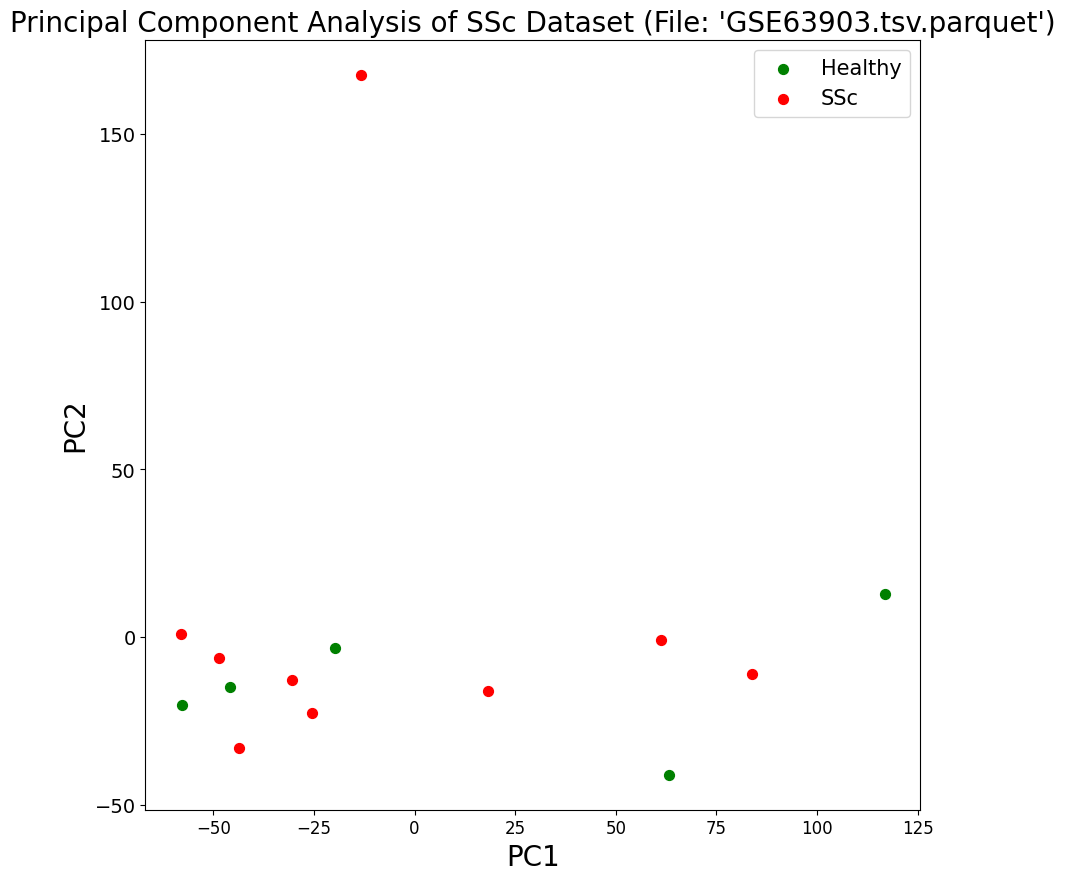

<Figure size 640x480 with 0 Axes>

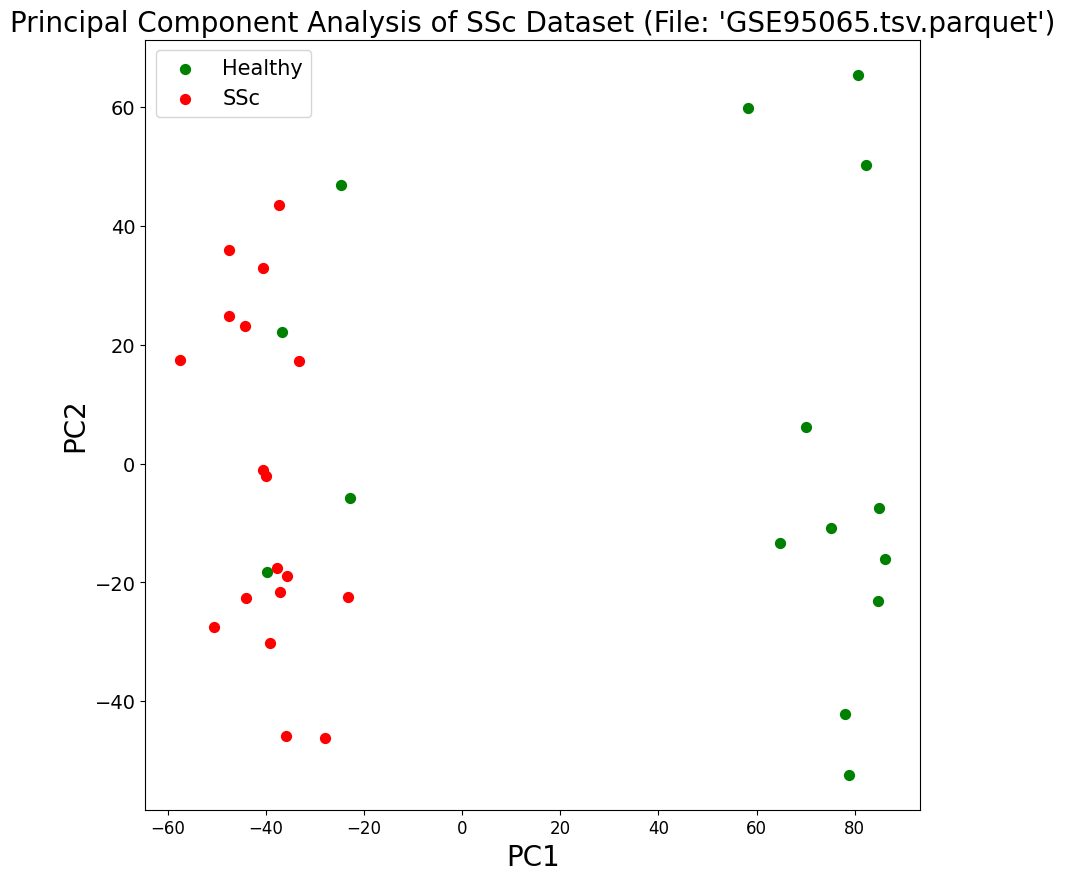

<Figure size 640x480 with 0 Axes>

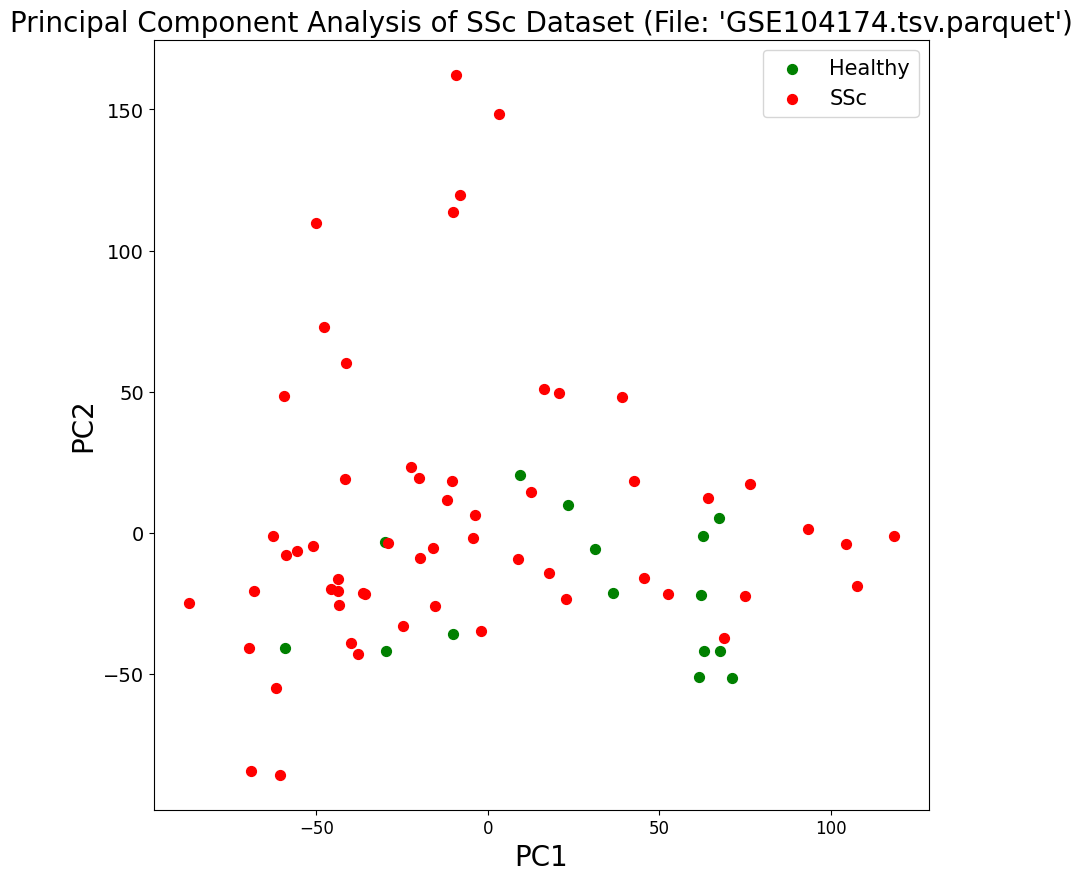

<Figure size 640x480 with 0 Axes>

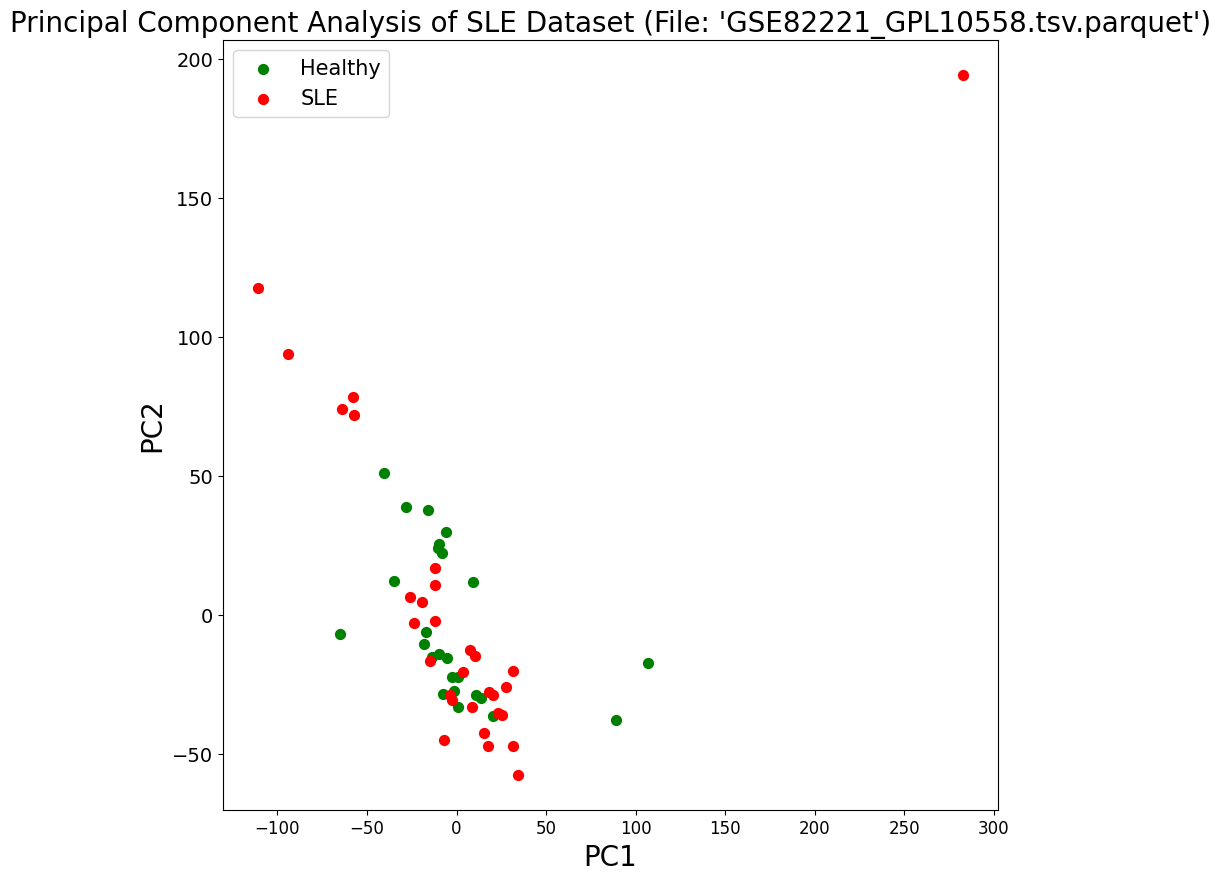

<Figure size 640x480 with 0 Axes>

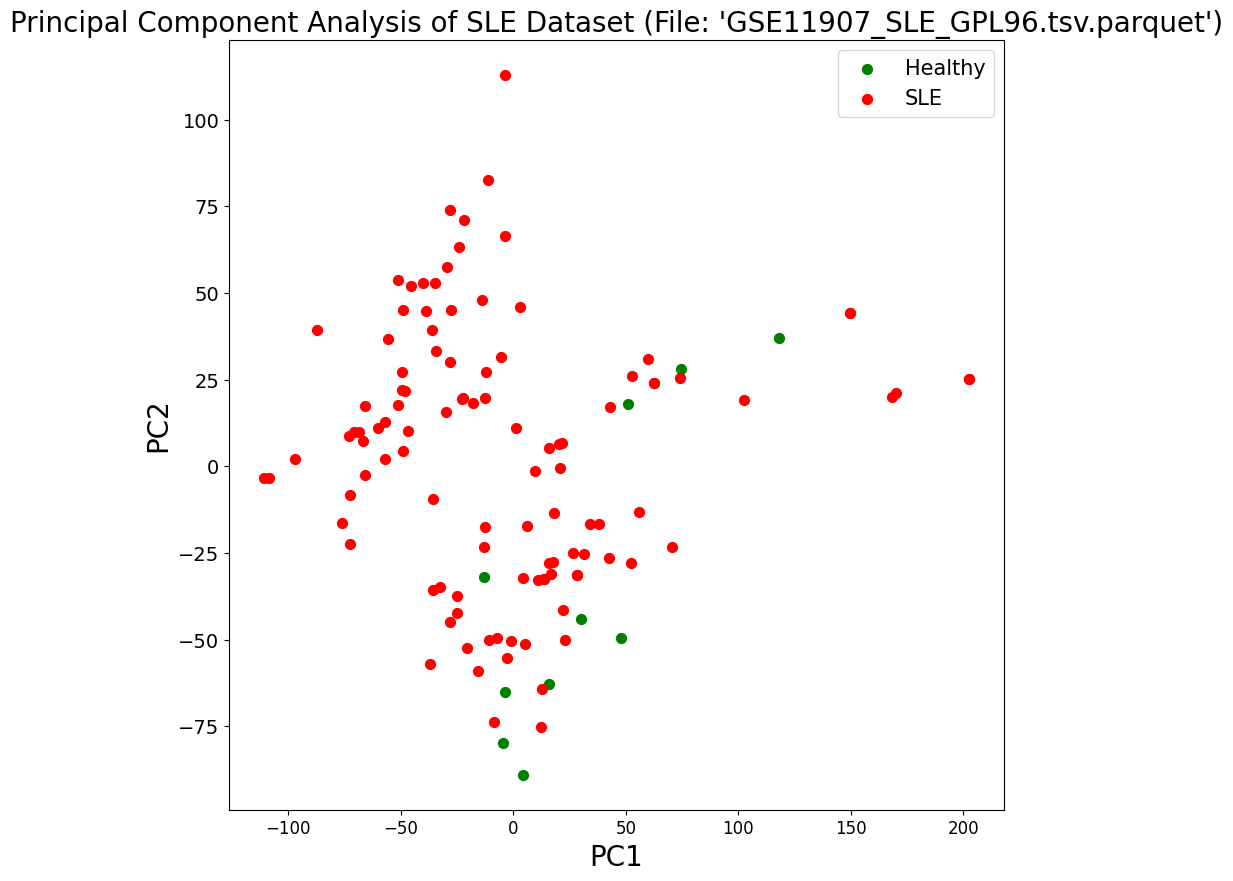

<Figure size 640x480 with 0 Axes>

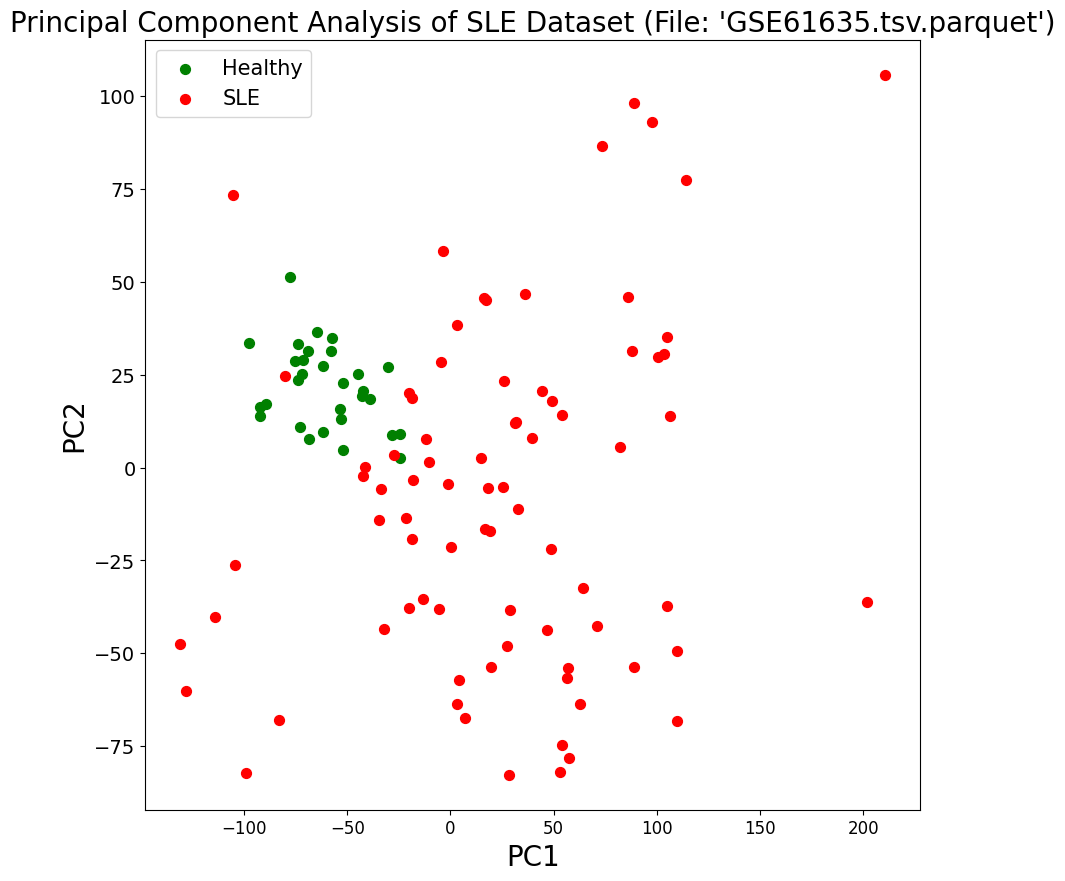

<Figure size 640x480 with 0 Axes>

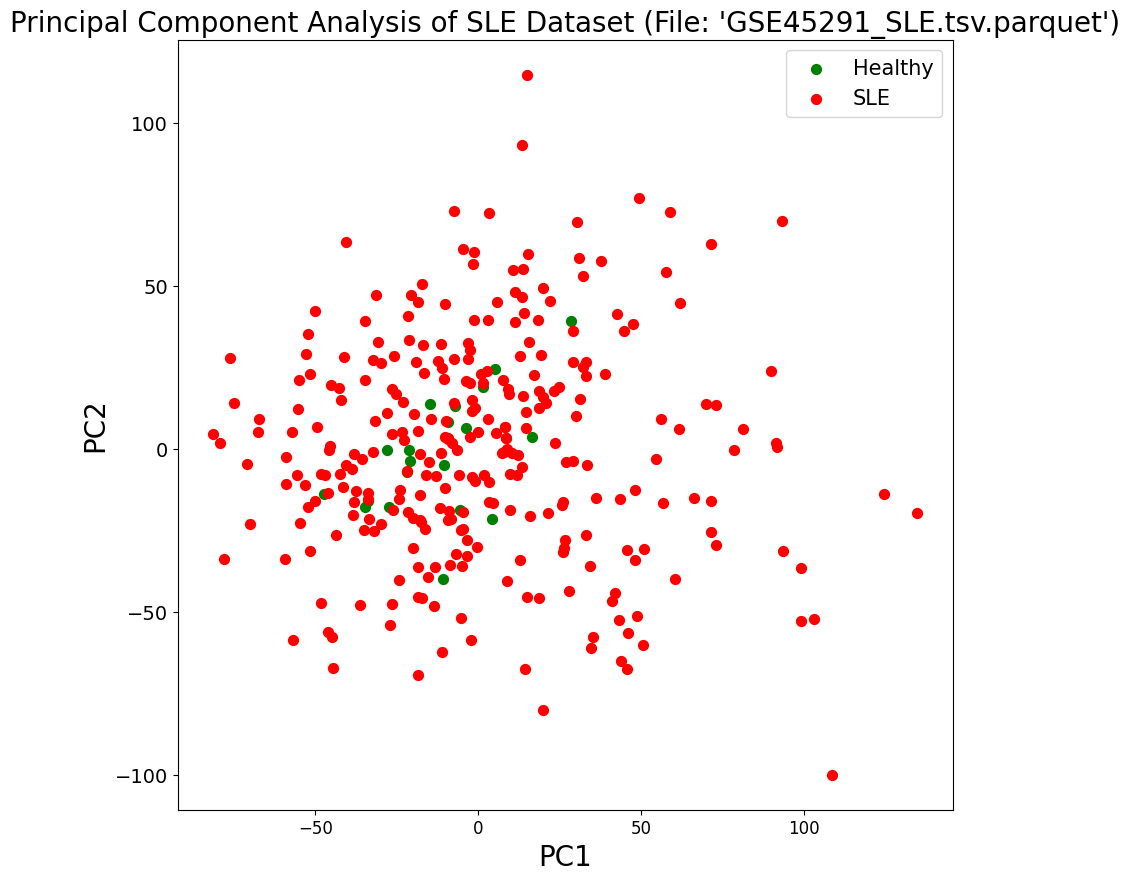

<Figure size 640x480 with 0 Axes>

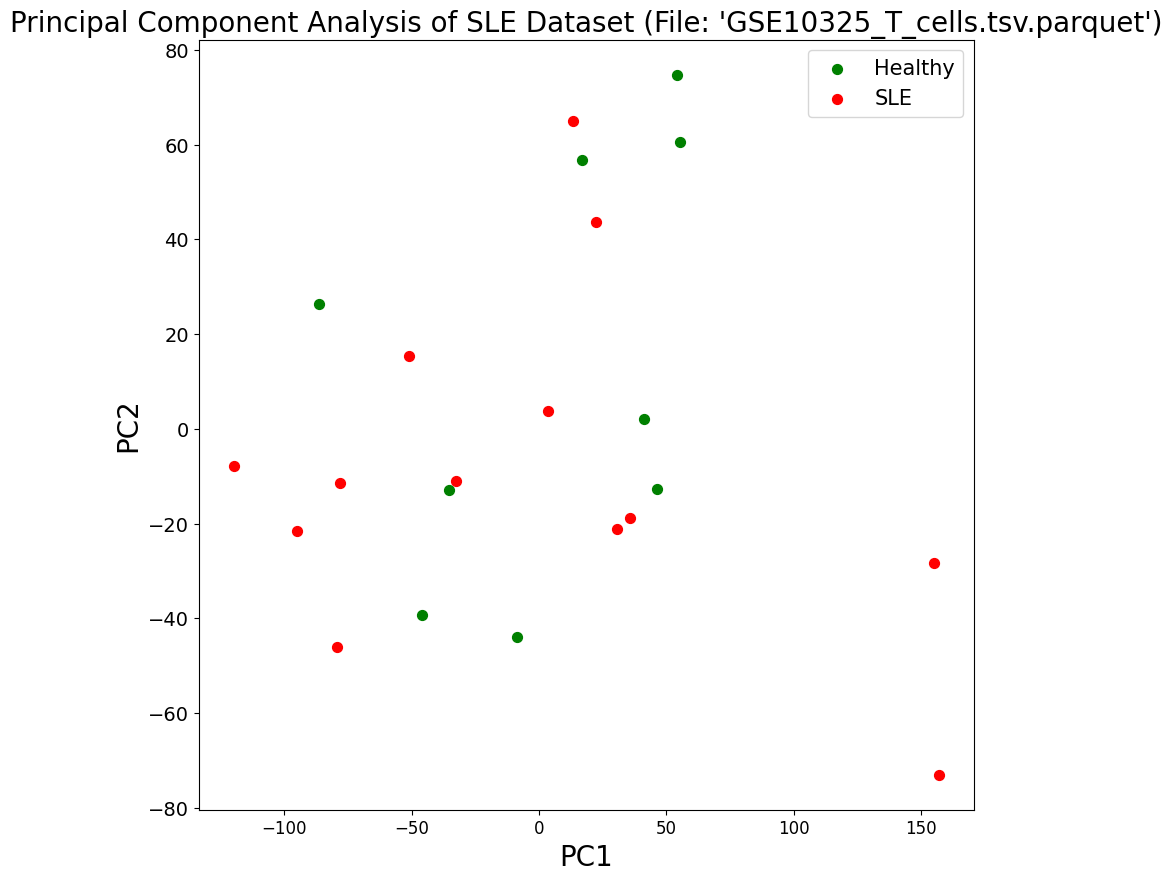

<Figure size 640x480 with 0 Axes>

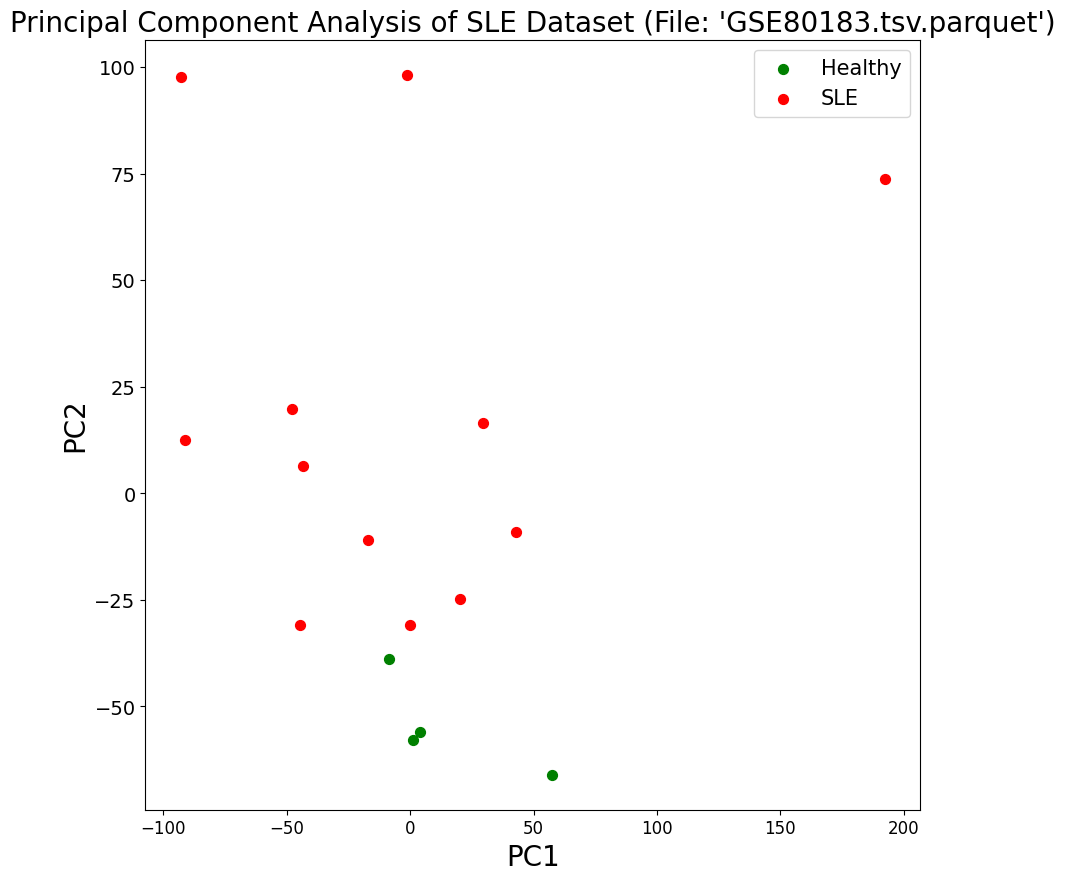

<Figure size 640x480 with 0 Axes>

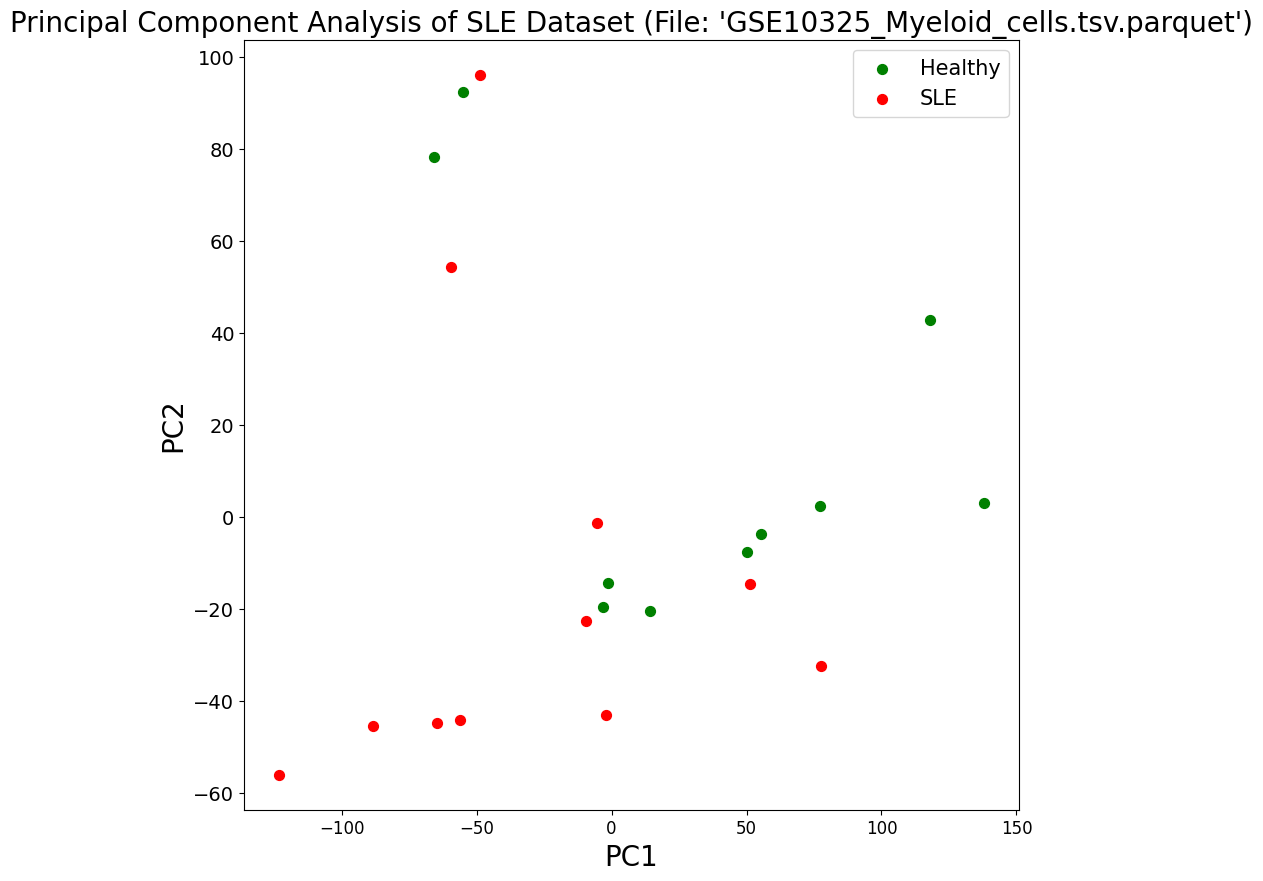

<Figure size 640x480 with 0 Axes>

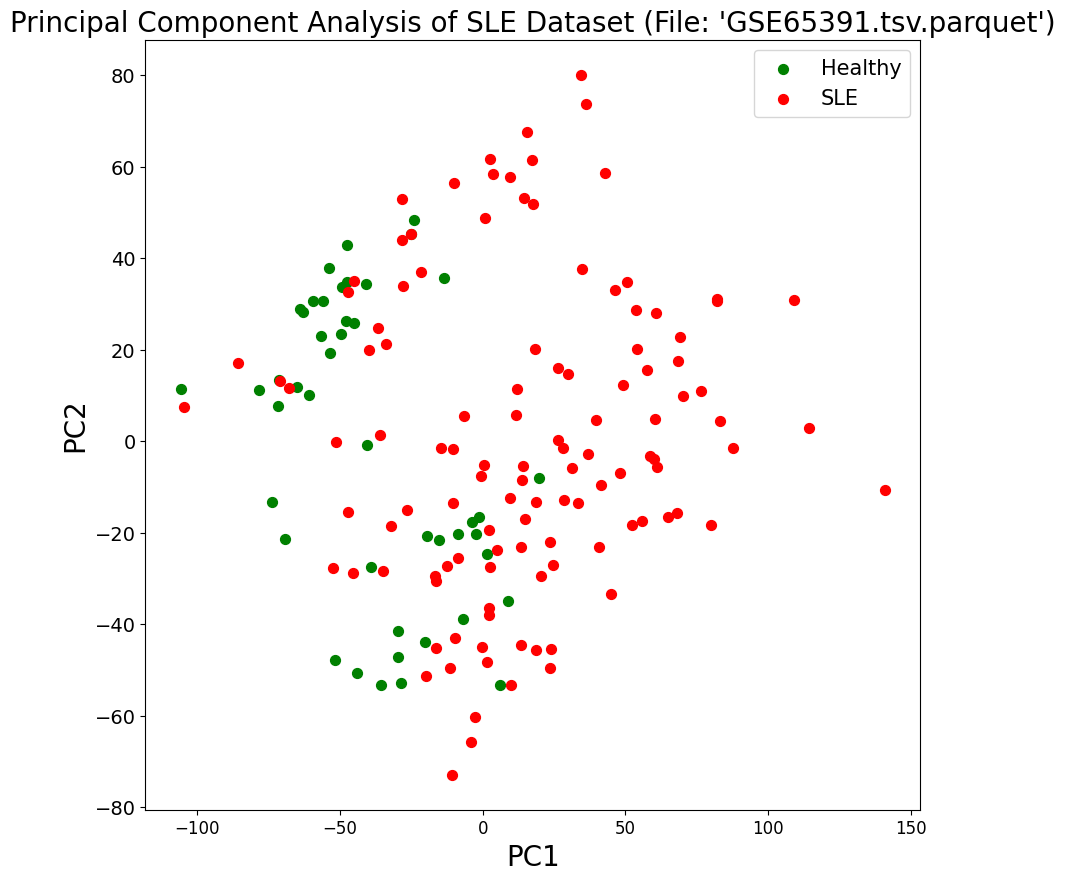

<Figure size 640x480 with 0 Axes>

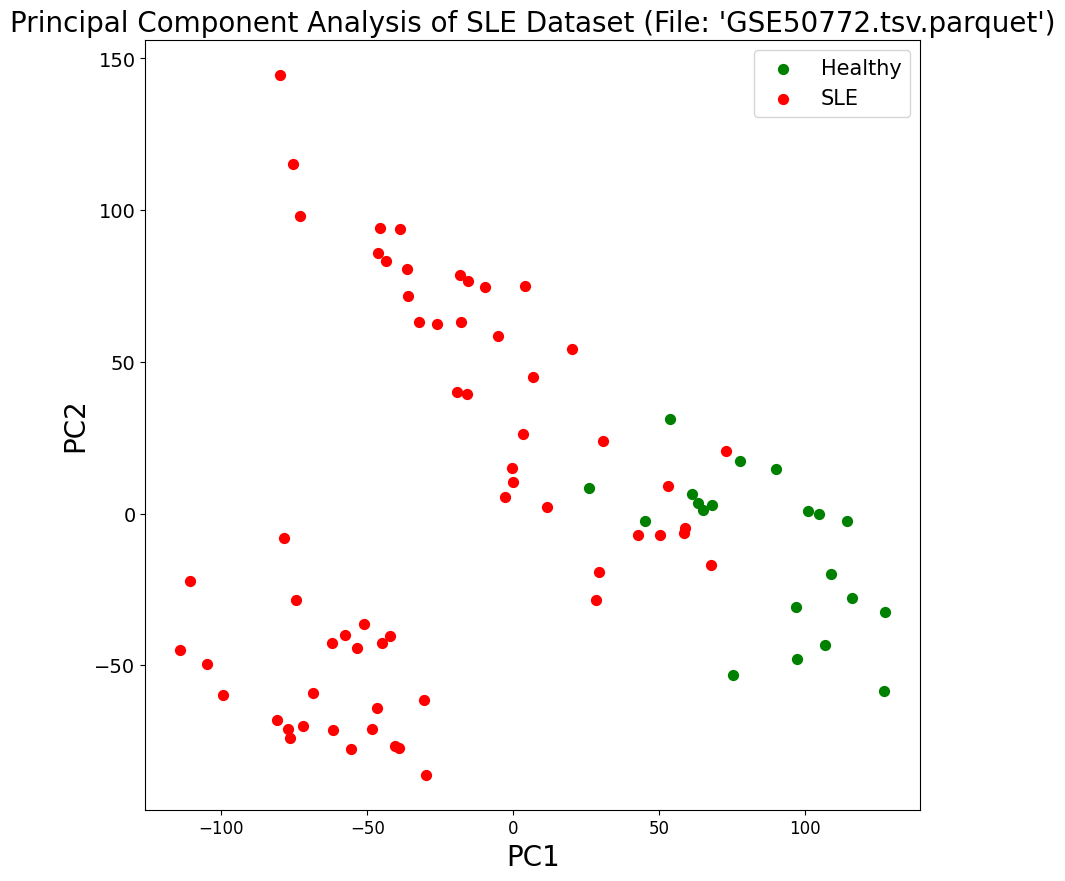

<Figure size 640x480 with 0 Axes>

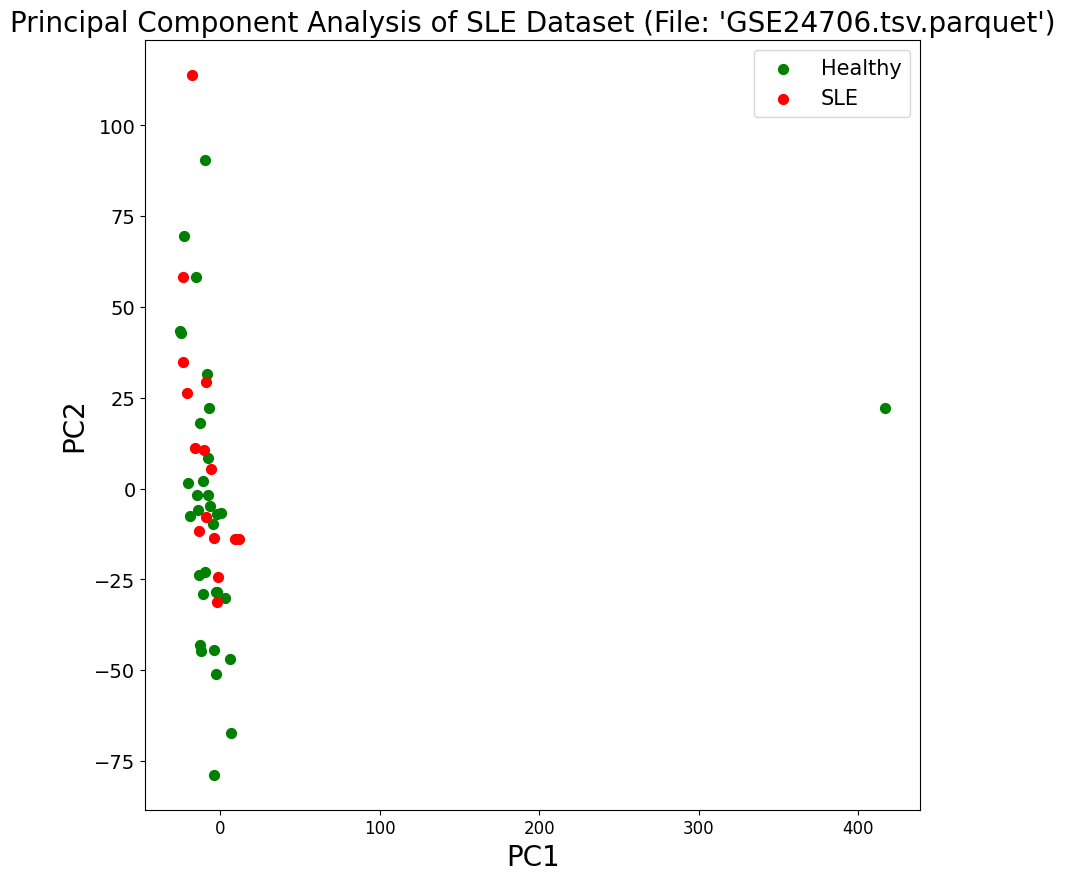

<Figure size 640x480 with 0 Axes>

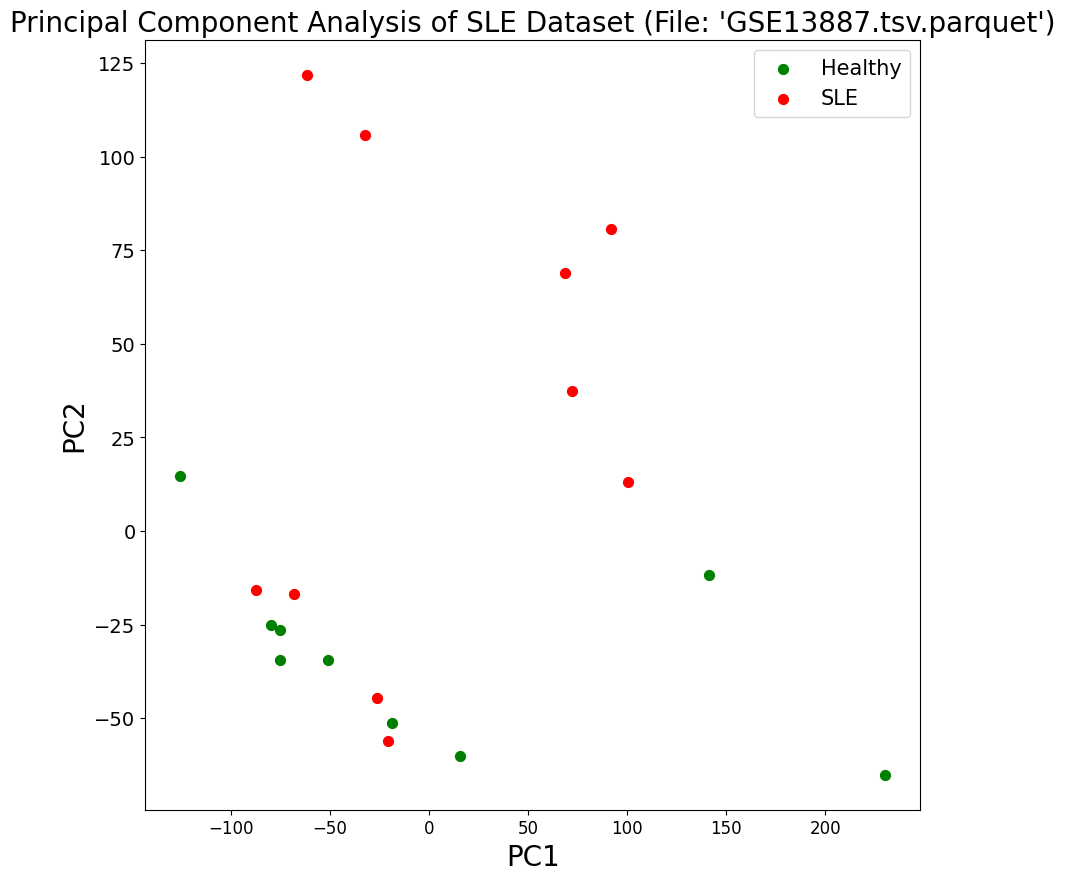

<Figure size 640x480 with 0 Axes>

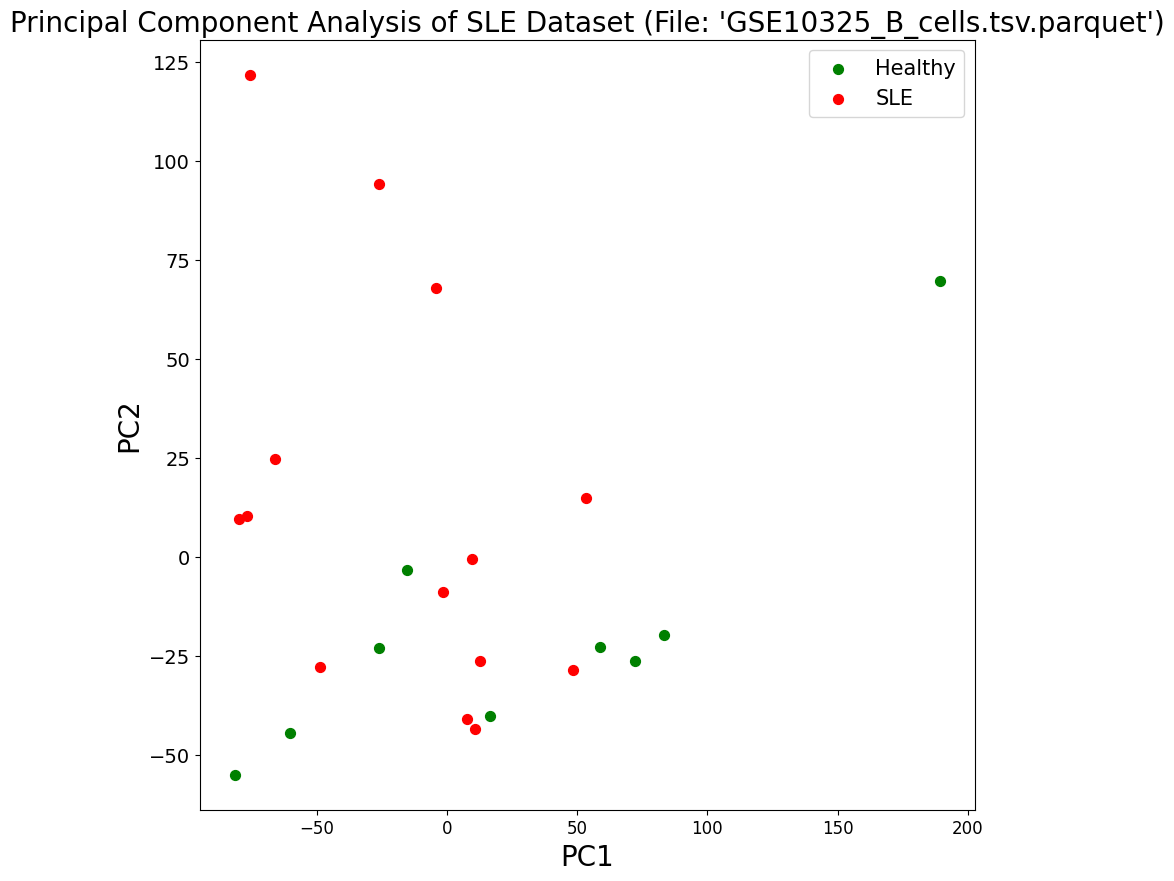

<Figure size 640x480 with 0 Axes>

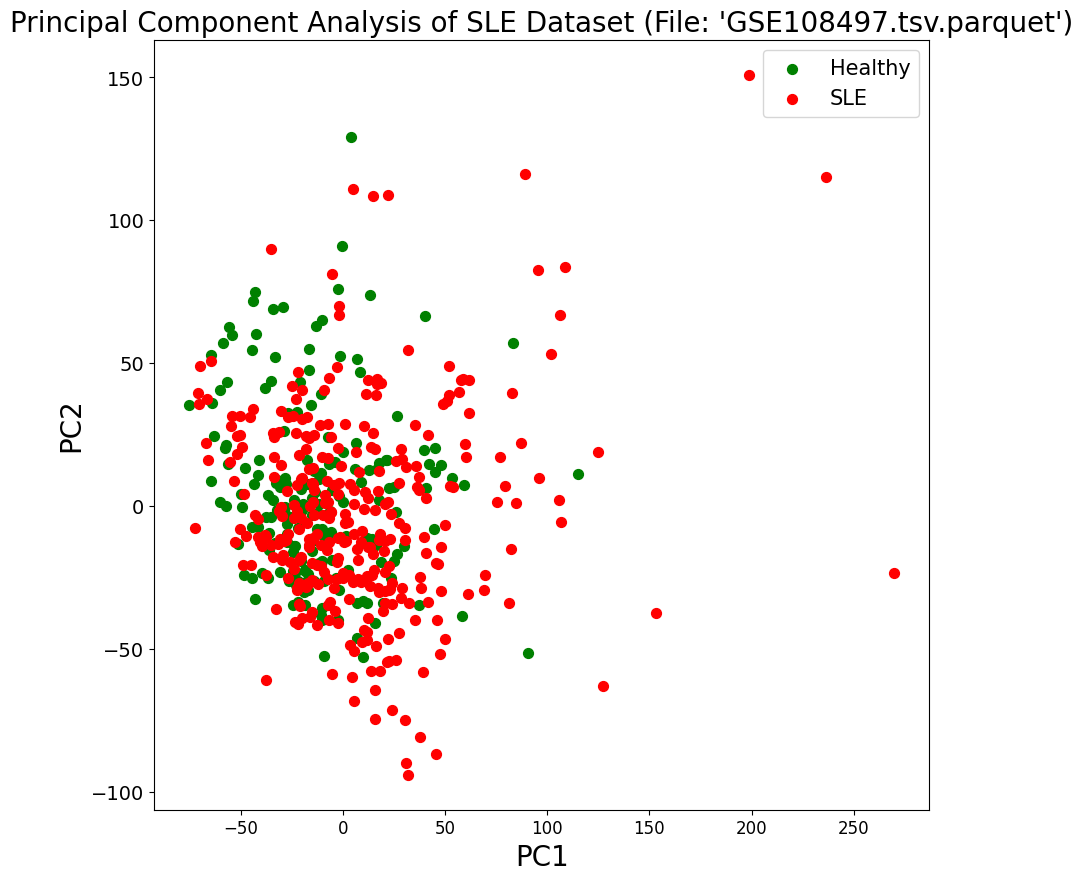

<Figure size 640x480 with 0 Axes>

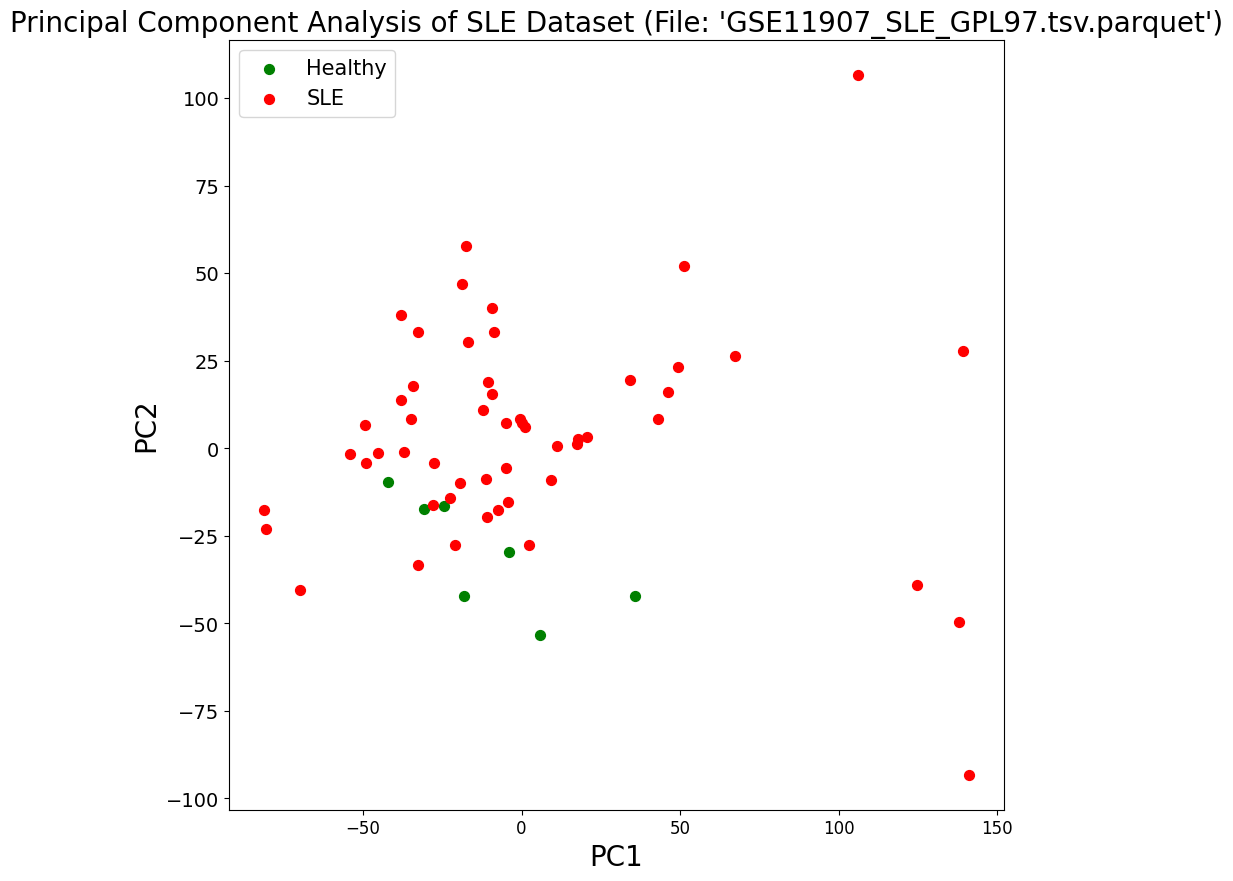

<Figure size 640x480 with 0 Axes>

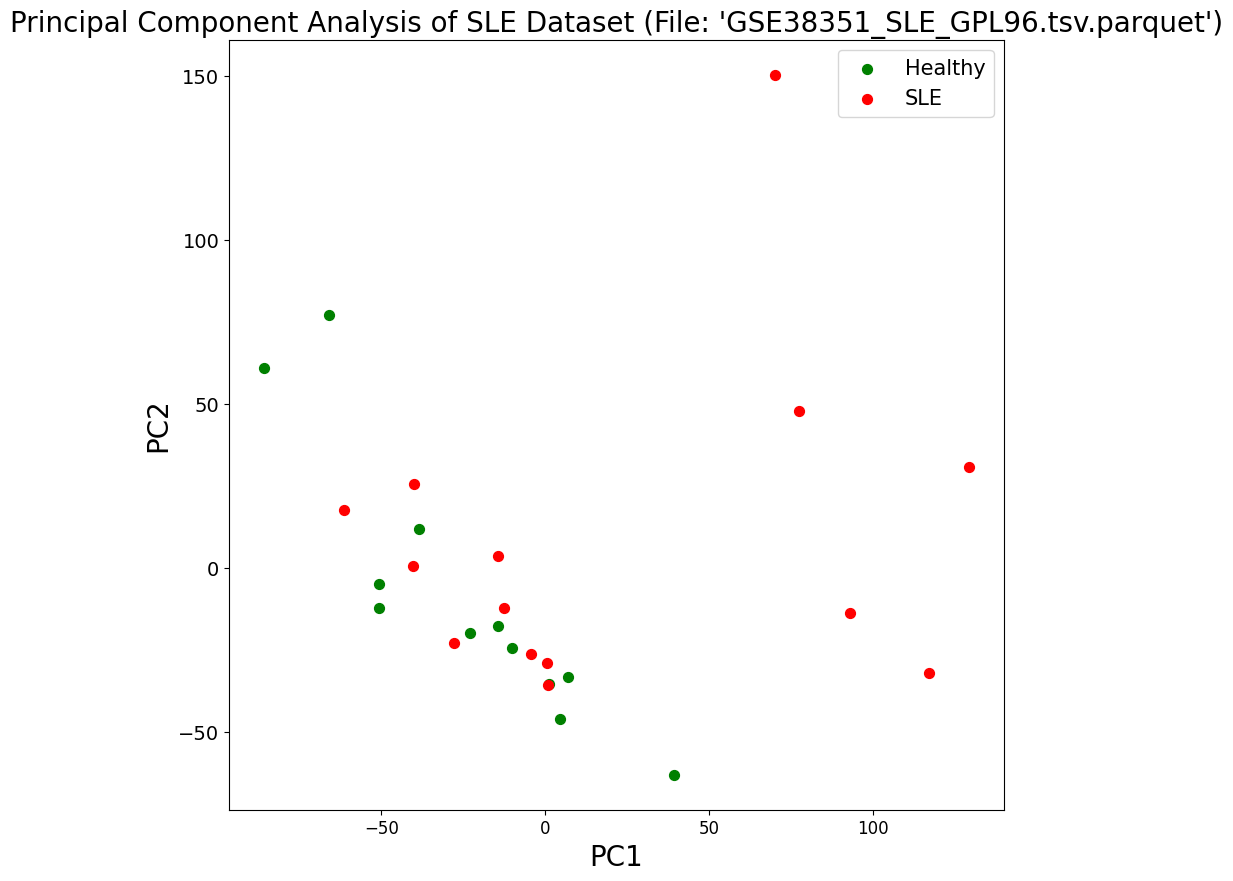

<Figure size 640x480 with 0 Axes>

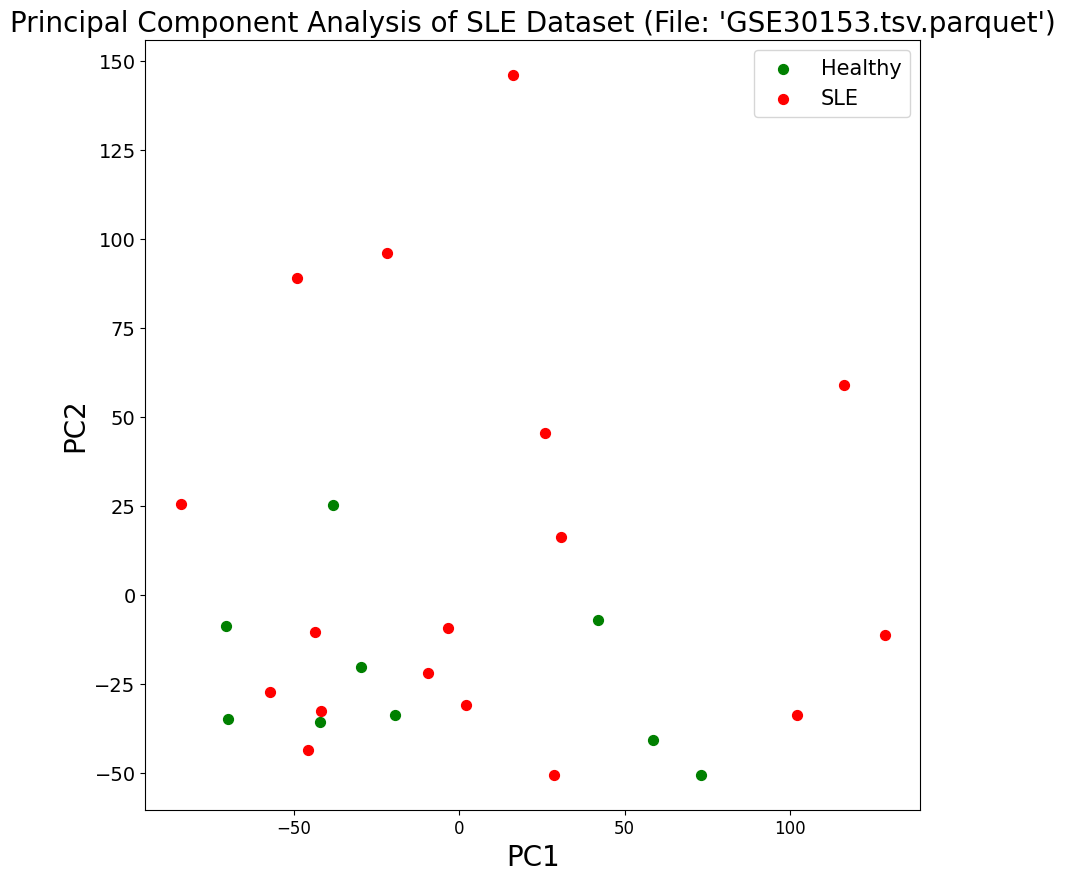

<Figure size 640x480 with 0 Axes>

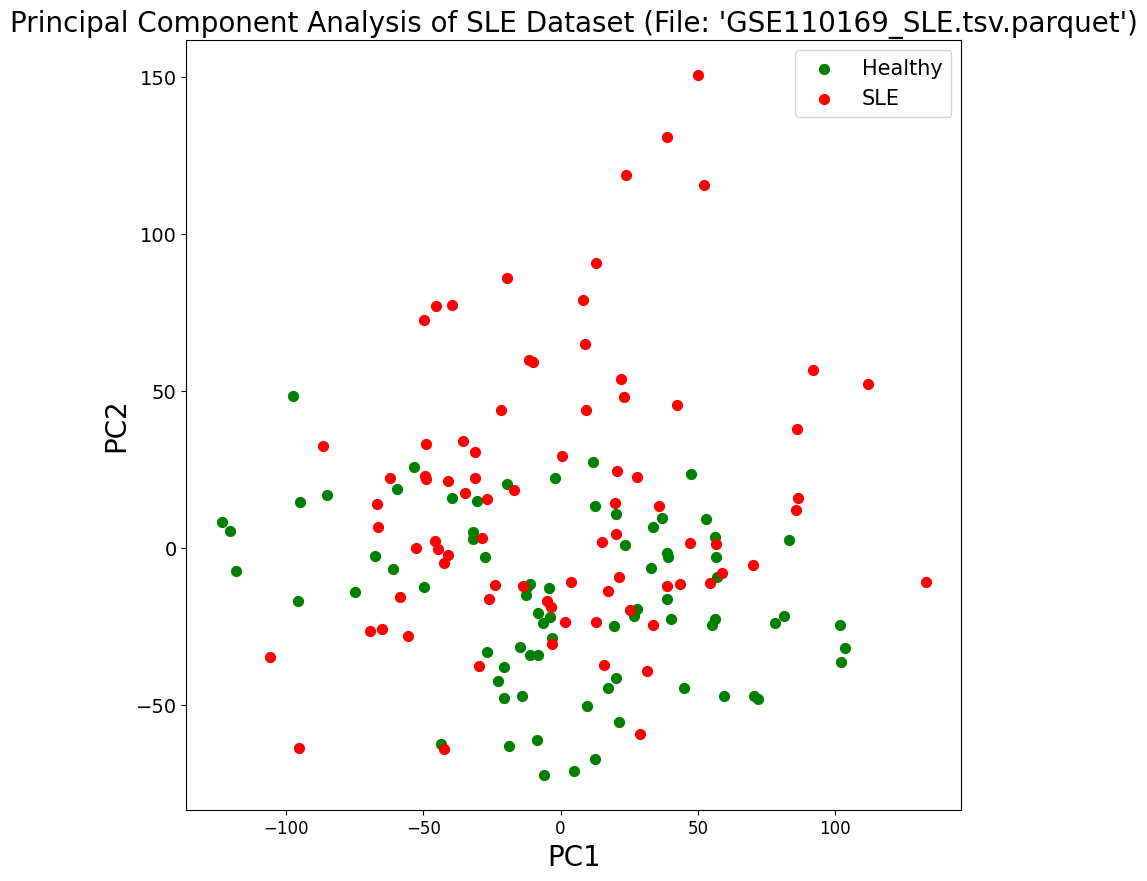

<Figure size 640x480 with 0 Axes>

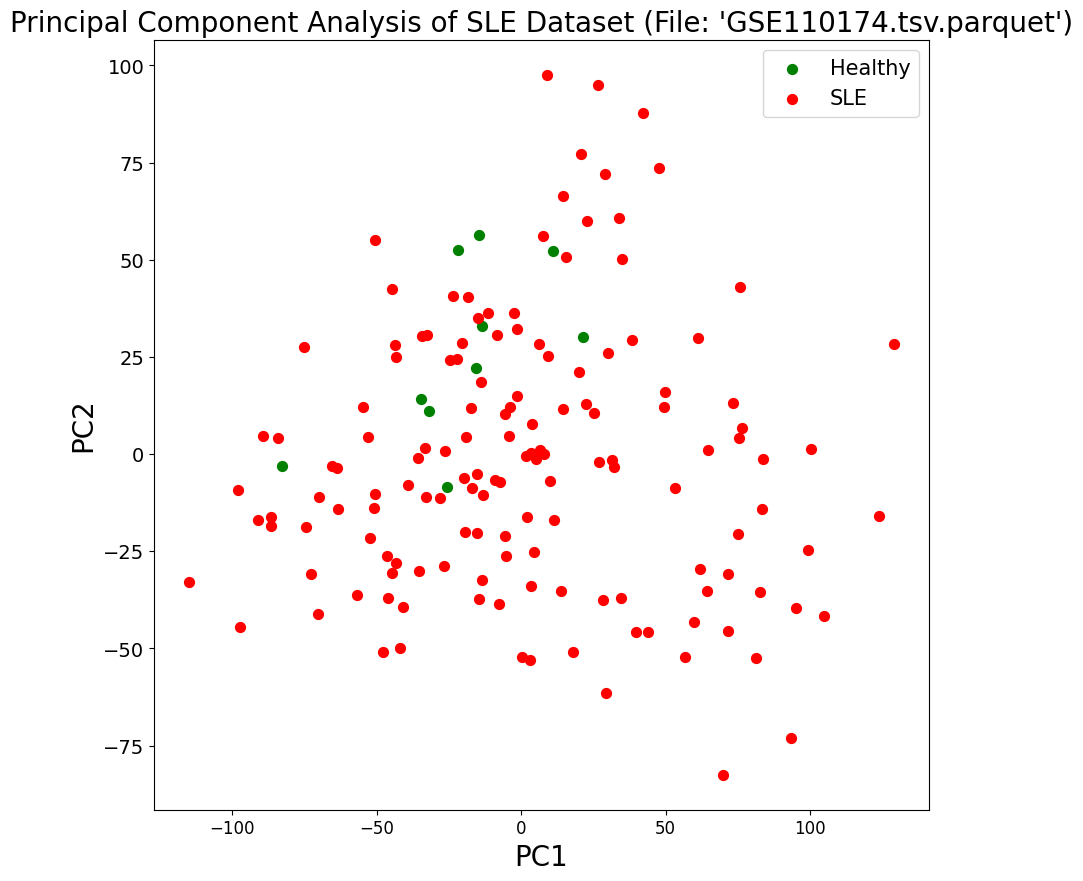

<Figure size 640x480 with 0 Axes>

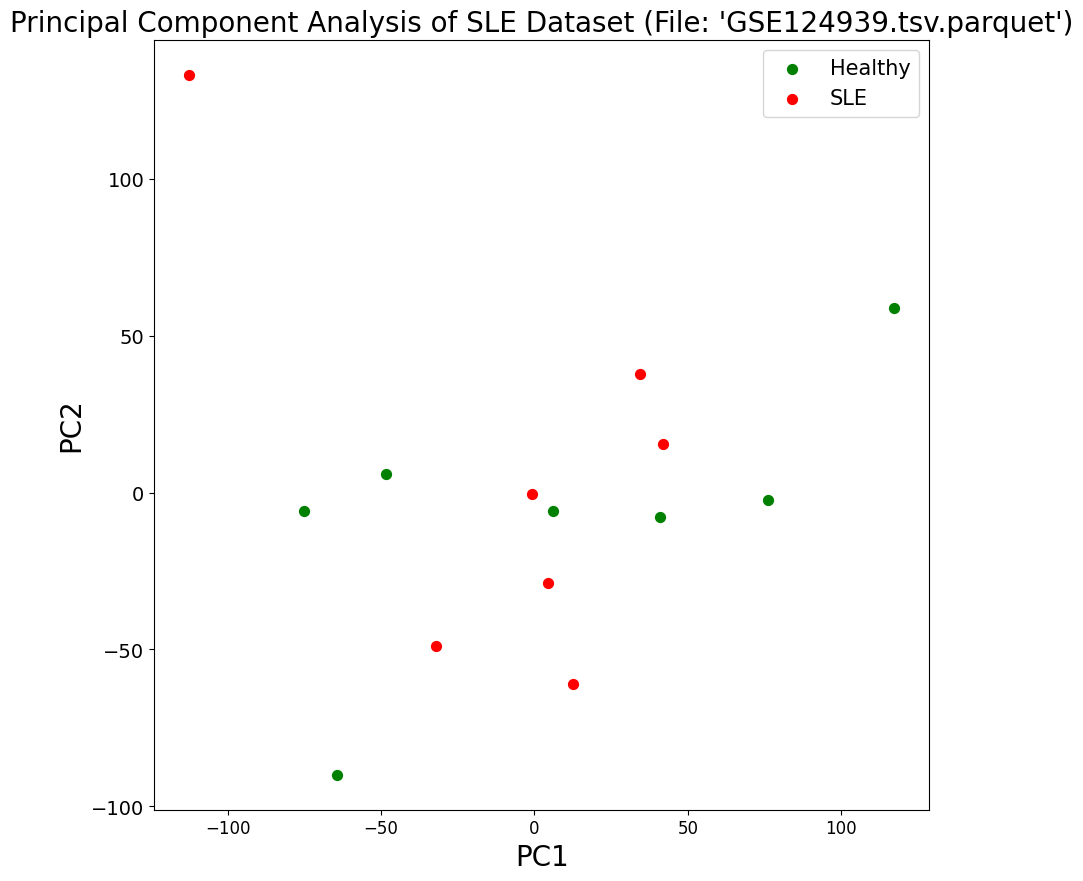

<Figure size 640x480 with 0 Axes>

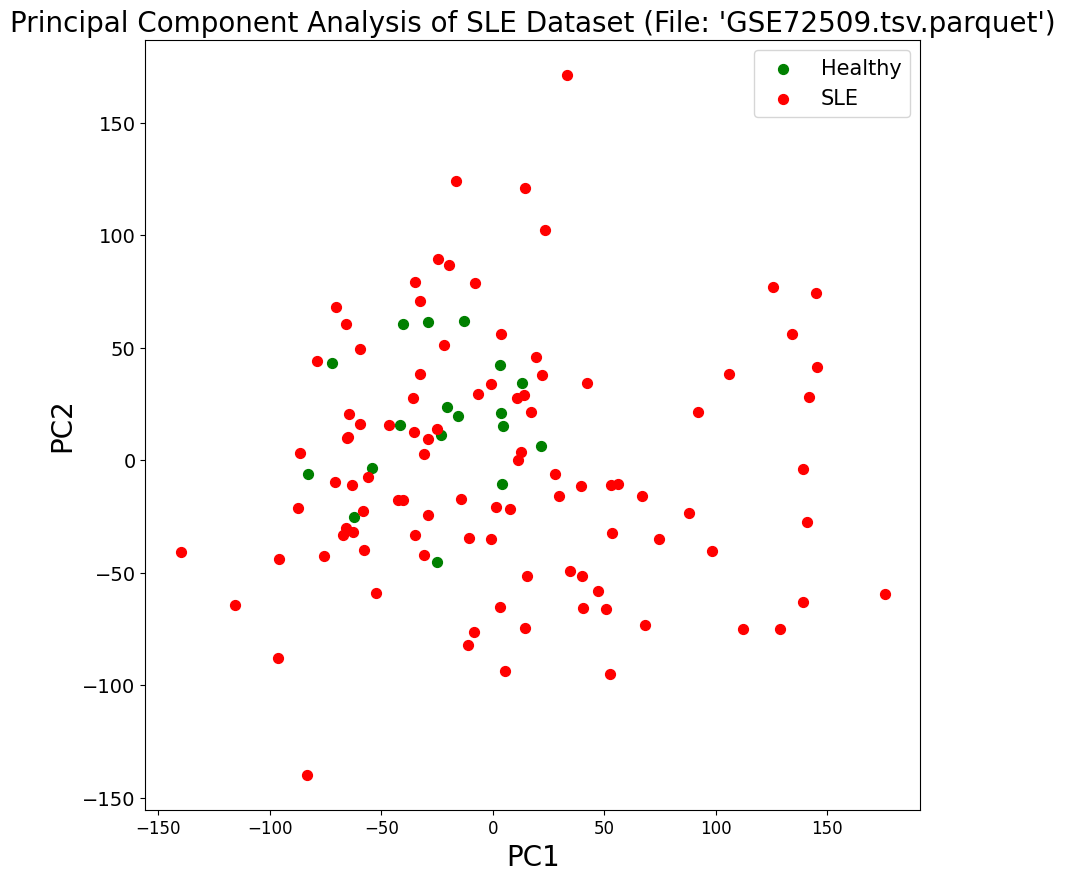

<Figure size 640x480 with 0 Axes>

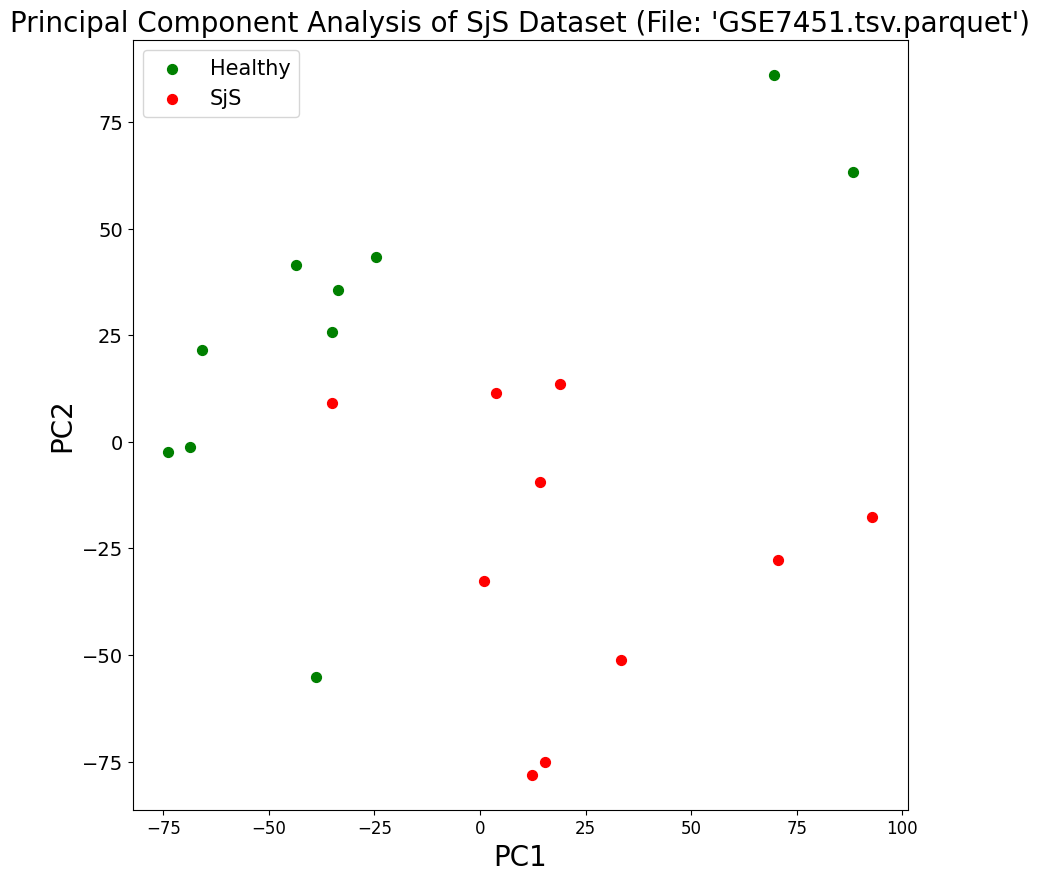

<Figure size 640x480 with 0 Axes>

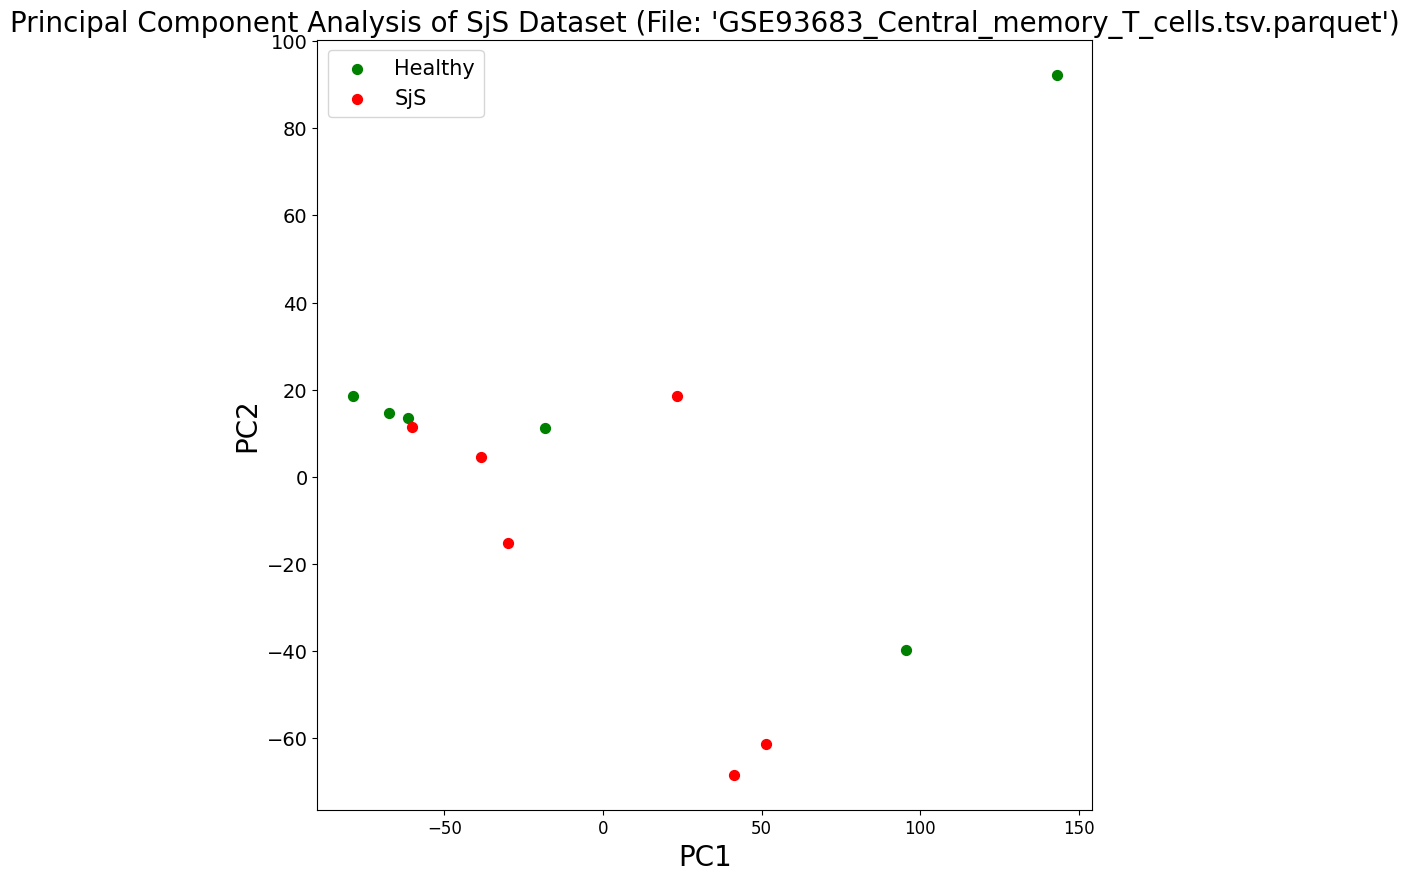

<Figure size 640x480 with 0 Axes>

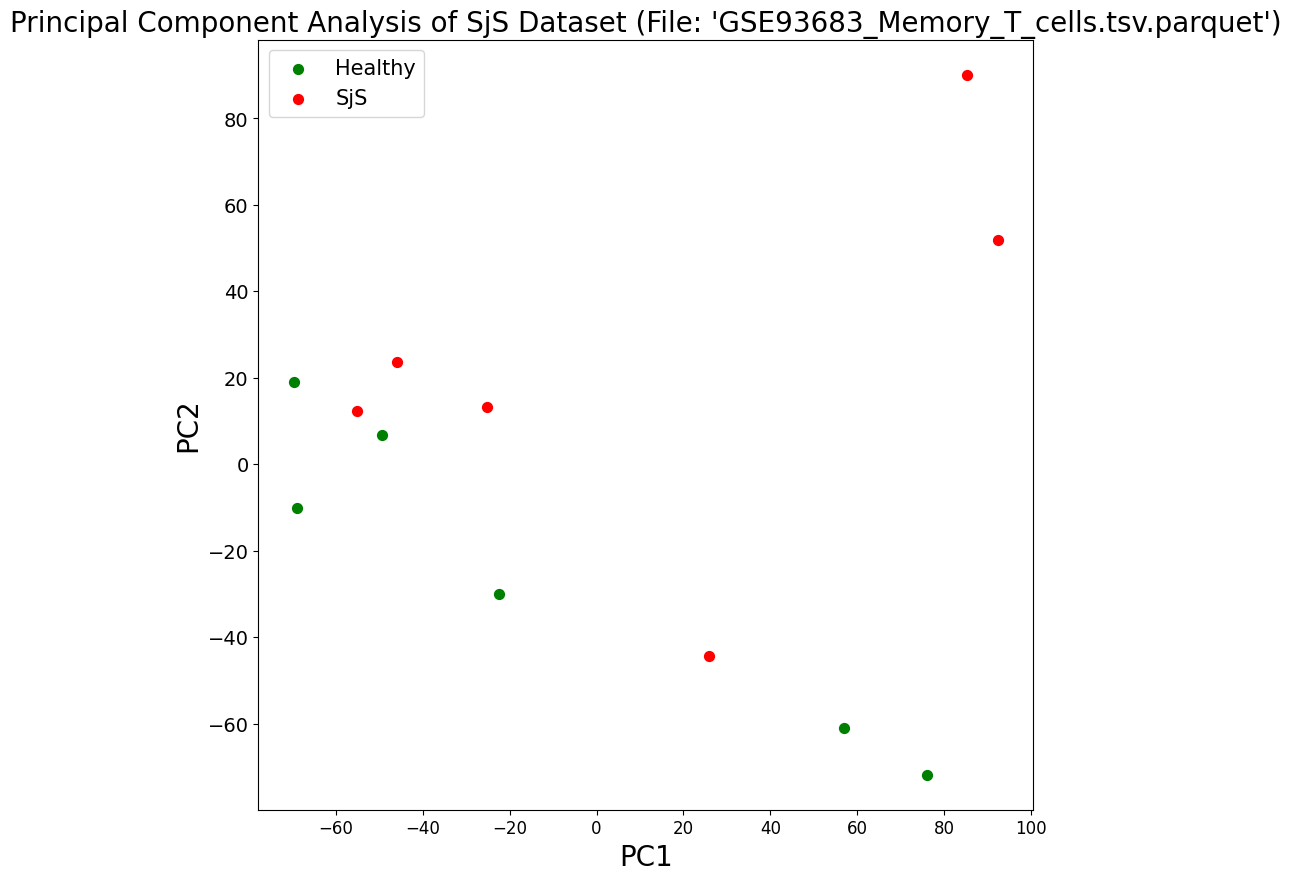

<Figure size 640x480 with 0 Axes>

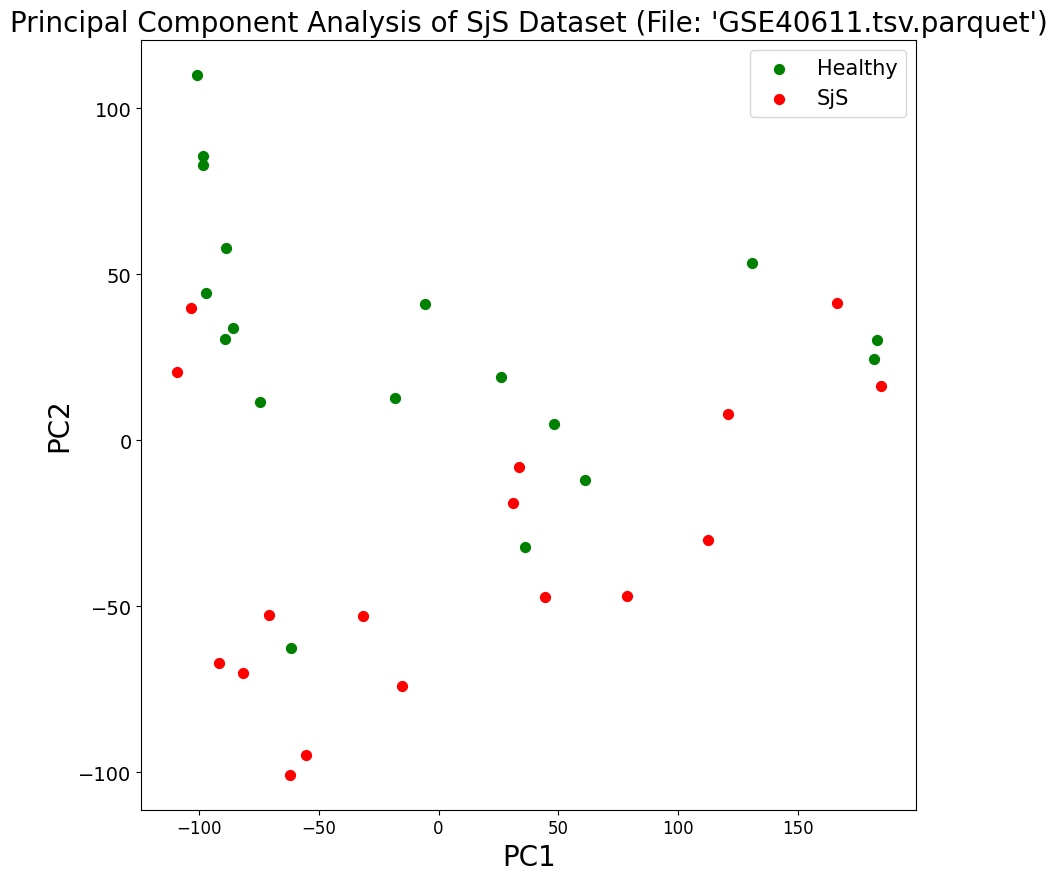

<Figure size 640x480 with 0 Axes>

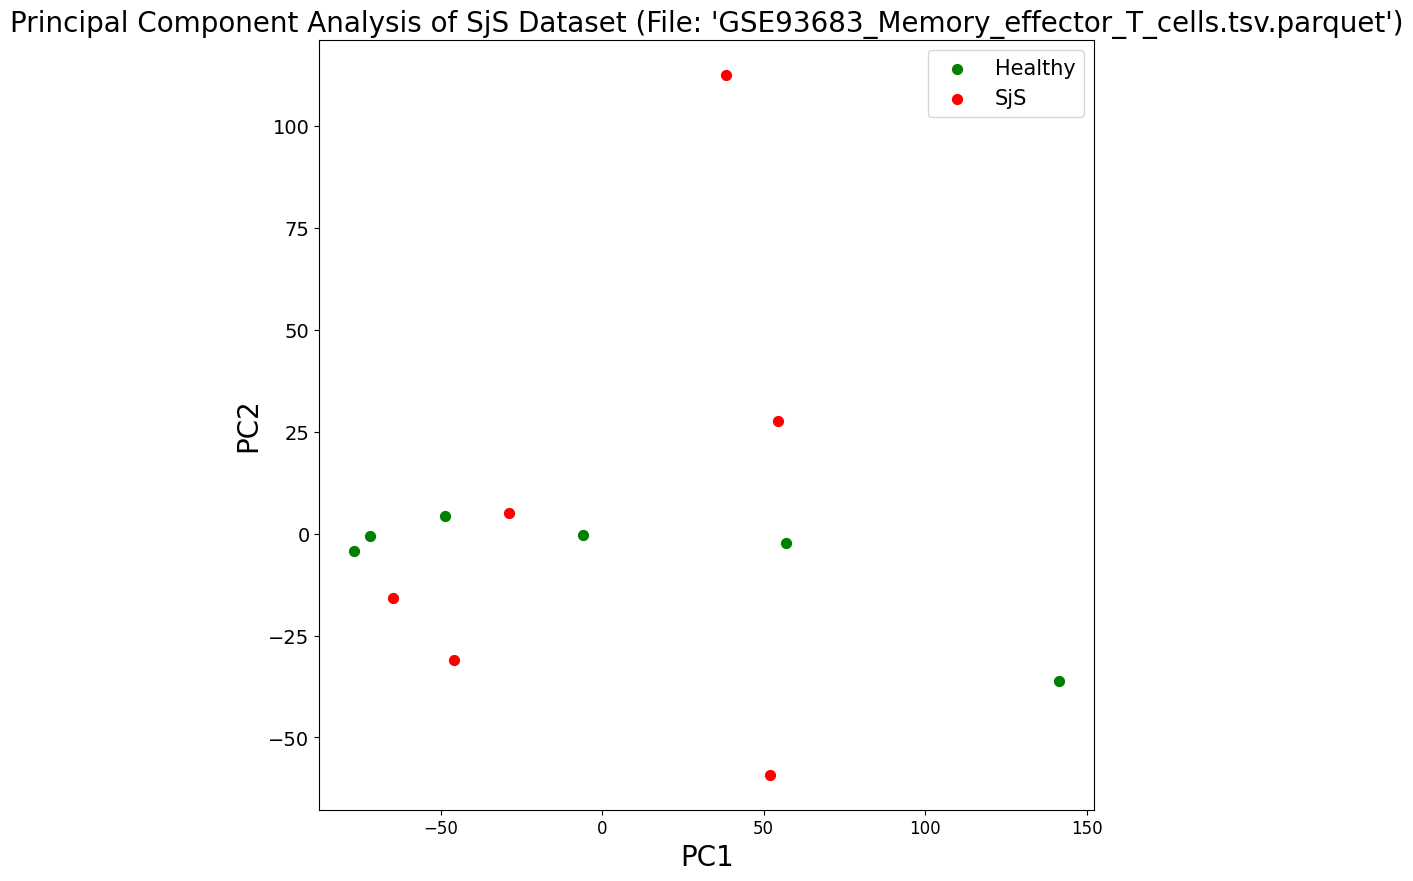

<Figure size 640x480 with 0 Axes>

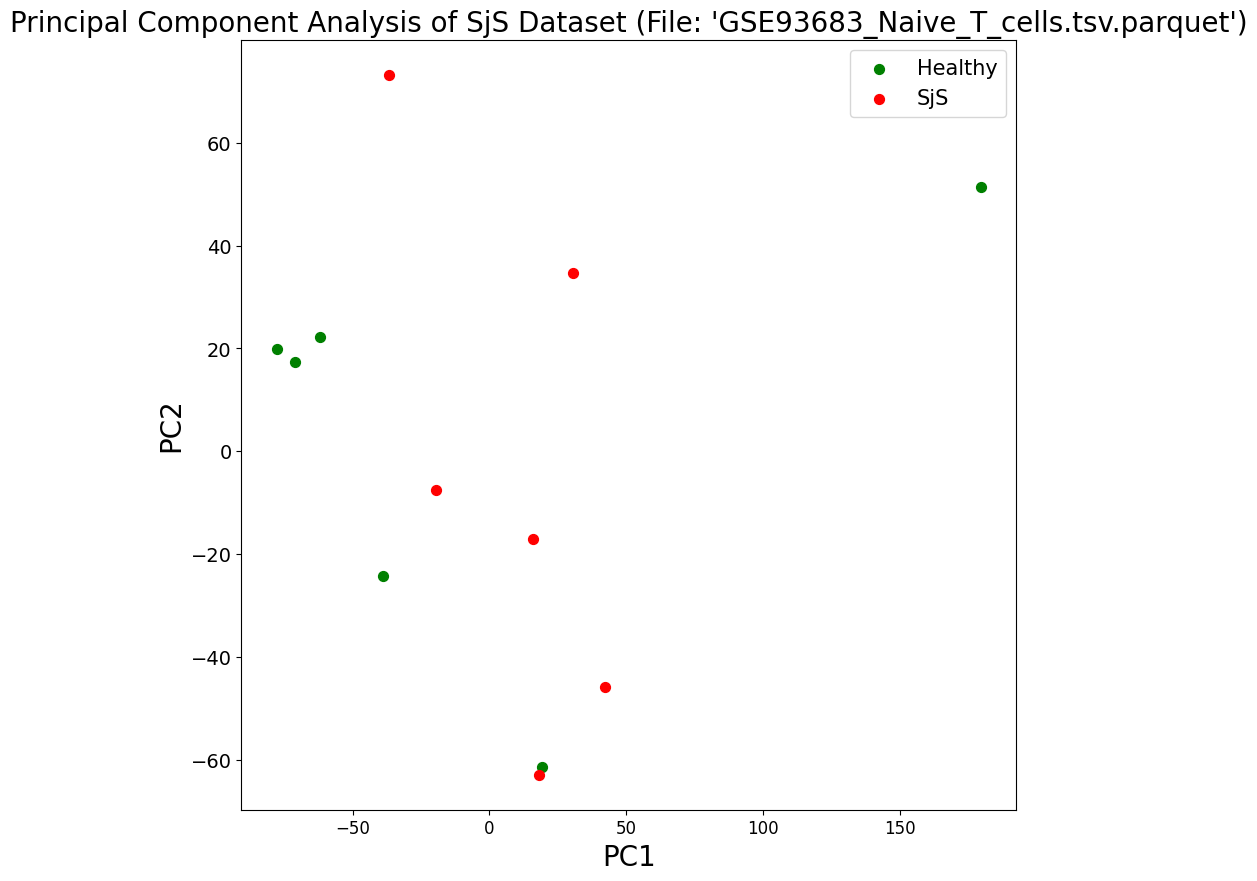

<Figure size 640x480 with 0 Axes>

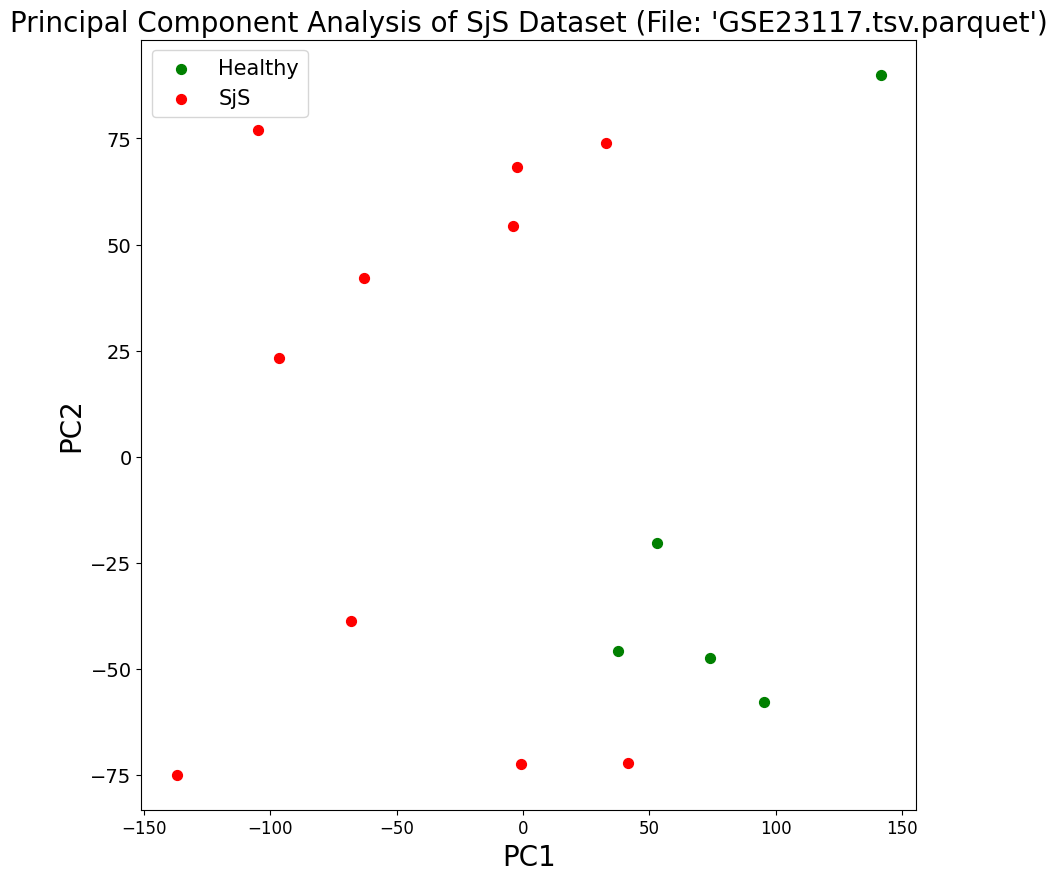

<Figure size 640x480 with 0 Axes>

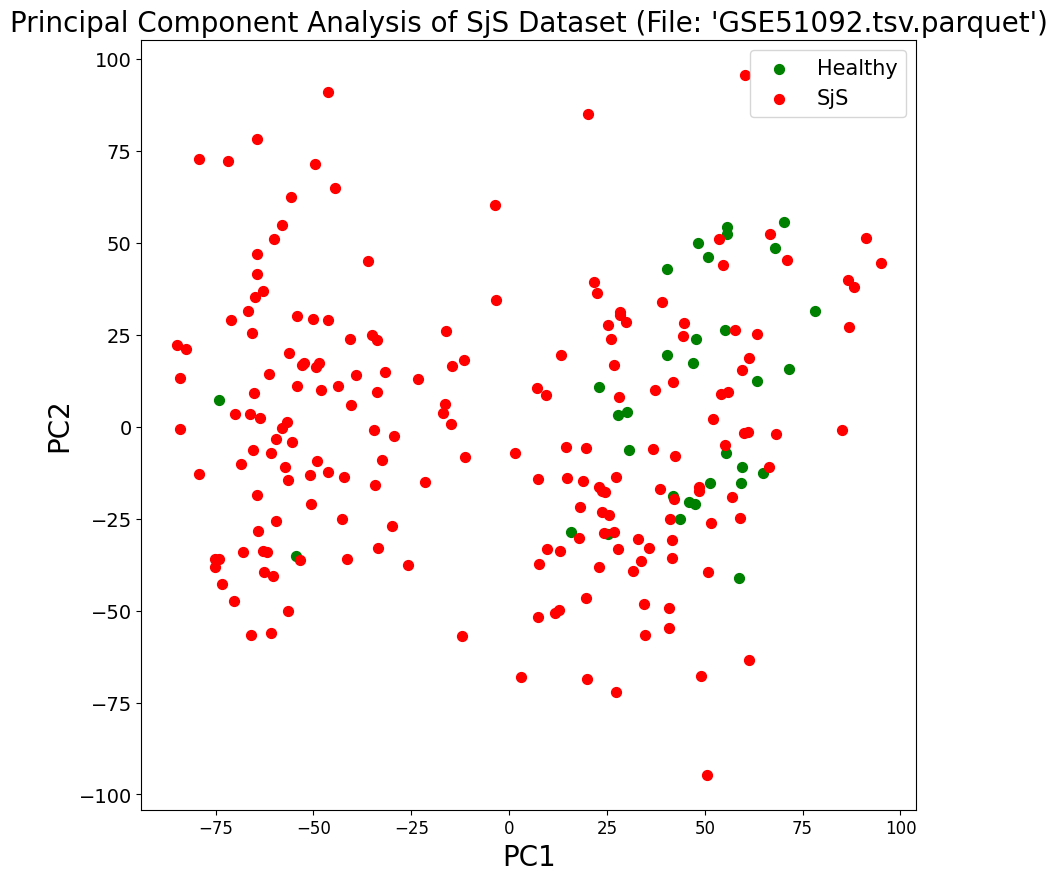

<Figure size 640x480 with 0 Axes>

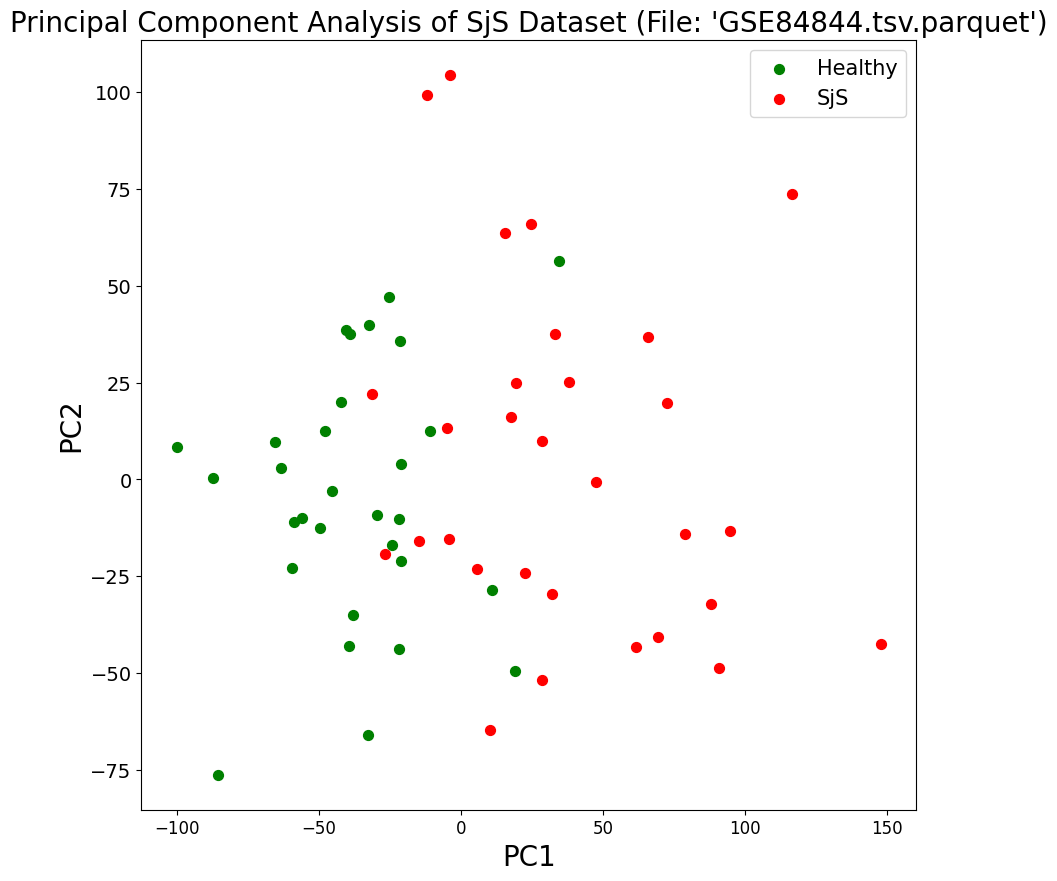

In [3]:
for condition in Condition:
    for file_path in Path(f"{files_path}/{condition.name}").glob('*.parquet'):
        file = os.path.basename(file_path)
        logging.info(f"Processing file: {file}")
        
        pca = PcaHelper(FileDataLoader(condition, file_name=file), files_path, metadata_path, datasets_info_path)
        pca.draw(
            column_that_defines_colors="Condition",
            target_colors=[
                ("Healthy", "g"),
                (condition.name, "r")
            ]
        )